In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from matplotlib import patches
from scipy import stats
import geopandas as gpd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc

import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_white


# Loading ofer, demand and aggregated measures databases

In [11]:
dem = pd.read_csv('Bases finais/basedemandaeleitoral.csv')


dem['peso'] = dem['peso'].replace({'Unweighted':1})
dem = dem.astype({'peso':'float64', 'ano_eleicao':'category'})

dem.head()
dem.shape

(43178, 10)

In [13]:
# Recoding Trust in Parties Variable

def remap_category(value):
    if value == "A lot":
        return 3
    elif value == "Some":
        return 2
    elif value == "A little":
        return 1
    elif value == "No confidence at all":
        return 0
    else:
        return pd.NA

dem1 = dem.copy()
dem1['conf_part2'] = dem1['conf_part'].map(remap_category)
dem1 = dem1.astype({'conf_part2':'Int64', 'peso':'float64', 'ano_eleicao':'category'})
print(dem1.shape)
dem1.head()

(43178, 11)


pais  ano_survey ano_eleicao  peso              posi_pol  \
0  Argentina        1995        1995   1.0  Don't know/No answer   
1  Argentina        1995        1995   1.0                     6   
2  Argentina        1995        1995   1.0                     5   
3  Argentina        1995        1995   1.0                     4   
4  Argentina        1995        1995   1.0                     3   

        sit_econ                        princ_prob conf_cong  \
0            Bad           Não sabe/ Não respondeu      Some   
1  About Average        Economia e desenvolvimento     A lot   
2            Bad        Economia e desenvolvimento  A little   
3       Very Bad        Economia e desenvolvimento      Some   
4           Good  Meio ambiente e sustentabilidade  A little   

              conf_part            conf_presi  conf_part2  
0                  Some                 A lot           2  
1                  Some                 A lot           2  
2              A little              A little           1  
3                  Some  No confidence at all           2  
4  No confidence at all                  Some           0

In [14]:
def remap_category_econ(value):
    if value == "Very Good":
        return 4
    if value == "Good":
        return 3
    elif value == "About Average":
        return 2
    elif value == "Bad":
        return 1
    elif value == "Very Bad":
        return 0
    else:
        return pd.NA

dem2 = dem1.copy()
dem2['sit_econ2'] = dem2['sit_econ'].map(remap_category_econ)
dem2 = dem2.astype({'sit_econ2':'Int64', 'peso':'float64', 'ano_eleicao':'category'})
dem2.head()
dem2.shape

(43178, 12)

In [26]:
ofer = pd.read_csv("Bases finais/baseofertaeleitoral.csv", dtype={'tom_tempo_apelo':'category', 'tipo_apelo': 'Int64',
                                                                 'N_video': 'Int64', 'emocao_apelo':'category', 'musica':'category',
                                                                 'tempo_apelo_pais':'category', 'temas_completo':'category',
                                                                 'princ_tema_maincats':'category', 
                                                                 'princ_probelec_maincats':'category',
                                                                 'match_probtema_maincats':'Int64'})


# Variables related to elections and campaigns

strut = ofer.iloc[:, 0:18].columns.append(ofer.iloc[:, 26:].columns)

# Variables related to electoral appeals

elect = ofer.iloc[:, 19:26].columns

# Filtering campaings for appeals

ofer1 = ofer.copy()
ofer1= ofer[(ofer['N_apelo']>=91) & (ofer['Peças_TV']>=7)]

print(ofer.shape, ofer1.shape)
a = ofer1[['pais', 'ano_eleicao', 'candidato']].drop_duplicates().reset_index(drop=True)
a.shape[0]

(48994, 38) (46171, 38)


96

In [17]:
elect_var = ['pais', 'ano_eleicao']
elect_var += list(elect)

b = ofer[strut]
b = b.drop_duplicates().reset_index(drop=True)

a = ofer1.copy().dropna(subset = 'tipo_apelo')

# Calculating index of neutrality of appeals

a['apelos_ativos']=np.where(a['tipo_apelo']==0, 0, 1)
a['neutralidade_apelo']=np.where(a['tipo_apelo']==0, 1, 0)

a = a.replace({'tipo_apelo':99}, None).groupby(['pais', 'ano_eleicao', 'candidato']).agg({
    'tipo_apelo': 'mean', 'apelos_ativos':'mean', 'neutralidade_apelo':'mean'}).reset_index()

ofestim = pd.merge(a, b, how='left', on=['pais', 'ano_eleicao', 'candidato'])

# Calculating Predominant Mobilization Index (IMP)

ofestim['IMP'] = ofestim['tipo_apelo'] * ofestim['apelos_ativos']
ofestim.Orientacao = ofestim.Orientacao.replace([1.0, 2.0, 3.0], ['Esquerda', 'Centro', 'Direita'])
ofestim.Situacao_oposicao = ofestim.Situacao_oposicao.replace([1.0, 2.0, 3.0], ['Situação', 'Oposição', 'Independente'])

# Colors used in graphs

cores_personalizadas = {
    "Economia e desenvolvimento": "#FFC107",  
    "Segurança e justiça": "#1E88E5",  
    "Educação e conhecimento": "#38C636",  
    "Corrupção e transparência": "#51868A",  
    "Igualdade e inclusão": "#571AFD", 
    "Saúde e bem-estar": "#29FBA4",
    "Valores e tradição": "#5B0FB0", 
    "Meio ambiente": "#44BF3F",
    "Política externa": "#309A38",
}

print(ofestim.shape)
ofestim.head()
ofestim.to_csv("ofestimfull.csv", index=False)

(155, 34)


# Electoral Demand Analysis

## Trust in Parties

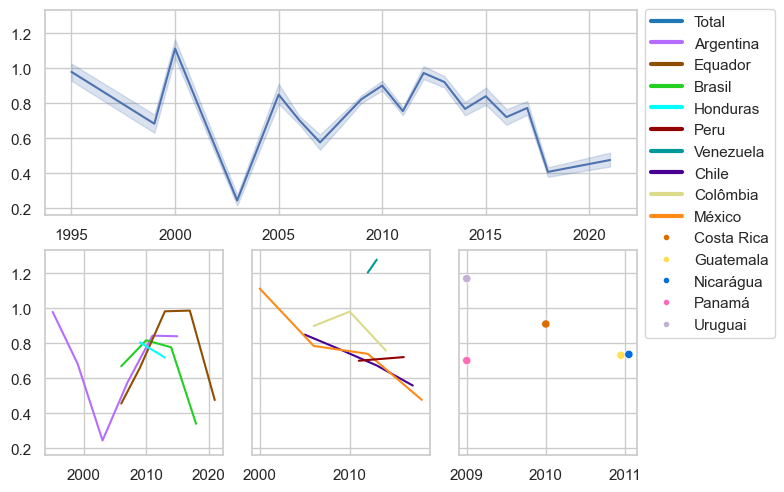

In [129]:
# Calculating weighted average per country and year of election

dem2 = dem1.dropna(subset='conf_part2')

wei_grouped = dem2.groupby(['pais', 'ano_eleicao'],  
                           observed= False).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

wei_grouped.rename(columns={0:'conf_part2'}, inplace = True)


apel_temp = wei_grouped

apel_temp1 = apel_temp[(apel_temp['pais']=='Peru') | (apel_temp['pais']=='Venezuela') | (apel_temp['pais']== 'Chile') |
                       (apel_temp['pais']=='Colômbia') | (apel_temp['pais']=='México')]


apel_temp2 = apel_temp[(apel_temp['pais']=='Honduras') | (apel_temp['pais']=='Brasil') | (apel_temp['pais']== 'Equador') |
                       (apel_temp['pais']=='Argentina')]


apel_temp3 = apel_temp[(apel_temp['pais']=='Costa Rica') | (apel_temp['pais']=='Guatemala') | (apel_temp['pais']== 'Nicarágua') |
                       (apel_temp['pais']=='Panamá') | (apel_temp['pais']=='Uruguai')]

#Adding Jitter to scatterplot

apel_temp3 = apel_temp3.astype({'ano_eleicao':'float'})
apel_temp3.loc[(apel_temp3['pais'] == 'Nicarágua') & (apel_temp3['ano_eleicao'] == 2011), 'ano_eleicao'] += 0.05
apel_temp3.loc[(apel_temp3['pais'] == 'Guatemala') & (apel_temp3['ano_eleicao'] == 2011), 'ano_eleicao'] -= 0.05
apel_temp3

#Setting countries names and colors

pline = [
    'Argentina',
    'Equador',
    'Brasil',
    'Honduras',
    'Peru',
    'Venezuela',
    'Chile',    
    'Colômbia',
    'México',
]


corline = [
    '#b66dff',
    '#8f4e00',  
    '#22cf22',  
    '#00FFFF',  
    '#920000', 
    '#009999', 
    '#490092',  
    '#dbdb8b',  
    '#fc8b17', 
]

pal1 = {'México': '#fc8b17', 'Colômbia':'#dbdb8b', 'Chile':'#490092', 'Venezuela':'#009999', 'Peru':'#920000'}
pal2 = {'Argentina':'#b66dff', 'Equador':'#8f4e00', 'Brasil':'#22cf22', 'Honduras':'#00FFFF'}


pdot = [
    'Costa Rica',
    'Guatemala',
    'Nicarágua',
    'Panamá',
    'Uruguai'
]

cordot = [
    '#db6d00',  
    '#ffdf4d',  
    '#006ddb', 
    '#ff6db6',  
    '#c5b0d5',  
]

pal3 ={}
for pais, cor in zip(pdot, cordot):
    pal3[pais]=cor

sns.set_theme(style="whitegrid")


fig, axes = plt.subplot_mosaic([['a', 'a', 'a'], ['b', 'c', 'd']],
                              layout='compressed', sharey=True)

av = sns.lineplot(dem2, x = 'ano_eleicao', y = 'conf_part2', weights='peso', ax=axes['a'])

av1 = sns.lineplot(data=apel_temp1, x="ano_eleicao", y="conf_part2", hue='pais', palette=pal1, errorbar = None, ax=axes['c'],
                   legend=False
)
    
av2 = sns.lineplot(
    data=apel_temp2, x="ano_eleicao", y="conf_part2", hue='pais', palette=pal2, errorbar = None, ax=axes['b'], legend=False
)


av3 = sns.scatterplot(
    data=apel_temp3, x="ano_eleicao", y="conf_part2", hue='pais', palette=pal3, legend=False, ax=axes['d']
)

# Removing unnecessary labels

axes['a'].set_xlabel('')
axes['a'].set_ylabel('')
axes['b'].set_xlabel('')
axes['b'].set_ylabel('')
axes['c'].set_xlabel('')
axes['d'].set_xlabel('')

#Creating legend

#Set legend icons and categories
total = [mlines.Line2D([0], [0], color='#1f77b4', linewidth=3, label = 'Total')]
lines = [mlines.Line2D([0], [0], color=corline, linewidth=3, label = pline) for corline, pline in zip(corline, pline)]
dots = [mlines.Line2D([0], [0], label= p, marker='.', linestyle='', color = c) for c, p in zip(cordot, pdot)]
handles = total + lines + dots
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.1, 1.01))
#av3.set_xticklabels(['2009','2010','2011'])
plt.show()

## Economic situation evaluation

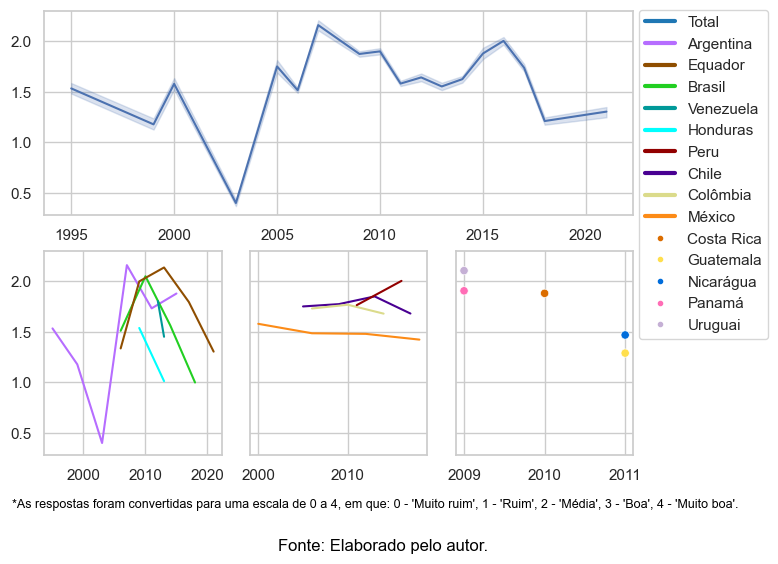

In [145]:
#| fig-cap: "Avaliação da situação econômica do país por período eleitoral"
#| label: fig-sitecon

# Calculating weighted average per country and year of election

dem3 = dem2.dropna(subset='sit_econ2')

wei_grouped = dem3.groupby(['pais', 'ano_eleicao'], observed=False).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                                                         include_groups=False).reset_index()

wei_grouped.rename(columns={0:'sit_econ2'}, inplace = True)


apel_temp = wei_grouped

apel_temp1 = apel_temp[(apel_temp['pais']=='Peru') | (apel_temp['pais']== 'Chile') |
                       (apel_temp['pais']=='Colômbia') | (apel_temp['pais']=='México')]


apel_temp2 = apel_temp[(apel_temp['pais']=='Honduras') | (apel_temp['pais']=='Brasil') | (apel_temp['pais']== 'Equador') |
                       (apel_temp['pais']=='Argentina') | (apel_temp['pais']=='Venezuela')]


apel_temp3 = apel_temp[(apel_temp['pais']=='Costa Rica') | (apel_temp['pais']=='Guatemala') | (apel_temp['pais']== 'Nicarágua') |
                       (apel_temp['pais']=='Panamá') | (apel_temp['pais']=='Uruguai')]



#Creating legend

#Setting countries names and colors

pline = [
    'Argentina',
    'Equador',
    'Brasil',
    'Venezuela',
    'Honduras',
    'Peru',
    'Chile',    
    'Colômbia',
    'México',
]


corline = [
    '#b66dff',
    '#8f4e00',  
    '#22cf22',
    '#009999', 
    '#00FFFF',  
    '#920000', 
    '#490092',  
    '#dbdb8b',  
    '#fc8b17', 
]

pal1 = {'México': '#fc8b17', 'Colômbia':'#dbdb8b', 'Chile':'#490092', 'Peru':'#920000'}
pal2 = {'Argentina':'#b66dff', 'Equador':'#8f4e00', 'Brasil':'#22cf22', 'Honduras':'#00FFFF','Venezuela':'#009999',}


pdot = [
    'Costa Rica',
    'Guatemala',
    'Nicarágua',
    'Panamá',
    'Uruguai'
]

cordot = [
    '#db6d00',  
    '#ffdf4d',  
    '#006ddb', 
    '#ff6db6',  
    '#c5b0d5',  
]

pal3 ={}
for pais, cor in zip(pdot, cordot):
    pal3[pais]=cor

sns.set_theme(style="whitegrid")


fig, axes = plt.subplot_mosaic([['a', 'a', 'a'], ['b', 'c', 'd']],
                              layout='compressed', sharey=True)

av = sns.lineplot(dem2, x = 'ano_eleicao', y = 'sit_econ2', weights='peso', ax=axes['a'])

av1 = sns.lineplot(data=apel_temp1, x="ano_eleicao", y="sit_econ2", hue='pais', palette=pal1, errorbar = None, ax=axes['c'],
                   legend=False
)
    
av2 = sns.lineplot(
    data=apel_temp2, x="ano_eleicao", y="sit_econ2", hue='pais', palette=pal2, errorbar = None, ax=axes['b'], legend=False
)

av3 = sns.scatterplot(
    data=apel_temp3, x="ano_eleicao", y="sit_econ2", hue='pais', palette=pal3, ax=axes['d'], legend=False
)

# Create a custom legend outside of the subplots

axes['a'].set_xlabel('')
axes['a'].set_ylabel('')

axes['b'].set_xlabel('')
axes['b'].set_ylabel('')

axes['c'].set_xlabel('')

axes['d'].set_xlabel('')


#Set legend icons and categories
total = [mlines.Line2D([0], [0], color='#1f77b4', linewidth=3, label = 'Total')]
lines = [mlines.Line2D([0], [0], color=corline, linewidth=3, label = pline) for corline, pline in zip(corline, pline)]
dots = [mlines.Line2D([0], [0], label= p, marker='.', linestyle='', color = c) for c, p in zip(cordot, pdot)]
handles = total + lines + dots
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.09, 1.01))

# footnote 

nota_de_rodape = fig.text(0.01,  -0.05,
    "*As respostas foram convertidas para uma escala de 0 a 4, em que: 0 - 'Muito ruim', 1 - 'Ruim', 2 - 'Média', " 
    "3 - 'Boa', 4 - 'Muito boa'.",
    ha="left",
    va="bottom",  
    fontsize=9, 
    color="black"
)
    

# footnote source 

nota_de_rodape = fig.text(
    0.59,  -0.14,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
#    fontsize=25, 
    color="black"
)

plt.show()

## Correlation Economic Situation evaluation x trust in parties (all 36 countries in demand database)

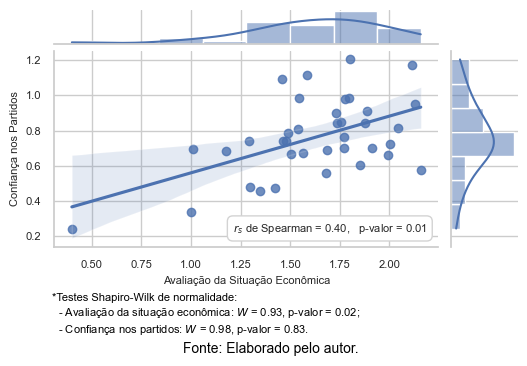

In [72]:
#| fig-cap: "Correlação entre avaliação da situação econômica e confiança nos partidos por país e eleição com todos os países do banco 
#de demanda"
#| label: fig-econconf

# Calculating weighted Variables
dem_semna = dem2.dropna(subset=['conf_part2', 'sit_econ2'])

conf_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['conf_part2'], weights=x['peso']), include_groups = False).reset_index()

sit_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['sit_econ2'], weights=x['peso']), include_groups = False).reset_index()
                                                         
jun= pd.merge(conf_w, sit_w, on = ['pais', 'ano_eleicao'], how='left')
jun.rename(columns={'0_x':'Confiança nos Partidos', '0_y': 'Avaliação da Situação Econômica'}, inplace = True)

sns.set_theme(style = 'whitegrid')
af = sns.jointplot(jun, x ='Avaliação da Situação Econômica', y = 'Confiança nos Partidos', kind='reg', height = 4)

# Shapiro-Wilk normality test to check which correlation test to use (Pearson's assumes normal distribution)

fconf, pconf = stats.shapiro(jun['Confiança nos Partidos'])
fsit, psit = stats.shapiro(jun['Avaliação da Situação Econômica'])


#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.spearmanr(jun["Confiança nos Partidos"], jun["Avaliação da Situação Econômica"])
plt.annotate(f"$r_s$ de Spearman = {r:.2f},   p-valor = {p_valor:.2f}", 
             xy=(0.97, 0.13), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5'))


plt.text(
    0.3, -0.12,
    f"*Testes Shapiro-Wilk de normalidade:\n  - Avaliação da situação econômica: $W$ = {fsit:.2f}, p-valor = {psit:.2f};\n  - Confiança"
    f" nos partidos: $W$ = {fconf:.2f}, p-valor = {pconf:.2f}.",
    ha="left",
    va="top",    
    fontsize=8, 
    color="black"
)


# footnote source 

plt.text(
    1.4, -0.4,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black"
)

af.fig.set_size_inches(6, 3)

plt.xlabel("Avaliação da Situação Econômica", fontsize=8) 
plt.ylabel("Confiança nos Partidos", fontsize=8)
plt.tick_params(labelsize=8)
plt.show()

## Main problem

### Problem x countries

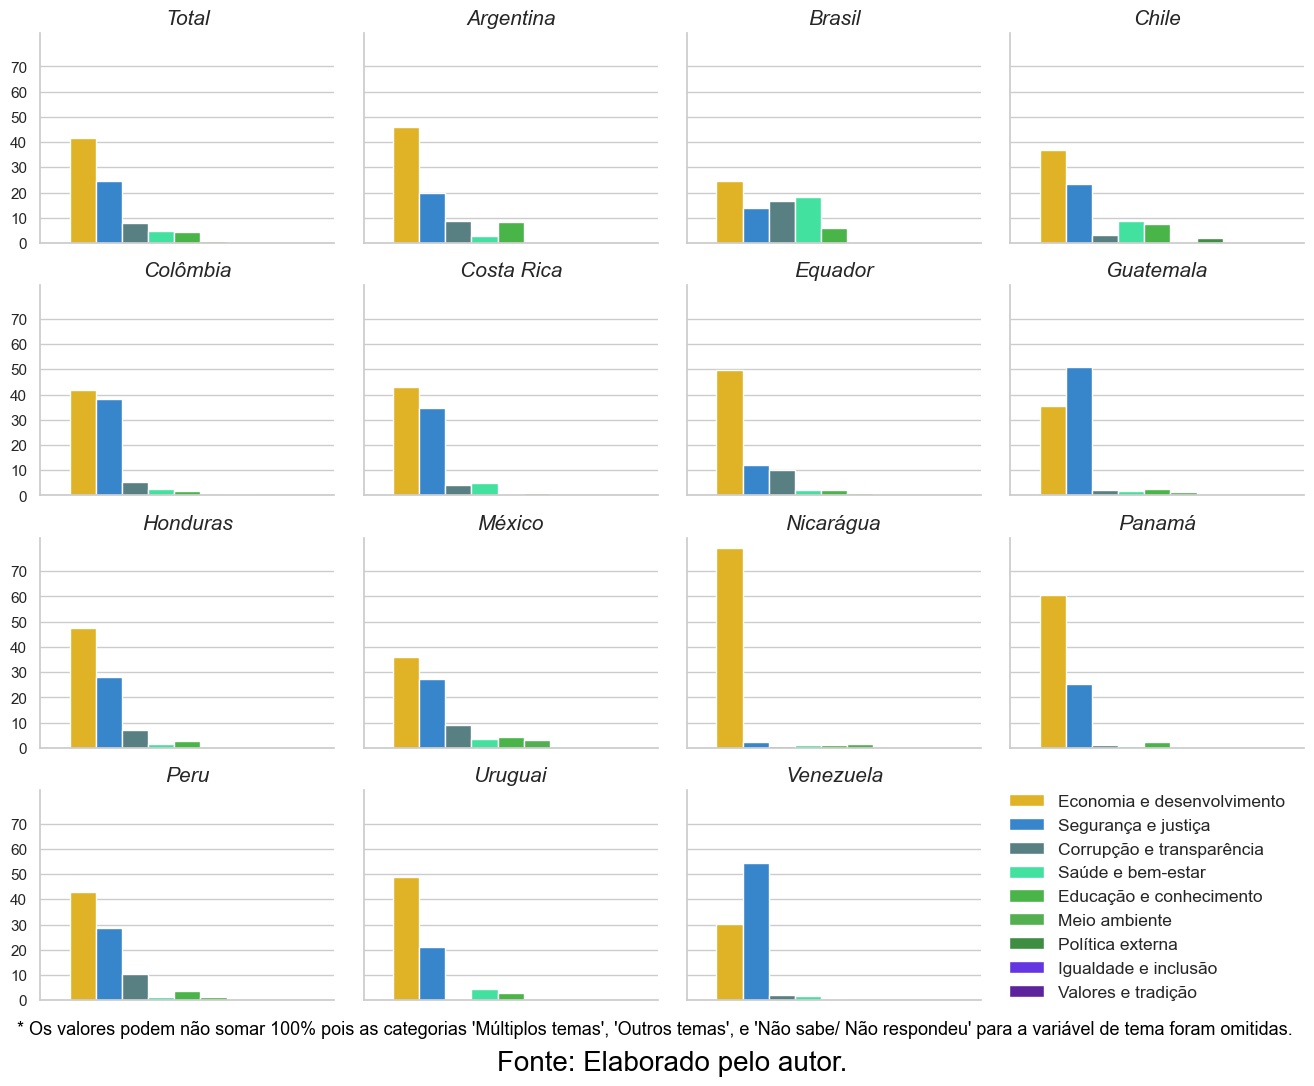

In [49]:
#| fig-cap: "Principal problema indicado pelos eleitores por país (%)"
#| label: fig-probipais

#Calculating weighted frequencies of categories
agru = dem2.groupby(['pais', 'princ_prob'])
soma_pesos = agru['peso'].sum()

agru = dem2.groupby(['pais'])
soma_pesos_pais_ano = agru['peso'].sum()

porcentagem = soma_pesos / soma_pesos_pais_ano
a = porcentagem.reset_index()


#Calculating Total Average
soma_pesos = dem2.groupby(['princ_prob'])['peso'].sum()
dfsoma_pesostotal = dem2['peso'].sum()
tot = soma_pesos/dfsoma_pesostotal
av= pd.DataFrame({'pais':'Total', 'peso':tot}).reset_index()

df = pd.concat([a, av])
df.peso = df.peso*100

df = df.astype({'princ_prob':'category'})
df['princ_prob'] = df['princ_prob'].cat.remove_categories(['Não sabe/ Não respondeu',
                                                           'Outros temas',
                                                           'Múltiplos temas'])

df['princ_prob'] = df['princ_prob'].cat.rename_categories({
                                 'Corrupção, governança e transparência':"Corrupção e transparência",
                                 'Política externa e relações internacionais':"Política externa",
                                 'Meio ambiente e sustentabilidade':'Meio ambiente'})
                         
df[df.pais=='Total'].sort_values('peso', ascending = False)

ls = list(df.pais.unique())
ls.remove('Total')
ls.insert(0, 'Total')

sns.set_style('whitegrid')

af = sns.catplot(data=df, y = 'peso', hue = 'princ_prob', kind='bar', dodge=True, palette=cores_personalizadas, col='pais', col_wrap=4,
                legend=True, col_order = ls, errorbar=('ci',95),
                hue_order=["Economia e desenvolvimento",
                           "Segurança e justiça",
                           "Corrupção e transparência",
                           "Saúde e bem-estar", 
                           "Educação e conhecimento",
                           "Meio ambiente",
                           "Política externa", 
                           "Igualdade e inclusão",
                           "Valores e tradição"]
)

# footnote 

nota_de_rodape = plt.text(
    -2.78,  -15,
    "* Os valores podem não somar 100% pois as categorias 'Múltiplos temas', 'Outros temas'," 
    " e 'Não sabe/ Não respondeu' para a variável de tema foram omitidas.",
    ha="left",
    va="bottom",    
    fontsize=13, 
    color="black"
)

# footnote source 

nota_de_rodape = plt.text(
    -0.55,  -30,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
    fontsize=20, 
    color="black"
)


af.set(xticklabels=[], xlabel=None, ylabel = None, yticks = range(0, 80, 10))
sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.67, 0.235), fontsize=12.5)
af.set_titles("{col_name}", size = 15, style = 'italic')

af.fig.subplots_adjust(wspace=0.1, hspace = 0.2)
af.fig.set_size_inches(15, 10)
af.tick_params(axis="x", labelsize=12)
plt.show()

### Problem x Ideology

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_6711/451561069.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agru = probid.groupby(['posi_pol', 'princ_prob'])
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_6711/451561069.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agru = probid.groupby(['posi_pol'])


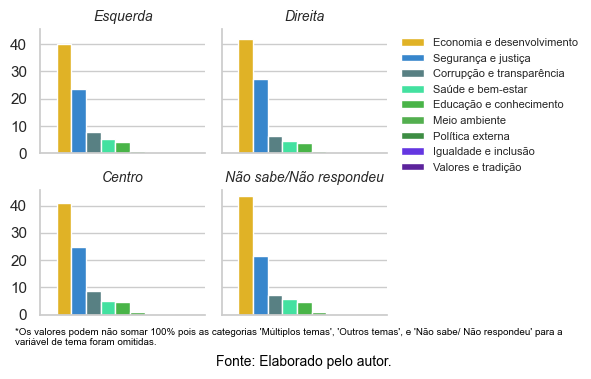

In [47]:
#| fig-cap: "Principal problema de seu país por ideologia do eleitor (%)"
#| label: fig-posiideo

probid = dem.copy()
#probid = probid.astype({'princ_prob' : 'category'})
probid.posi_pol = probid.posi_pol.replace(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', "Don't know/No answer"],
                                          ['Esquerda']*4 + ['Centro']*3 + ['Direita']*4 + ['Não sabe/Não respondeu'])



probid = probid.astype({'princ_prob':'category', 'posi_pol':'category'})
probid['princ_prob'] = probid['princ_prob'].cat.remove_categories(['Não sabe/ Não respondeu',
                                                           'Outros temas',
                                                           'Múltiplos temas'])
probid['princ_prob'] = probid['princ_prob'].cat.rename_categories({
                                 'Corrupção, governança e transparência':"Corrupção e transparência",
                                 'Política externa e relações internacionais':"Política externa",
                                 'Meio ambiente e sustentabilidade':'Meio ambiente'})



#Calculating weighted frequencies of categories
agru = probid.groupby(['posi_pol', 'princ_prob'])
soma_pesos = agru['peso'].sum()

agru = probid.groupby(['posi_pol'])
soma_pesos_pais_ano = agru['peso'].sum()

porcentagem = soma_pesos / soma_pesos_pais_ano
a = porcentagem.reset_index()
a.peso = a.peso*100

sns.set_theme(style="whitegrid", palette="pastel")

af = sns.catplot(data=a, y = 'peso', hue = 'princ_prob', kind='bar', dodge=True, palette=cores_personalizadas, col='posi_pol',
                 col_wrap=2, height= 3, legend=True, col_order=['Esquerda', 'Direita', 'Centro', 'Não sabe/Não respondeu'],
                 hue_order=["Economia e desenvolvimento",
                           "Segurança e justiça",
                           "Corrupção e transparência",
                           "Saúde e bem-estar", 
                           "Educação e conhecimento",
                           "Meio ambiente",
                           "Política externa", 
                           "Igualdade e inclusão",
                           "Valores e tradição"])

# footnote 

nota_de_rodape = plt.text(
    -1.75,  -12,
    "*Os valores podem não somar 100% pois as categorias 'Múltiplos temas', 'Outros temas', e 'Não sabe/ Não respondeu' para a\nvariável de tema foram omitidas.",
    ha="left",
    va="bottom",    
    fontsize=7, 
    color="black"
)

# footnote source 

nota_de_rodape = plt.text(
    0,  -20,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
    fontsize=10, 
    color="black"
)


af.set(xticklabels=[], xlabel=None, ylabel = None, yticks=range(0, 50, 10))
sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.7, 0.94), fontsize=8)
af.set_titles("{col_name}", size = 10, style='italic')
af.fig.subplots_adjust(wspace=0.1, hspace=0.3)
af.fig.set_size_inches(6, 3.2)

plt.show()

## Ideological Position per country

In [92]:
# Centering y axis on 0
df_centro = dem2.copy()
df_centro.posi_pol = np.where(df_centro.posi_pol == "Don't know/No answer", np.nan, df_centro.posi_pol)
df_centro = df_centro.dropna(subset=['posi_pol']).astype({'posi_pol':'Int64'})
df_centro['posi_poli_centro'] = df_centro['posi_pol'] - 5
df_centro

pais  ano_survey ano_eleicao  peso  posi_pol       sit_econ  \
1      Argentina        1995        1995   1.0         3  About Average   
2      Argentina        1995        1995   1.0         2       Very Bad   
3      Argentina        1995        1995   1.0         6  About Average   
4      Argentina        1995        1995   1.0         5  About Average   
5      Argentina        1995        1995   1.0         4  About Average   
...          ...         ...         ...   ...       ...            ...   
43170    Equador        2020        2021   1.0         5            Bad   
43171    Equador        2020        2021   1.0         1  About Average   
43175    Equador        2020        2021   1.0        10  About Average   
43176    Equador        2020        2021   1.0         5  About Average   
43177    Equador        2020        2021   1.0         5            Bad   

                                  princ_prob             conf_cong  \
1                 Economia e desenvolvimento  No confidence at all   
2      Corrupção, governança e transparência              A little   
3                 Economia e desenvolvimento                  Some   
4                 Economia e desenvolvimento              A little   
5                 Economia e desenvolvimento              A little   
...                                      ...                   ...   
43170             Economia e desenvolvimento  No confidence at all   
43171                      Saúde e bem-estar              A little   
43175                      Saúde e bem-estar  No confidence at all   
43176                Educação e conhecimento  No confidence at all   
43177             Economia e desenvolvimento              A little   

                  conf_part            conf_presi  conf_part2  sit_econ2  \
1      No confidence at all              A little           0          2   
2                  A little  No confidence at all           1          0   
3                  A little              A little           1          2   
4                  A little              A little           1          2   
5                  A little              A little           1          2   
...                     ...                   ...         ...        ...   
43170  No confidence at all  No confidence at all           0          1   
43171              A little              A little           1          2   
43175  No confidence at all                  Some           0          2   
43176  No confidence at all  No confidence at all           0          2   
43177  No confidence at all  No confidence at all           0          1   

       posi_poli_centro  
1                    -2  
2                    -3  
3                     1  
4                     0  
5                    -1  
...                 ...  
43170                 0  
43171                -4  
43175                 5  
43176                 0  
43177                 0  

[34114 rows x 13 columns]

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_37364/385185554.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  af = sns.catplot(


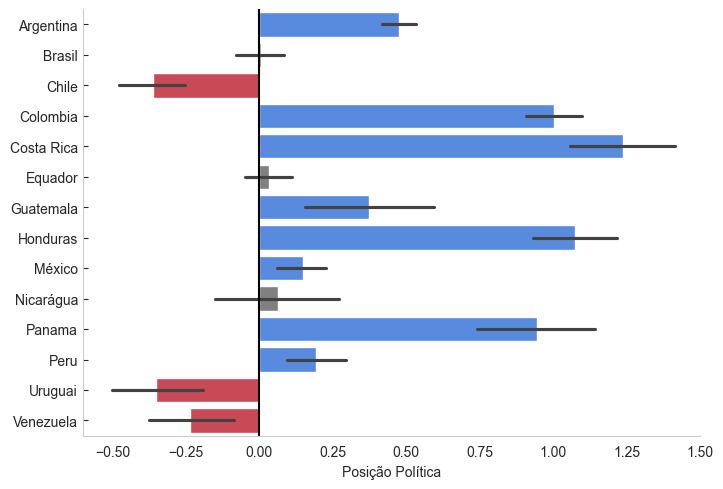

In [501]:

# Demand ideological distribution 

lis = df_centro.sort_values('pais')
lis.pais.unique()
cores = {'Chile': '#DC3545',
         'Uruguai': '#DC3545',
         'Venezuela': '#DC3545', 
         'Argentina':'#4285F4',
         'Colombia':'#4285F4', 'Costa Rica':'#4285F4', 'Guatemala':'#4285F4', 'Honduras':'#4285F4', 'México':'#4285F4',
         'Panama':'#4285F4',
         'Peru':'#4285F4',
         'Brasil':'#808080', 'Equador':'#808080', 'Nicarágua':'#808080'}

sns.set_style('whitegrid', rc={'ytick.left': True, 'axes.grid': False, 'ytick.direction': 'in'})

# Creating FacetGrid
af = sns.catplot(
    data=df_centro,
    y="pais",
    #hue='cor',
    order=lis.pais.unique(),
    x="posi_poli_centro",
    kind="bar",
    dodge='auto',
    height=5,
    legend=False,
    weights='peso',
    palette=cores,
    aspect=1.5 # Ajustar proporção do gráfico
)

# Adjusting Axes Labels
af.set_axis_labels("Posição Política", "")
plt.axvline(x = 0, color = "black", linestyle = "-")
plt.xlim(-0.6, 1.5)
# Personalizar títulos
af.set_titles("{col_name}")

plt.show()

'''

Há um grupo de países mais a direita, composto por Colômbia, Costa Rica, Honduras e Panamá. Por outro lado, há o grupo de países de 
direita moderada, composto por Argentina, Guatemala México e Peru. Ao lado, há o grupo de centro: Brasil, Equador e Nicarágua, em que 
suas médias não são significativamente distintas de 0. Por fim, há os países de tendência moderada à esquerda, de acordo com o posicio-
namento de seus eleitores: Chile, Uruguai e Venezuela
'''

# Electoral Offer Analysis

## Distribution of variables

### IMP and Mobilization Degree distribution

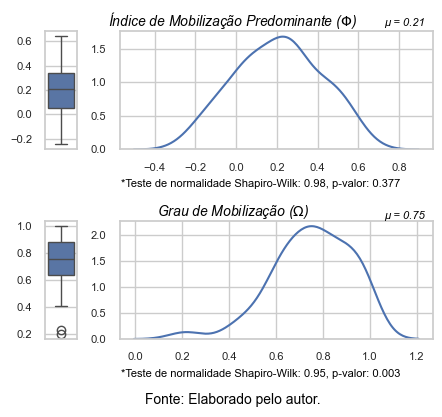

In [46]:
#| fig-cap: "Funções densidade de probabilidade dos indicadores de mobilização por campanha"
#| label: fig-distimp

sns.set_theme(style = 'whitegrid')
fig, axes = plt.subplot_mosaic([[0,2], [1, 3]], width_ratios=[1,10], figsize=(5, 4))

# IMP boxplot
sns.boxplot(data=ofestim, y="IMP", ax=axes[0])
axes[0].set_ylabel('')
axes[0].tick_params(labelsize=8)

# Mobilization Degree boxplot
sns.boxplot(data=ofestim, y="apelos_ativos", ax=axes[1])
axes[1].set(xlabel='',ylabel='')
axes[1].tick_params(labelsize=8)

# PDF IMP
af = sns.kdeplot(ofestim, x = 'IMP', ax = axes[2])
af.set(ylabel='', xlabel='')
af.tick_params(labelsize=8)

# PDF Mobilization Degree
av = sns.kdeplot(ofestim, x = 'apelos_ativos', ax = axes[3])
av.set(ylabel='', xlabel='')
av.tick_params(labelsize=8)

# Shapiro-Wilk testes

timp, pimp = stats.shapiro(ofestim.IMP)
tmob, pmob = stats.shapiro(ofestim.apelos_ativos)

#Sub titles

#IMP
fig.text(
    0.5,  0.88,
    "Índice de Mobilização Predominante ($\Phi$)",
    ha="center",
    va="bottom",    
    fontsize=10, 
    color="black",
    style='italic'

)

#IMP mean

fig.text(
    0.843,  0.888,
    f'μ = {ofestim.IMP.mean():.2F}',
    ha="center",
    va="bottom",    
    fontsize=8, 
    color="black",
    style='italic'
)
# Mobilization Degree

fig.text(
    0.5,  0.405,
    "Grau de Mobilização ($\Omega$)",
    ha="center",
    va="bottom",    
    fontsize=10, 
    color="black",
    style='italic'
)

# Mobilization Degree Mean

fig.text(
    0.843,  0.405,
    f'μ = {ofestim.apelos_ativos.mean():.2F}',
    ha="center",
    va="bottom",    
    fontsize=8, 
    color="black",
    style='italic'
)

# Shapiro-Wilk IMP 

fig.text(
    0.276, 0.485,
    f"*Teste de normalidade Shapiro-Wilk: {timp:.2f}, p-valor: {pimp:.3f} ",
    ha="left",
    va="bottom",    
    color="black",
    fontsize=8
)

# Shapiro-Wilk mobilization Degree 

fig.text(
    0.276, 0.01,
    f"*Teste de normalidade Shapiro-Wilk: {tmob:.2f}, p-valor: {pmob:.3f} ",
    ha="left",
    va="bottom",    
    color="black",
    fontsize=8
)

# footnote source 

fig.text(
    0.5, -0.06,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
    color="black",
    fontsize=10
)


fig.subplots_adjust(hspace=0.6, wspace=0.25)

plt.show()

### Structural variables distributions

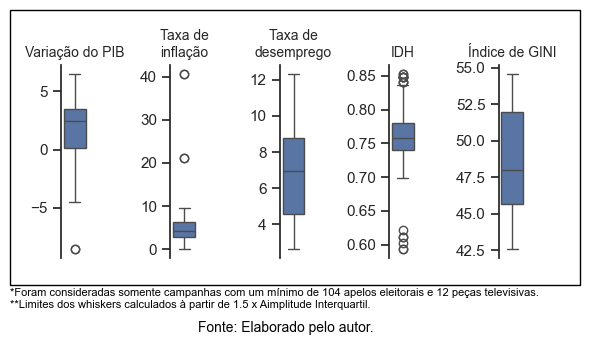

In [5]:
#| fig-cap: "Distribuição das variáveis estruturais para as eleições das campanhas analisadas"
#| label: fig-dist

sns.set_theme(style = 'white')

fig, axes = plt.subplot_mosaic([['a','e', 'd', 'b', 'c']], sharey = False, figsize = (6,2.5))

# GDP variation
sns.boxplot(data=ofestim, y="var_anual_PIBpercapita", meanline= True, ax=axes['a'])
axes['a'].set_title('Variação do PIB', fontsize = 10)
subplot12 = axes['a']
subplot12.spines['top'].set_visible(False)
subplot12.spines['right'].set_visible(False)
subplot12.spines['bottom'].set_visible(False)
subplot12.spines['left'].set_visible(True)
subplot12.tick_params(bottom=False, top=False, left=True, right=False)

# HDI Variation
sns.boxplot(data=ofestim, y="HDI", meanline= True, ax=axes['b'])

subplot12 = axes['b']
subplot12.set_title("IDH", fontsize = 10)
subplot12.spines['top'].set_visible(False)
subplot12.spines['right'].set_visible(False)
subplot12.spines['bottom'].set_visible(False)
subplot12.spines['left'].set_visible(True)
subplot12.tick_params(bottom=False, top=False, left=True, right=False)

# Gini Index 
sns.boxplot(data=ofestim, y="Gini_index", ax=axes['c'])
axes['c'].set_title('Índice de GINI', fontsize = 10)
subplot12 = axes['c']
subplot12.spines['top'].set_visible(False)
subplot12.spines['right'].set_visible(False)
subplot12.spines['bottom'].set_visible(False)
subplot12.spines['left'].set_visible(True)
subplot12.tick_params(bottom=False, top=False, left=True, right=False)

# Unemployment
sns.boxplot(data=ofestim, y="desemprego", meanline=True, ax=axes['d'])
axes['d'].set_title('Taxa de\ndesemprego', fontsize = 10)
subplot12 = axes['d']
subplot12.spines['top'].set_visible(False)
subplot12.spines['right'].set_visible(False)
subplot12.spines['bottom'].set_visible(False)
subplot12.spines['left'].set_visible(True)
subplot12.tick_params(bottom=False, top=False, left=True, right=False)

# Inflation
sns.boxplot(data=ofestim, y="inflacao_CPI", meanline=True, ax=axes['e'])
axes['e'].set_title('Taxa de\ninflação', fontsize = 10)
subplot12 = axes['e']
subplot12.spines['top'].set_visible(False)
subplot12.spines['right'].set_visible(False)
subplot12.spines['bottom'].set_visible(False)
subplot12.spines['left'].set_visible(True)
subplot12.tick_params(bottom=False, top=False, left=True, right=False)

# Removing unnecessary labels

axes['a'].set_ylabel('')
axes['b'].set_ylabel('')
axes['c'].set_ylabel('')
axes['d'].set_ylabel('')
axes['e'].set_ylabel('')

# footnote 1

fig.text(
    0.04,  -0.05,
    "*Foram consideradas somente campanhas com um mínimo de 104 apelos eleitorais e 12 peças televisivas.",
    ha="left",
    va="bottom",    
    fontsize=8, 
    color="black"
)

# footnote 2

fig.text(
    0.04,  -0.1,
    "**Limites dos whiskers calculados à partir de 1.5 x Aimplitude Interquartil.",
    ha="left",
    va="bottom",    
    fontsize=8, 
    color="black"
)

# footnote source 

fig.text(
    0.5,  -0.2,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
    color="black",
    fontsize=10
)

plt.subplots_adjust(wspace=3)  


# Creating and configuring the frame patch
frame_patch = patches.Rectangle(xy=(0.04, 0),
                               width=0.95,
                               height=1.1,
                               color='black',  
                               linewidth=1,  
                               linestyle='-',  
                               fill=False)  

# Add the frame patch to the figure 
fig.add_artist(frame_patch)


plt.show()

### Distribution of Ideology and Campaign situation

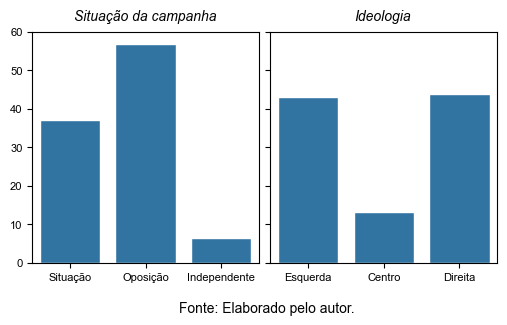

In [7]:
#| fig-cap: 'Distribuições das campanhas por ideologia e situação da campanha, em %'
#| label: fig-distideosit

dt = ofer1.copy()
dt.Orientacao = dt.Orientacao.replace([1.0, 2.0, 3.0], ['Esquerda', 'Centro', 'Direita'])
dt.Situacao_oposicao = dt.Situacao_oposicao.replace([1.0, 2.0, 3.0], ['Situação', 'Oposição', 'Independente'])

fig, axes = plt.subplots(1, 2, figsize=(6,3), sharey=True)

sns.set_theme(style="whitegrid")

sns.countplot(dt, x = 'Orientacao', stat='percent', order = ['Esquerda', 'Centro', 'Direita'], ax = axes[1])
axes[1].set(ylabel='', xlabel='')
axes[1].tick_params(labelsize=8)

# Title campaign situation

nota_de_rodape = plt.text(
    -2.15, 65.75,
    "Situação da campanha",
    va="top",
    ha='center',
    fontsize=10,
    style='italic',
    color="black", 
)

sns.countplot(dt, x = 'Situacao_oposicao', stat='percent', order = ['Situação', 'Oposição', 'Independente'], ax = axes[0])
axes[0].set(ylabel='', xlabel='', ylim=(0, 60))
axes[0].tick_params(labelsize=8)

# Title Ideology

nota_de_rodape = plt.text(
    0.98, 65.75,
    "Ideologia",
    va="top",
    ha='center',
    fontsize=10,
    style='italic',
    color="black", 
)

#  Footnote source

nota_de_rodape = plt.text(
    -0.55,  -10,
    "Fonte: Elaborado pelo autor.",
    ha="center", 
    va="top",  
    fontsize=10,  
    color="black", 
)

fig.subplots_adjust(wspace=0.05)

plt.show()

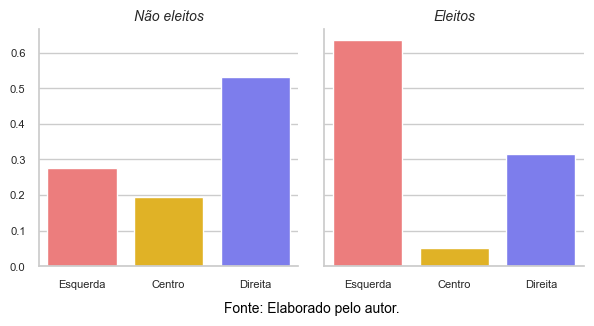

In [44]:
#| fig-cap: 'Distribuição das campanhas por situação e ideologia'
#| label: fig-distsitideo

a = dt.groupby(['Eleito'])['Orientacao'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.Eleito = a.Eleito.replace([0.0, 1.0], ['Não eleitos', 'Eleitos'])
#dt1 = a[a.Situacao_oposicao!=0.0]

cores = ['#6A6AFF','#FF6A6A', '#FFC107']
af = sns.catplot(a, x = 'level_1', y = 'Orientacao', col = 'Eleito', kind = 'bar', col_wrap=2, hue='level_1', legend=False,
                 order = ['Esquerda', 'Centro', 'Direita'], palette=cores)

af.set(xlabel=None, ylabel = None)
#sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.473, 0.45), fontsize=10)
af.set_titles("{col_name}", size = 10, style = 'italic')
af.fig.subplots_adjust(wspace=0.1, hspace=0.3)
af.fig.set_size_inches(6, 3)
af.tick_params(labelsize=8)

# footnote source 

nota_de_rodape = plt.text(
    -0.65,  -0.1,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black"
)

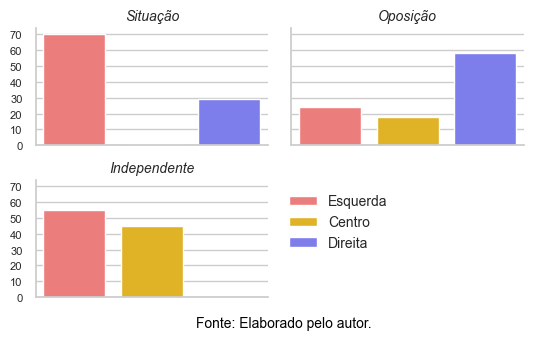

In [45]:
#| fig-cap: 'Distribuição das campanhas por situação e ideologia (%)'
#| label: fig-distsitideo

a = dt.groupby(['Situacao_oposicao'])['Orientacao'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
dt1 = a[a.Situacao_oposicao!=0.0]
dt1.Orientacao = dt1.Orientacao *100


cores = ['#FF6A6A', '#FFC107','#6A6AFF']
af = sns.catplot(dt1, x = 'level_1', y = 'Orientacao', col = 'Situacao_oposicao', kind = 'bar', col_wrap=2, hue='level_1', legend=True,
                col_order=['Situação', 'Oposição', 'Independente'], palette=cores)

af.set(xticklabels=[], xlabel=None, ylabel = None, yticks=range(0,80,10))
sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.47, 0.45), fontsize=10)
af.set_titles("{col_name}", size = 10, style = 'italic')
af.fig.subplots_adjust(wspace=0.1, hspace=0.3)
af.fig.set_size_inches(6, 3)
af.tick_params(labelsize=8)

# footnote source 

nota_de_rodape = plt.text(
    2.7,  -12,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black"
)

## Campaigns Main Themes

### Themes x countries

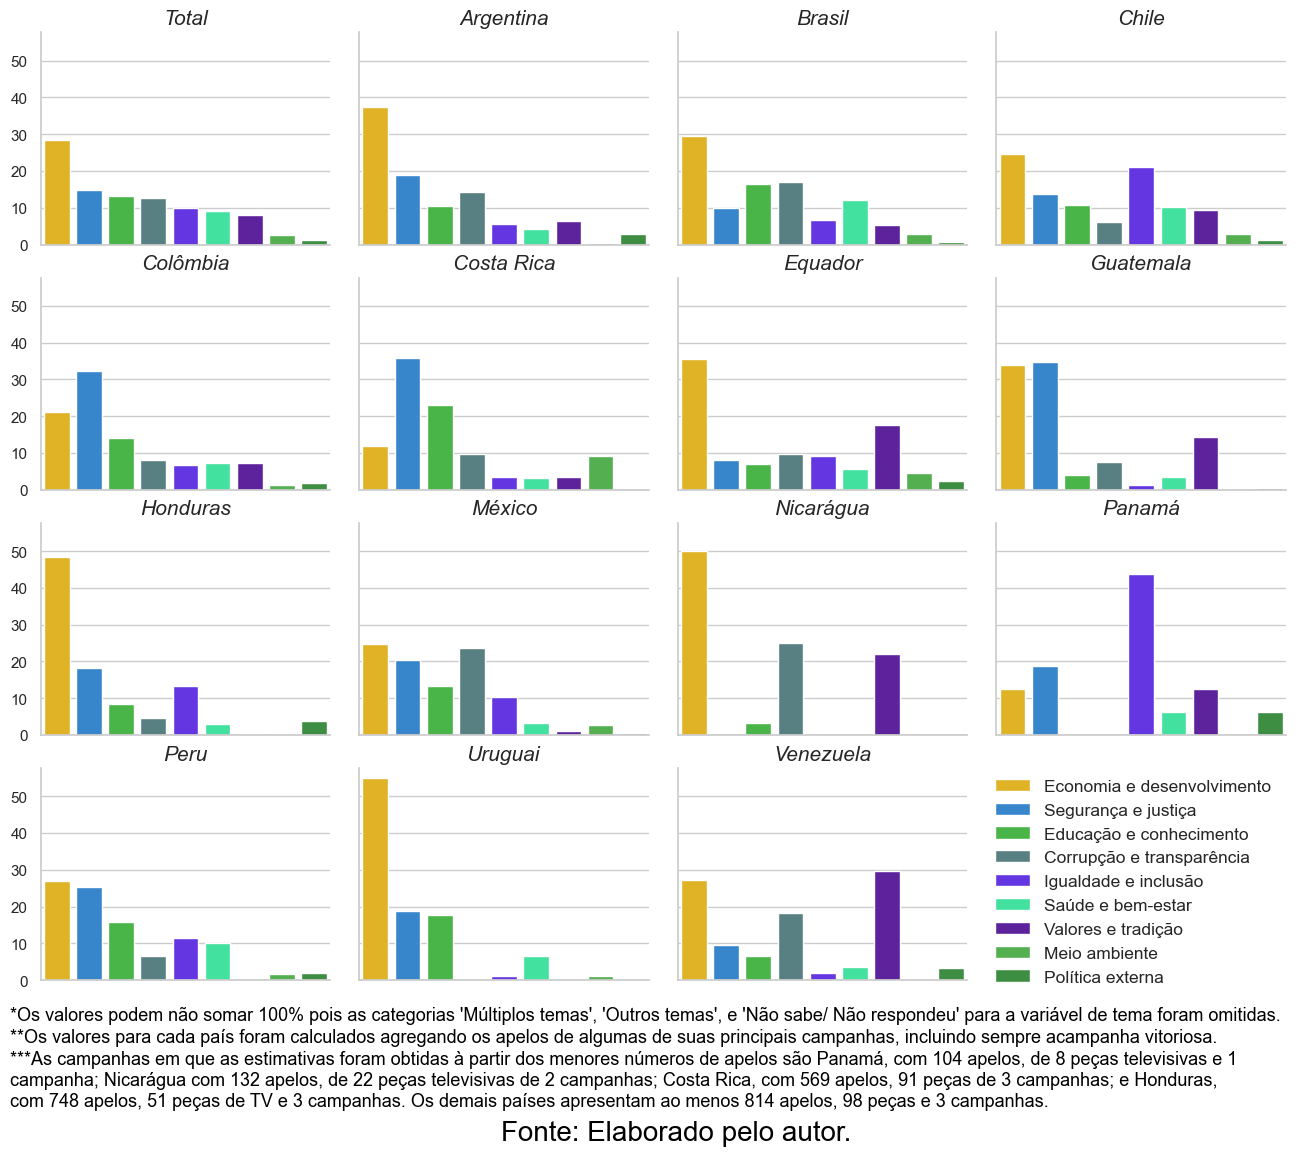

In [50]:
#| fig-cap: "Temática dos apelos ofertados pelas campanhas por país"
#| label: fig-ofertema

# Calculating categories percentage

ofermod = ofer.copy()
ofermod['temas_completo'] = ofermod['temas_completo'].cat.remove_categories(['0', '10'])
ofermod['temas_completo'] = ofermod.temas_completo.cat.rename_categories({'1':"Economia e desenvolvimento",
                                 '4':"Segurança e justiça",
                                 '2':"Corrupção e transparência",
                                 '8':"Educação e conhecimento",
                                 '3':"Saúde e bem-estar", 
                                 '5':"Política externa", 
                                 '6':"Igualdade e inclusão", 
                                 '9':"Meio ambiente",
                                 '7':"Valores e tradição"})

a = ofermod.groupby('pais')['temas_completo'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['pais', 'temas_completo', 'count']
b = ofermod['temas_completo'].value_counts()/ofermod['temas_completo'].value_counts().sum()
b = b.reset_index()
b['pais']='Total'

ab = pd.concat([a, b]).reset_index(drop=True)
ab['count'] = ab['count']*100


ls = list(ab.pais.unique())
ls.remove('Total')
ls.insert(0, 'Total')
sns.set_style('whitegrid')


af = sns.catplot(data=ab, x = 'temas_completo', y = 'count', hue = 'temas_completo', kind = 'bar', palette=cores_personalizadas,
                 col='pais', col_wrap=4, legend=True, col_order = ls, 
                 hue_order=["Economia e desenvolvimento", 
                            "Segurança e justiça", 
                            "Educação e conhecimento", 
                            "Corrupção e transparência",
                            "Igualdade e inclusão", 
                            "Saúde e bem-estar",
                            "Valores e tradição",
                            "Meio ambiente",
                            "Política externa"],
                 order=["Economia e desenvolvimento", 
                            "Segurança e justiça", 
                            "Educação e conhecimento", 
                            "Corrupção e transparência",
                            "Igualdade e inclusão", 
                            "Saúde e bem-estar",
                            "Valores e tradição",
                            "Meio ambiente",
                            "Política externa", 
                       ])

# footnote 

nota_de_rodape = plt.text(
    -21.25,  -7,
    "*Os valores podem não somar 100% pois as categorias 'Múltiplos temas', 'Outros temas', e 'Não sabe/ Não respondeu' para a variável"
    " de tema foram omitidas.",
    ha="left",
    va="top",    
    fontsize=13, 
    color="black"
)

# footnote 2

nota_de_rodape = plt.text(
    -21.25,  -13,
    "**Os valores para cada país foram calculados agregando os apelos de algumas de suas principais campanhas, incluindo sempre a" 
    "campanha vitoriosa.",
    ha="left",
    va="top",    
    fontsize=13, 
    color="black"
)


# footnote 3

nota_de_rodape = plt.text(
    -21.25,  -19,
    "***As campanhas em que as estimativas foram obtidas à partir dos menores números de apelos são Panamá, com 104 apelos, de 8 peças" 
    " televisivas e 1\ncampanha; Nicarágua com 132 apelos, de 22 peças televisivas de 2 campanhas; Costa Rica, com 569 apelos, 91 peças" 
    " de 3 campanhas; e Honduras,\ncom 748 apelos, 51 peças de TV e 3 campanhas. Os demais países apresentam ao menos 814 apelos, 98 "
    "peças e 3 campanhas.",
    ha="left",
    va="top",    
    fontsize=13, 
    color="black"
)

# footnote source 

nota_de_rodape = plt.text(
    -0.55,  -40,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=20, 
    color="black"
)

af.set(xticklabels=[], xlabel=None, ylabel = None, yticks=range(0, 60, 10))
sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.673, 0.25), fontsize=12.5)
af.set_titles("{col_name}", size = 15, style = 'italic')

af.fig.subplots_adjust(wspace=0.1)
af.fig.set_size_inches(15, 10)
af.tick_params(axis="x", labelsize=12)

plt.show()

### Themes x campaign situation

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_6711/2301994563.py:20: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  a.Situacao_oposicao = a.Situacao_oposicao.replace([1.0, 2.0, 3.0, 0.0], ['Situação',


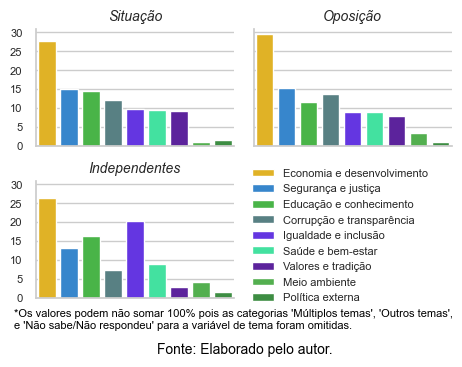

In [52]:
#| fig-cap: "Distribuição dos temas dos apelos por situação da campanha (%)"
#| label: fig-situofer

ofermod = ofer.copy()
ofermod['temas_completo'] = ofermod['temas_completo'].cat.remove_categories(['0', '10'])
ofermod['temas_completo'] = ofermod.temas_completo.cat.rename_categories({'1':"Economia e desenvolvimento",
                                 '4':"Segurança e justiça",
                                 '2':"Corrupção e transparência",
                                 '8':"Educação e conhecimento",
                                 '3':"Saúde e bem-estar", 
                                 '5':"Política externa", 
                                 '6':"Igualdade e inclusão", 
                                 '9':"Meio ambiente",
                                 '7':"Valores e tradição"})

a = ofermod.groupby(['Situacao_oposicao'])['temas_completo'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['Situacao_oposicao', 'tema', 'count']
a = a.astype({'Situacao_oposicao':'category'})

a.Situacao_oposicao = a.Situacao_oposicao.replace([1.0, 2.0, 3.0, 0.0], ['Situação', 
                                                                       'Oposição',
                                                                       'Independentes',
                                                                       None])
a['count'] = a['count']*100

cores_personalizadas = {
    "Economia e desenvolvimento": "#FFC107",  
    "Segurança e justiça": "#1E88E5",  
    "Educação e conhecimento": "#38C636",  
    "Corrupção e transparência": "#51868A",  
    "Igualdade e inclusão": "#571AFD", 
    "Saúde e bem-estar": "#29FBA4",
    "Valores e tradição": "#5B0FB0", 
    "Meio ambiente": "#44BF3F",
    "Política externa": "#309A38",
}
sns.set_theme(style="whitegrid", palette="pastel")

af = sns.catplot(data=a, x = 'tema', hue = 'tema', y = 'count', kind = 'bar', palette=cores_personalizadas, 
                 col='Situacao_oposicao', col_wrap=2, legend=True,
                 hue_order=["Economia e desenvolvimento", 
                            "Segurança e justiça", 
                            "Educação e conhecimento", 
                            "Corrupção e transparência",
                            "Igualdade e inclusão", 
                            "Saúde e bem-estar",
                            "Valores e tradição",
                            "Meio ambiente",
                            "Política externa"],
                order=["Economia e desenvolvimento", 
                            "Segurança e justiça", 
                            "Educação e conhecimento", 
                            "Corrupção e transparência",
                            "Igualdade e inclusão", 
                            "Saúde e bem-estar",
                            "Valores e tradição",
                            "Meio ambiente",
                            "Política externa", 
                       ])


# footnote 

nota_de_rodape = plt.text(
    -1.5,  -3,
    "*Os valores podem não somar 100% pois as categorias 'Múltiplos temas', 'Outros temas',\ne 'Não sabe/Não respondeu' para a "
    "variável de tema foram omitidas.",
    ha="left",
    va="top",    
    fontsize=8, 
    color="black"
)

# footnote source 

nota_de_rodape = plt.text(
    9,  -12,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black"
)


af.set(xticklabels=[], xlabel=None, ylabel = None, yticks=np.arange(0,35,5))
#af.set_yticks(range(0, 0.3, 0.05))
sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.437, 0.53), fontsize=8)
af.set_titles("{col_name}", size = 10, style = 'italic')
af.fig.subplots_adjust(wspace=0.1, hspace=0.3)
af.fig.set_size_inches(6, 3)

af.tick_params(labelsize=8)
plt.show()


### Themes x ideology

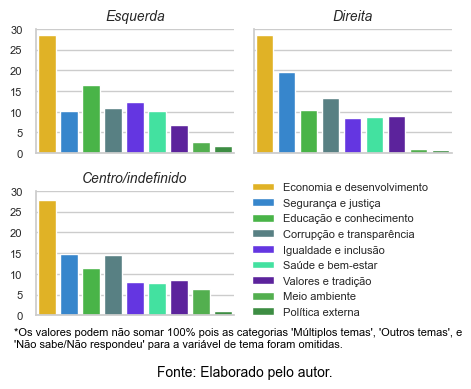

In [51]:
#| fig-cap: "Distribuição dos temas dos apelos por ideologia da campanha"
#| label: fig-posiofer

ofermod = ofer.copy()
ofermod['temas_completo'] = ofermod['temas_completo'].cat.remove_categories(['0', '10'])
ofermod['temas_completo'] = ofermod.temas_completo.cat.rename_categories({'1':"Economia e desenvolvimento",
                                 '4':"Segurança e justiça",
                                 '2':"Corrupção e transparência",
                                 '8':"Educação e conhecimento",
                                 '3':"Saúde e bem-estar", 
                                 '5':"Política externa", 
                                 '6':"Igualdade e inclusão", 
                                 '9':"Meio ambiente",
                                 '7':"Valores e tradição"})

a = ofermod.groupby(['Orientacao'])['temas_completo'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['Orientacao', 'tema', 'count']
a = a.astype({'Orientacao':'category'})

a['Orientacao'] = a.Orientacao.cat.rename_categories({1.0:"Esquerda",
                                 2.0:"Centro/indefinido",
                                 3.0:"Direita"})

a['count'] = a['count']*100

af = sns.catplot(data=a, x = 'tema', hue = 'tema', y = 'count', kind = 'bar', palette=cores_personalizadas, 
                 col='Orientacao', col_wrap=2, legend=True, col_order=['Esquerda', 'Direita', 'Centro/indefinido'],
                 hue_order=["Economia e desenvolvimento", 
                            "Segurança e justiça", 
                            "Educação e conhecimento", 
                            "Corrupção e transparência",
                            "Igualdade e inclusão", 
                            "Saúde e bem-estar",
                            "Valores e tradição",
                            "Meio ambiente",
                            "Política externa"],
                order=["Economia e desenvolvimento", 
                            "Segurança e justiça", 
                            "Educação e conhecimento", 
                            "Corrupção e transparência",
                            "Igualdade e inclusão", 
                            "Saúde e bem-estar",
                            "Valores e tradição",
                            "Meio ambiente",
                            "Política externa", 
                       ])

sns.set_theme(style="whitegrid", palette="pastel")

# footnote 

nota_de_rodape = plt.text(
    -1.5,  -3,
    "*Os valores podem não somar 100% pois as categorias 'Múltiplos temas', 'Outros temas', e\n'Não sabe/Não respondeu' para a "
    "variável de tema foram omitidas.",
    ha="left",
    va="top",    
    fontsize=8, 
    color="black"
)

# footnote source 

nota_de_rodape = plt.text(
    9,  -12,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black"
)


af.set(xticklabels=[], xlabel=None, ylabel = None, yticks=np.arange(0,35,5))
sns.move_legend(af, "upper left", title=None, bbox_to_anchor=(0.437, 0.512), fontsize=8)
af.set_titles("{col_name}", size = 10, style = 'italic')
af.fig.subplots_adjust(wspace=0.1, hspace=0.3)
af.fig.set_size_inches(6, 3.2)
af.tick_params(labelsize=8)


plt.show()


## Mobilization Degree

### Time Series

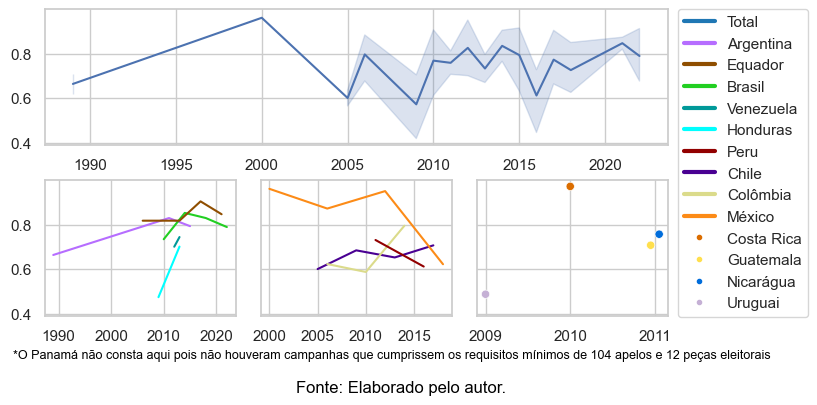

In [102]:
#| fig-cap: "Série temporal do apelos_ativos médio por país"
#| label: fig-apelos_ativosais

wei_grouped = ofestim.groupby(['pais', 'ano_eleicao'],  
                           observed= False).apply(lambda x: np.average(x['apelos_ativos']),
                           include_groups=False).reset_index()

wei_grouped.rename(columns={0:'apelos_ativos'}, inplace = True)


apel_temp = wei_grouped

apel_temp1 = apel_temp[(apel_temp['pais']=='Peru') | (apel_temp['pais']== 'Chile') |
                       (apel_temp['pais']=='Colômbia') | (apel_temp['pais']=='México')]


apel_temp2 = apel_temp[(apel_temp['pais']=='Honduras') | (apel_temp['pais']=='Brasil') | (apel_temp['pais']== 'Equador') |
                       (apel_temp['pais']=='Argentina') | (apel_temp['pais']=='Venezuela')]


apel_temp3 = apel_temp[(apel_temp['pais']=='Costa Rica') | (apel_temp['pais']=='Guatemala') | (apel_temp['pais']== 'Nicarágua') |
                       (apel_temp['pais']=='Panamá') | (apel_temp['pais']=='Uruguai')]

#Adding Jitter to scatterplot

apel_temp3 = apel_temp3.astype({'ano_eleicao':'float'})
apel_temp3.loc[(apel_temp3['pais'] == 'Nicarágua') & (apel_temp3['ano_eleicao'] == 2011), 'ano_eleicao'] += 0.05
apel_temp3.loc[(apel_temp3['pais'] == 'Guatemala') & (apel_temp3['ano_eleicao'] == 2011), 'ano_eleicao'] -= 0.05

#Setting countries names and colors

pline = [
    'Argentina',
    'Equador',
    'Brasil',
    'Venezuela',
    'Honduras',
    'Peru',
    'Chile',    
    'Colômbia',
    'México',
]


corline = [
    '#b66dff',
    '#8f4e00',  
    '#22cf22', 
    '#009999', 
    '#00FFFF',  
    '#920000', 
    '#490092',  
    '#dbdb8b',  
    '#fc8b17', 
]

pal1 = {'México': '#fc8b17', 'Colômbia':'#dbdb8b', 'Chile':'#490092', 'Peru':'#920000'}
pal2 = {'Argentina':'#b66dff', 'Equador':'#8f4e00', 'Brasil':'#22cf22', 'Honduras':'#00FFFF', 'Venezuela':'#009999'}


pdot = [
    'Costa Rica',
    'Guatemala',
    'Nicarágua',
    'Uruguai'
]

cordot = [
    '#db6d00',  
    '#ffdf4d',  
    '#006ddb', 
    '#c5b0d5',  
]

pal3 ={}
for pais, cor in zip(pdot, cordot):
    pal3[pais]=cor

sns.set_theme(style="whitegrid")


fig, axes = plt.subplot_mosaic([['a', 'a', 'a'], ['b', 'c', 'd']],
                              layout='compressed', sharey=True, figsize=(6.7,3.421))

av = sns.lineplot(ofestim, x = 'ano_eleicao', y = 'apelos_ativos', ax=axes['a'])

av1 = sns.lineplot(data=apel_temp1, x="ano_eleicao", y="apelos_ativos", hue='pais', palette=pal1, errorbar = None, ax=axes['c'],
                   legend=False
)
    
av2 = sns.lineplot(
    data=apel_temp2, x="ano_eleicao", y="apelos_ativos", hue='pais', palette=pal2, errorbar = None, ax=axes['b'], legend=False
)


av3 = sns.scatterplot(
    data=apel_temp3, x="ano_eleicao", y="apelos_ativos", hue='pais', palette=pal3, legend=False, ax=axes['d']
)

# Removing unnecessary labels

axes['a'].set_xlabel('')
axes['a'].set_ylabel('')
axes['b'].set_xlabel('')
axes['b'].set_ylabel('')
axes['c'].set_xlabel('')
axes['d'].set_xlabel('')

#Creating legend

#Set legend icons and categories
total = [mlines.Line2D([0], [0], color='#1f77b4', linewidth=3, label = 'Total')]
lines = [mlines.Line2D([0], [0], color=corline, linewidth=3, label = pline) for corline, pline in zip(corline, pline)]
dots = [mlines.Line2D([0], [0], label= p, marker='.', linestyle='', color = c) for c, p in zip(cordot, pdot)]
handles = total + lines + dots
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.1, 1.01))
    
# footnote 

nota_de_rodape = fig.text(0.01,  -0.04,
    "*O Panamá não consta aqui pois não houveram campanhas que cumprissem os requisitos mínimos de 104 apelos e 12 peças eleitorais", 
    ha="left",
    va="bottom",  
    fontsize=9, 
    color="black"
)
# footnote source 

nota_de_rodape = fig.text(
    0.59,  -0.14,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
#    fontsize=25, 
    color="black"
)
plt.show()

### Categorical Variables

#### Elected x non elected - no association

P-value Elected x Non Elected: 0.504


/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1698/2018615321.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofestim[['apelos_ativos', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


std_corr      mean    median   N
Eleito                                  
0.0     0.171902  0.743231  0.750000  57
1.0     0.164614  0.768862  0.805102  30

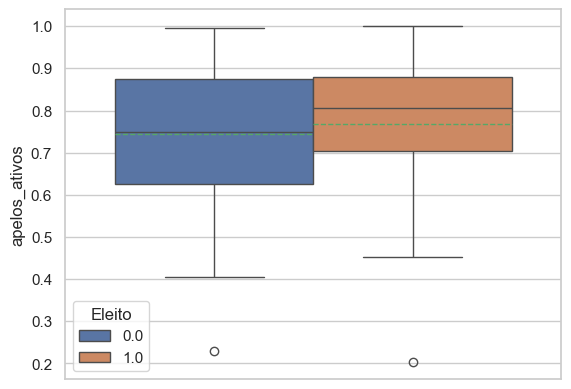

In [70]:
sns.boxplot(data=ofestim, y="apelos_ativos", showmeans=True, meanline = True, hue='Eleito', notch = False)

a = ofestim[['apelos_ativos', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=57,
                     mean2=med_2, std2=std_2, nobs2=30)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Elected x Non Elected: {c[1].round(3)}')
a

#### Ideology and MD - No association

In [72]:
# Weighted appeals

a = ofestim[['apelos_ativos', 'Orientacao']].groupby('Orientacao').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
med_3 = a.iloc[2,1]

b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
                     mean2=med_2, std2=std_2, nobs2=17)
d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Right Wing x Center: {b[1].round(3)}', f'P-value Left Wing x Center: {c[1].round(3)}', 
      f'P-value Left Wing x Right Wing: {d[1].round(3)}')
a

P-value Right Wing x Center: 0.151 P-value Left Wing x Center: 0.788 P-value Left Wing x Right Wing: 0.125


std_corr      mean    median   N
Orientacao                                  
1.0         0.149577  0.777065  0.809405  32
2.0         0.162134  0.789546  0.778846  17
3.0         0.183154  0.714254  0.738790  38

#### Oposition, Situation and Independents and AD - No association

In [69]:

# Weighted appeals

a = ofestim[['apelos_ativos', 'Situacao_oposicao']].groupby('Situacao_oposicao').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
med_3 = a.iloc[2,1]

b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=8,
                     mean2=med_2, std2=std_2, nobs2=54)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=25,
                     mean2=med_2, std2=std_2, nobs2=54)
d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=25,
                     mean2=med_3, std2=std_3, nobs2=8)

print(f'P-value Independents x Oposition: {b[1].round(3)}', f'P-value Situation x Oposition: {c[1].round(3)}', 
      f'P-value Situation x Independents: {d[1].round(3)}')
a

P-value Independents x Oposition: 0.075 P-value Situation x Oposition: 0.099 P-value Situation x Independents: 0.345


std_corr      mean    median   N
Situacao_oposicao                                  
1.0                0.137081  0.789462  0.825359  25
2.0                0.181060  0.721420  0.733477  54
3.0                0.127925  0.842098  0.835950   8

#### Incumbency and AD - No Association

In [67]:
# Weighted appeals

a = ofestim[['apelos_ativos', 'Incumbente']].groupby('Incumbente').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=83,
                     mean2=med_2, std2=std_2, nobs2=7)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Incumbents x Non-incumbents: {c[1].round(3)}')
a

P-value Incumbents x Non-incumbents: 0.808


std_corr      mean    median   N
Incumbente                                  
0.0         0.174697  0.750757  0.753781  80
1.0         0.082489  0.767071  0.769912   7

#### Candidacy Social Status and AD - No association

In [732]:
# Weighted appeals

a = ofestim[['apelos_ativos', 'Candidato_minoria']].groupby('Candidato_minoria').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=67,
                     mean2=med_2, std2=std_2, nobs2=23)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Social minority x Non social minority: {c[1].round(3)}')
a

P-value Social minority x Non social minority: 0.868


std_corr      mean    median   N
Candidato_minoria                                  
0.0                0.173623  0.752141  0.755776  67
1.0                0.151754  0.758905  0.754425  23

#### Degree of Polarization and AD - No association

In [734]:
# Weighted appeals

a = ofestim[['apelos_ativos', 'polariz']].groupby('polariz').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=56,
                     mean2=med_2, std2=std_2, nobs2=34)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Polarized x Non polarized: {c[1].round(3)}')
a

P-value Polarized x Non polarized: 0.083


std_corr      mean    median   N
polariz                                  
0        0.175922  0.730041  0.739529  56
1        0.146748  0.793118  0.827225  34

#### 1 and 2 turns elections - No association

In [239]:

a = ofestim[['apelos_ativos', 'eleicao_2turnos']].groupby('eleicao_2turnos').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=28,
                     mean2=med_2, std2=std_2, nobs2=62)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value 2 turn campaigns x non 2 turn: {c[1].round(3)}')
a

P-value 2 turn campaigns x non 2 turn: 0.596


std_corr      mean    median   N
eleicao_2turnos                                  
0.0              0.169146  0.767899  0.763334  28
1.0              0.167749  0.747534  0.753781  62

#### Elected - No association

In [240]:
a = ofestim[['apelos_ativos', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=60,
                     mean2=med_2, std2=std_2, nobs2=30)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value 2 turn campaigns x non 2 turn: {c[1].round(3)}')
a

P-value 2 turn campaigns x non 2 turn: 0.551


std_corr      mean    median   N
Eleito                                  
0.0     0.169798  0.746374  0.750000  60
1.0     0.164614  0.768862  0.805102  30

### Quantitative Variables

#### Votes 1st turn - No association

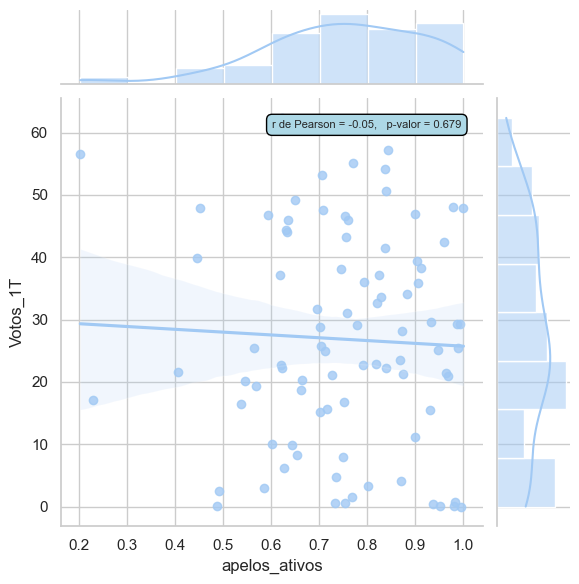

In [274]:


sns.jointplot(ofestim, y = 'Votos_1T', x = 'apelos_ativos', kind='reg')


#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim["Votos_1T"], ofestim["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("apelos_ativos")
plt.ylabel("Votos_1T")

# Mostre o gráfico
plt.show()



#### Economic situation/GDP Variation - no association

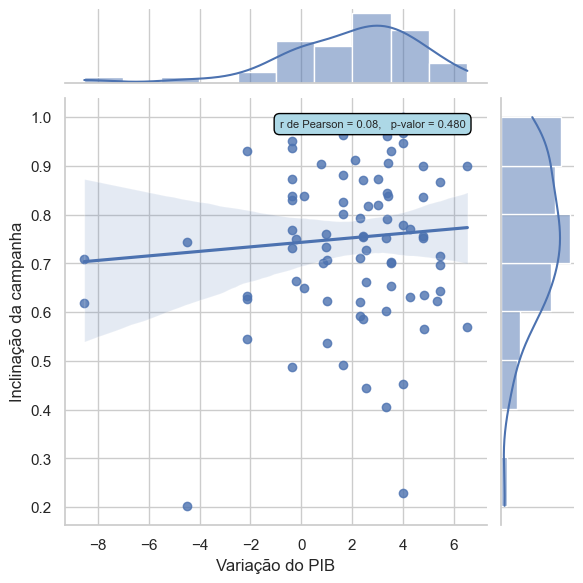

In [181]:

a = ofestim.copy()
sns.jointplot(a, y = 'apelos_ativos', x = 'var_anual_PIBpercapita', kind='reg')

ofestim1 = a.dropna(subset = 'var_anual_PIBpercapita')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["var_anual_PIBpercapita"], ofestim1["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Variação do PIB")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


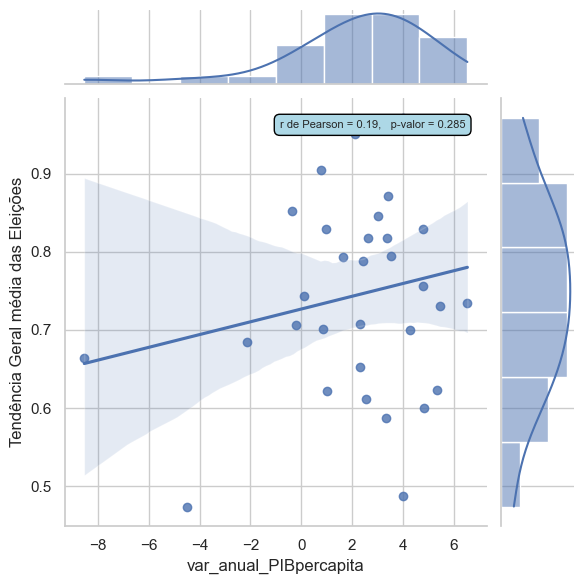

In [182]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'var_anual_PIBpercapita']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['apelos_ativos'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'apelos_ativos', x = 'var_anual_PIBpercapita', kind='reg')

ofestim1 = c.dropna(subset = 'var_anual_PIBpercapita')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["var_anual_PIBpercapita"], ofestim1["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("var_anual_PIBpercapita")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

#### Inflation - no associaton

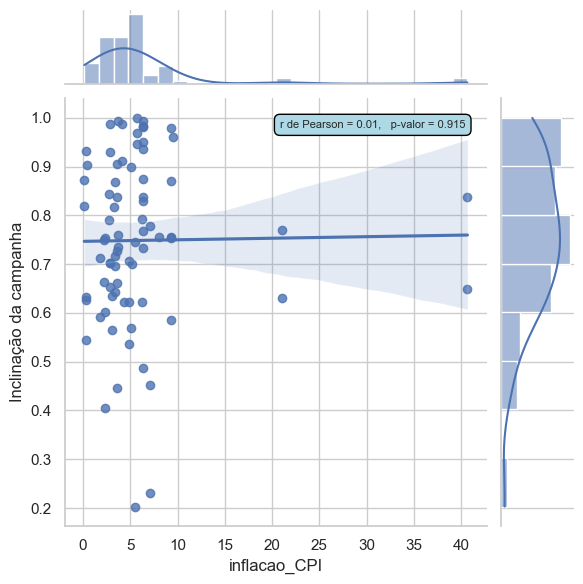

In [183]:

a = ofestim.copy()
sns.jointplot(a, y = 'apelos_ativos', x = 'inflacao_CPI', kind='reg')

ofestim1 = a.dropna(subset = 'inflacao_CPI')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["inflacao_CPI"], ofestim1["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("inflacao_CPI")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


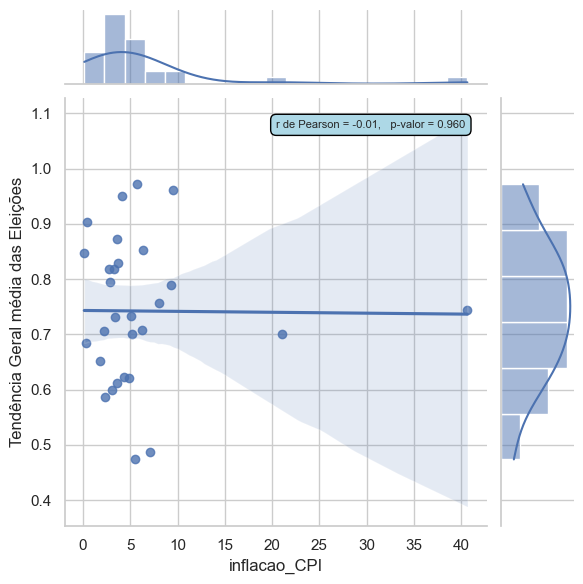

In [184]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'inflacao_CPI']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['apelos_ativos'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'apelos_ativos', x = 'inflacao_CPI', kind='reg')

ofestim1 = c.dropna(subset = 'inflacao_CPI')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["inflacao_CPI"], ofestim1["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("inflacao_CPI")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

#### Unemployment - no association

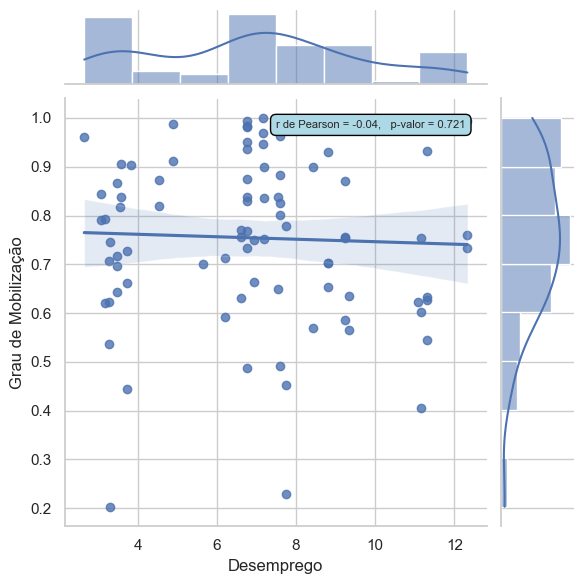

In [187]:

a = ofestim.copy()
sns.jointplot(a, y = 'apelos_ativos', x = 'desemprego', kind='reg')

ofestim1 = a.dropna(subset = 'desemprego')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["desemprego"], ofestim1["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Desemprego")
plt.ylabel("Grau de Mobilização")

# Mostre o gráfico
plt.show()


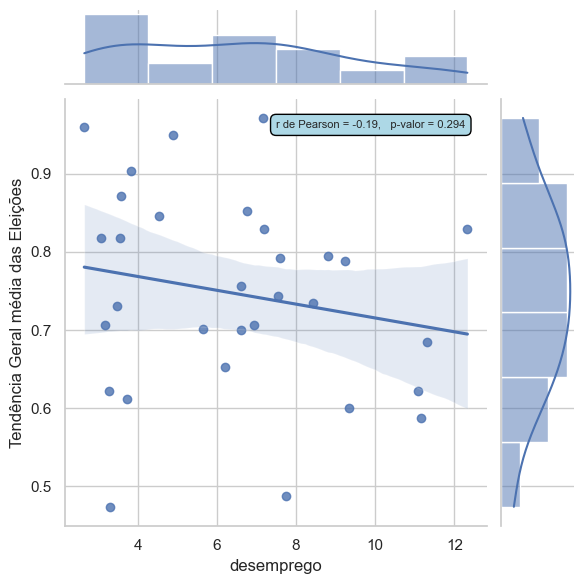

In [186]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'desemprego']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['apelos_ativos'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'apelos_ativos', x = 'desemprego', kind='reg')

ofestim1 = c.dropna(subset = 'desemprego')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["desemprego"], ofestim1["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("desemprego")
plt.ylabel("Grau de Mobilização")

# Mostre o gráfico
plt.show()

## Type of Appeals - IMP

### Time series

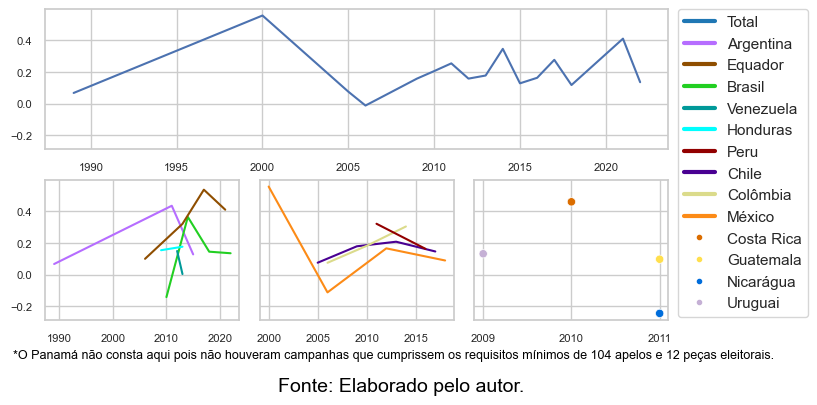

In [599]:
#| fig-cap: "Série temporal do IMP médio por país"
#| label: fig-impais

wei_grouped = ofestim.groupby(['pais', 'ano_eleicao'],  
                           observed= False).apply(lambda x: np.average(x['IMP']),
                           include_groups=False).reset_index()

wei_grouped.rename(columns={0:'IMP'}, inplace = True)


apel_temp = wei_grouped

apel_temp1 = apel_temp[(apel_temp['pais']=='Peru') | (apel_temp['pais']== 'Chile') |
                       (apel_temp['pais']=='Colômbia') | (apel_temp['pais']=='México')]


apel_temp2 = apel_temp[(apel_temp['pais']=='Honduras') | (apel_temp['pais']=='Brasil') | (apel_temp['pais']== 'Equador') |
                       (apel_temp['pais']=='Argentina') | (apel_temp['pais']=='Venezuela')]


apel_temp3 = apel_temp[(apel_temp['pais']=='Costa Rica') | (apel_temp['pais']=='Guatemala') | (apel_temp['pais']== 'Nicarágua') |
                       (apel_temp['pais']=='Panamá') | (apel_temp['pais']=='Uruguai')]

#Setting countries names and colors

pline = [
    'Argentina',
    'Equador',
    'Brasil',
    'Venezuela',
    'Honduras',
    'Peru',
    'Chile',    
    'Colômbia',
    'México',
]


corline = [
    '#b66dff',
    '#8f4e00',  
    '#22cf22', 
    '#009999', 
    '#00FFFF',  
    '#920000', 
    '#490092',  
    '#dbdb8b',  
    '#fc8b17', 
]

pal1 = {'México': '#fc8b17', 'Colômbia':'#dbdb8b', 'Chile':'#490092', 'Peru':'#920000'}
pal2 = {'Argentina':'#b66dff', 'Equador':'#8f4e00', 'Brasil':'#22cf22', 'Honduras':'#00FFFF', 'Venezuela':'#009999'}


pdot = [
    'Costa Rica',
    'Guatemala',
    'Nicarágua',
    'Uruguai'
]

cordot = [
    '#db6d00',  
    '#ffdf4d',  
    '#006ddb', 
    '#c5b0d5',  
]

pal3 ={}
for pais, cor in zip(pdot, cordot):
    pal3[pais]=cor

sns.set_theme(style="whitegrid")


fig, axes = plt.subplot_mosaic([['a', 'a', 'a'], ['b', 'c', 'd']],
                              layout='compressed', sharey=True, figsize=(6.7,3.421))

av = sns.lineplot(ofestim, x = 'ano_eleicao', y = 'IMP', ax=axes['a'], errorbar=None)

av1 = sns.lineplot(data=apel_temp1, x="ano_eleicao", y="IMP", hue='pais', palette=pal1, errorbar = None, ax=axes['c'],
                   legend=False
)
    
av2 = sns.lineplot(
    data=apel_temp2, x="ano_eleicao", y="IMP", hue='pais', palette=pal2, errorbar = None, ax=axes['b'], legend=False
)


av3 = sns.scatterplot(
    data=apel_temp3, x="ano_eleicao", y="IMP", hue='pais', palette=pal3, legend=False, ax=axes['d']
)

# Removing unnecessary labels

axes['a'].set_xlabel('')
axes['a'].set_ylabel('')
axes['a'].tick_params(labelsize=8)
axes['b'].set_xlabel('')
axes['b'].set_ylabel('')
axes['b'].tick_params(labelsize=8)
axes['c'].set_xlabel('')
axes['c'].tick_params(labelsize=8)
axes['d'].set_xlabel('')
axes['d'].set_xticks([2009, 2010, 2011])
axes['d'].tick_params(labelsize=8)

#Creating legend

#Set legend icons and categories
total = [mlines.Line2D([0], [0], color='#1f77b4', linewidth=3, label = 'Total')]
lines = [mlines.Line2D([0], [0], color=corline, linewidth=3, label = pline) for corline, pline in zip(corline, pline)]
dots = [mlines.Line2D([0], [0], label= p, marker='.', linestyle='', color = c) for c, p in zip(cordot, pdot)]
handles = total + lines + dots
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.1, 1.01))
    
# footnote 

nota_de_rodape = fig.text(0.01,  -0.04,
    "*O Panamá não consta aqui pois não houveram campanhas que cumprissem os requisitos mínimos de 104 apelos e 12 peças eleitorais.", 
    ha="left",
    va="bottom",  
    fontsize=9, 
    color="black"
)
# footnote source 

nota_de_rodape = fig.text(
    0.59,  -0.14,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
    fontsize=14, 
    color="black"
)
plt.show()

### Categorical variables

#### Elected x No elected IMP - No association

P-value Elected x Non Elected: 0.504


/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1698/2726515188.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofestim[['apelos_ativos', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


std_corr      mean    median   N
Eleito                                  
0.0     0.171902  0.743231  0.750000  57
1.0     0.164614  0.768862  0.805102  30

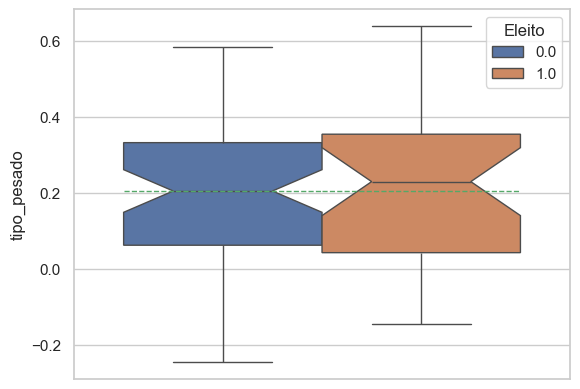

In [87]:
sns.boxplot(data=ofestim, y="IMP", showmeans=True, meanline = True, hue='Eleito', notch = True)

a = ofestim[['apelos_ativos', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=57,
                     mean2=med_2, std2=std_2, nobs2=30)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Elected x Non Elected: {c[1].round(3)}')
a

#### Ideology and Situation of campaign

##### Ideology - Right wing candidates significantly less materialistic

##### Oposition, situation and independents - No association

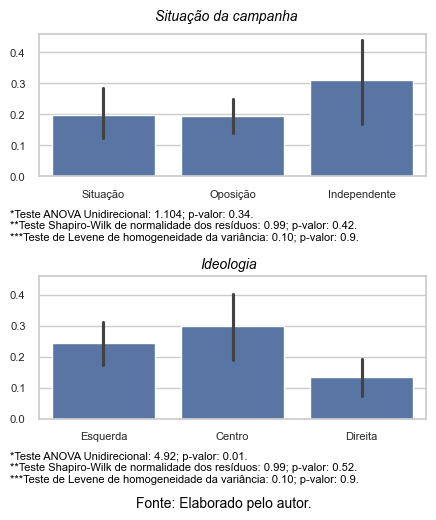

In [56]:
#| fig-cap: 'Média dos IMPs por ideologia e situação das campanhas'
#| label: fig-impideosit

# Calculatin One way ANOVA for Ideology

fori, pori = stats.f_oneway(ofestim['IMP'][ofestim['Orientacao'] == 'Esquerda'],
               ofestim['IMP'][ofestim['Orientacao'] == 'Centro'],
               ofestim['IMP'][ofestim['Orientacao'] == 'Direita'])

# Calculating Levene test
leori, pleori = stats.levene(ofestim['IMP'][ofestim['Orientacao'] == 'Esquerda'],
               ofestim['IMP'][ofestim['Orientacao'] == 'Centro'],
               ofestim['IMP'][ofestim['Orientacao'] == 'Direita'], center='mean')

# Shapiro-Wilk test
model = ols('IMP ~ C(Orientacao)', data=ofestim).fit()
tshap, pshap = stats.shapiro(model.resid)

# Calculating One-Way ANOVA for Campaign Situation 

fsitu, psitu = stats.f_oneway(ofestim['IMP'][ofestim['Situacao_oposicao'] == 'Situação'],
               ofestim['IMP'][ofestim['Situacao_oposicao'] == 'Oposição'],
               ofestim['IMP'][ofestim['Situacao_oposicao'] == 'Independente'])

# Calculating Levene test

lesit, plesit = stats.levene(ofestim['IMP'][ofestim['Situacao_oposicao'] == 'Situação'],
               ofestim['IMP'][ofestim['Situacao_oposicao'] == 'Oposição'],
               ofestim['IMP'][ofestim['Situacao_oposicao'] == 'Independente'], center='mean')

# Shapiro-Wilk test

model = ols('IMP ~ C(Situacao_oposicao)', data=ofestim).fit()
tshapsit, pshapsit = stats.shapiro(model.resid)

sns.set_theme(style='whitegrid')
af, axes = plt.subplots(2, 1, sharey = True, figsize = (5,5))

ori = sns.barplot(ofestim, x = 'Orientacao', y = 'IMP', order = ['Esquerda', 'Centro', 'Direita'], ax=axes[1])
axes[1].tick_params(labelsize=8)

# Footnote test results Ideology

nota_de_rodape = plt.text(
    -0.72, -0.105,
    f"*Teste ANOVA Unidirecional: {fori.round(3)}; p-valor: {pori.round(2)}.\n**Teste Shapiro-Wilk de normalidade"
    f" dos resíduos: {tshap:.2f}; p-valor: {round(pshap, 2)}.\n***Teste de Levene de homogeneidade da variância: {leori:.2f}; "
    f"p-valor: {pleori.round(2)}.",
    va="top",  
    fontsize=8,  
    color="black",  
)

# Title ideology

nota_de_rodape = plt.text(
    0.75, 0.52,
    "Ideologia",
    va="top",  
    ha='left',
    fontsize=10,
    style='italic',
    color="black", 
)

ori.set(xlabel='', ylabel = '')

sit = sns.barplot(ofestim, x = 'Situacao_oposicao', y = 'IMP', ax=axes[0], order = ['Situação', 'Oposição', 'Independente'])
axes[0].tick_params(labelsize=8)

# Footnote test results campaign situation

nota_de_rodape = plt.text(
    -0.72,  0.677,
    f"*Teste ANOVA Unidirecional: {fsitu.round(3)}; p-valor: {psitu.round(2)}.\n**Teste Shapiro-Wilk de normalidade"
    f" dos resíduos: {tshapsit:.2f}; p-valor: {round(pshapsit, 2)}.\n***Teste de Levene de homogeneidade da variância: {lesit:.2f}; "
    f"p-valor: {plesit.round(2)}.",
    ha="left", 
    va="top",  
    fontsize=8,  
    color="black", 
)

# Title campaign situation

nota_de_rodape = plt.text(
    0.4, 1.321,
    "Situação da campanha",
    va="top",
    ha='left',
    fontsize=10,
    style='italic',
    color="black", 
)

# footnote source

nota_de_rodape = plt.text(
    0.25,  -0.25,
    "Fonte: Elaborado pelo autor.",
    ha="left", 
    va="top",  
    fontsize=10,  
    color="black", 
)

sit.set(xlabel='', ylabel='')
af.subplots_adjust(hspace=0.7)

plt.show()

# Tukey's range test (p-adjusted value Center x Right wing = 0.02)

comp = mc.MultiComparison(ofestim['IMP'], ofestim['Orientacao'])
post_hoc_res = comp.tukeyhsd()
#post_hoc_res.summary()

#### Incumbency - No association

In [91]:
# Weighted appeals

a = ofestim[['IMP', 'Incumbente']].groupby('Incumbente').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=80,
                     mean2=med_2, std2=std_2, nobs2=7)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Incumbents x Non-incumbents: {c[1].round(3)}')
a

P-value Incumbents x Non-incumbents: 0.759


std_corr      mean    median     N
Incumbente                                    
0.0         0.215638  0.203956  0.207297  80.0
1.0         0.126735  0.229465  0.211215   7.0

#### Candidacy social status - No association

In [93]:
# Weighted appeals

a = ofestim[['IMP', 'Candidato_minoria']].groupby('Candidato_minoria').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=65,
                     mean2=med_2, std2=std_2, nobs2=22)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Social minority x Non social minority: {c[1].round(3)}')
a

P-value Social minority x Non social minority: 0.757


std_corr      mean    median     N
Candidato_minoria                                    
0.0                0.209285  0.210083  0.209184  65.0
1.0                0.214539   0.19397  0.218688  22.0

#### Degree of Electoral Polarization - No association

In [95]:
# Weighted appeals

a = ofestim[['IMP', 'polariz']].groupby('polariz').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=50,
                     mean2=med_2, std2=std_2, nobs2=37)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Polarized x Non polarized: {c[1].round(3)}')
a

P-value Polarized x Non polarized: 0.663


std_corr      mean    median     N
polariz                                    
0        0.200667  0.217343  0.241668  37.0
1        0.217413  0.197621  0.200895  50.0

#### Elected - No association

In [96]:
a = ofestim[['IMP', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1698/299278071.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofestim[['tipo_pesado', 'Eleito']].groupby('Eleito').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


std_corr      mean   median     N
Eleito                                   
0.0     0.206978  0.206345  0.20541  57.0
1.0     0.217747  0.205369  0.23005  30.0

In [97]:
std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=57,
                     mean2=med_2, std2=std_2, nobs2=30)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Elected x Non Elected: {c[1].round(3)}')
a

P-value Elected x Non Elected: 0.984


std_corr      mean   median     N
Eleito                                   
0.0     0.206978  0.206345  0.20541  57.0
1.0     0.217747  0.205369  0.23005  30.0

#### 2 turn candidates - No association

In [99]:
a = ofestim[['IMP', 'eleicao_2turnos']].groupby('eleicao_2turnos').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=27,
                     mean2=med_2, std2=std_2, nobs2=60)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value 2 turn campaigns x non 2 turn: {c[1].round(3)}')
a

P-value 2 turn campaigns x non 2 turn: 0.54


std_corr      mean    median     N
eleicao_2turnos                                    
0.0              0.240368  0.185318  0.176078  27.0
1.0              0.195504  0.215319  0.249507  60.0

#### Emotions - Emotional appeals tend to be more materialistic

##### General appeals

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/3918417793.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ofer2.emocao_apelo = ofer2.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/3918417793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ofer2.emocao_apelo = ofer2.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/3918417793.p

P-value Nenhum sentimento x Calma: 0.0 P-value Calma x Entusiasmo: 1.8760493936818796e-21 P-value Nenhum Preocupação x Calma: 0.0 P-value Preocupação x Tristeza: 0.191


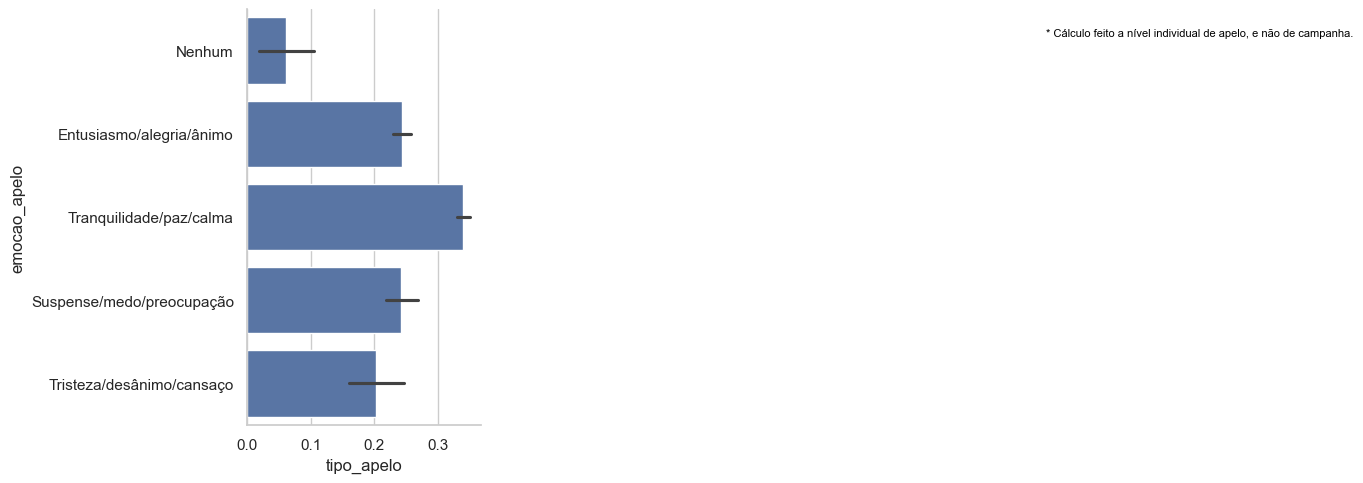

In [43]:
ofer2 = ofer1[ofer1.tipo_apelo!=99]

ofer2.emocao_apelo = ofer2.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
                                                            'Tranquilidade/paz/calma', 
                                                            'Suspense/medo/preocupação',
                                                            'Tristeza/desânimo/cansaço',
                                                            'Nenhum'])

# Weighted appeals

a = ofer2.groupby('emocao_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']

std_0 = a.iloc[0,0]
std_1 = a.iloc[1,0]
std_2 = a.iloc[2,0]
std_3 = a.iloc[3,0]
std_4 = a.iloc[4,0]
med_0 = a.iloc[0,1]
med_1 = a.iloc[1,1]
med_2 = a.iloc[2,1]
med_3 = a.iloc[3,1]
med_4 = a.iloc[4,1]


t01, p01 = stats.ttest_ind_from_stats(mean1=med_0, std1=std_0, nobs1=984,
                     mean2=med_1, std2=std_1, nobs2=9977)
t12, p12 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=9977,
                     mean2=med_2, std2=std_2, nobs2=18725)
t23, p23 = stats.ttest_ind_from_stats(mean1=med_2, std1=std_2, nobs1=18725,
                     mean2=med_3, std2=std_3, nobs2=3255)
t34, p34 = stats.ttest_ind_from_stats(mean1=med_4, std1=std_4, nobs1=1028,
                     mean2=med_3, std2=std_3, nobs2=3255)

print(f'P-value Nenhum sentimento x Calma: {p01.round(3)}', f'P-value Calma x Entusiasmo: {p12}', 
      f'P-value Nenhum Preocupação x Calma: {p23.round(3)}', f'P-value Preocupação x Tristeza: {p34.round(3)}')

sns.catplot(ofer2, x = 'tipo_apelo', y = 'emocao_apelo', kind = 'bar')
nota_de_rodape = plt.text(
    1.5,  # Posição X da nota de rodapé
    -0.15,  # Posição Y da nota de rodapé
    f"* Cálculo feito a nível individual de apelo, e não de campanha.",  # Conteúdo da nota de rodapé
    ha="center",  # Alinhamento horizontal
    va="bottom",  # Alinhamento vertical
    fontsize=8,  # Tamanho da fonte
    color="black",  # Cor da fonte
)

##### Material appeals

In [47]:
av = ofer3.groupby('emocao_apelo')['tipo_apelo'].agg('mean')
av

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/864095992.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  av = ofer3.groupby('emocao_apelo')['tipo_apelo'].agg('mean')


emocao_apelo
Nenhum                       1.0
Entusiasmo/alegria/ânimo     1.0
Tranquilidade/paz/calma      1.0
Suspense/medo/preocupação    1.0
Tristeza/desânimo/cansaço    1.0
Name: tipo_apelo, dtype: Float64

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/2399933409.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofer3.groupby('emocao_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


P-value Nenhum sentimento x Calma: nan P-value Calma x Entusiasmo: nan P-value Nenhum Preocupação x Calma: nan P-value Preocupação x Tristeza: nan


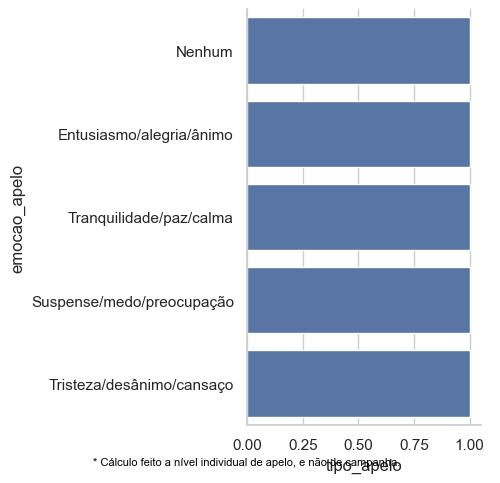

In [48]:

ofer3 = ofer2[ofer2.tipo_apelo>0]

# Weighted appeals

a = ofer3.groupby('emocao_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']

std_0 = a.iloc[0,0]
std_1 = a.iloc[1,0]
std_2 = a.iloc[2,0]
std_3 = a.iloc[3,0]
std_4 = a.iloc[4,0]
med_0 = a.iloc[0,1]
med_1 = a.iloc[1,1]
med_2 = a.iloc[2,1]
med_3 = a.iloc[3,1]
med_4 = a.iloc[4,1]


t01, p01 = stats.ttest_ind_from_stats(mean1=med_0, std1=std_0, nobs1=984,
                     mean2=med_1, std2=std_1, nobs2=9977)
t12, p12 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=9977,
                     mean2=med_2, std2=std_2, nobs2=18725)
t23, p23 = stats.ttest_ind_from_stats(mean1=med_2, std1=std_2, nobs1=18725,
                     mean2=med_3, std2=std_3, nobs2=3255)
t34, p34 = stats.ttest_ind_from_stats(mean1=med_4, std1=std_4, nobs1=1028,
                     mean2=med_3, std2=std_3, nobs2=3255)

print(f'P-value Nenhum sentimento x Calma: {p01.round(3)}', f'P-value Calma x Entusiasmo: {p12}', 
      f'P-value Nenhum Preocupação x Calma: {p23.round(3)}', f'P-value Preocupação x Tristeza: {p34.round(3)}')


saf = sns.catplot(ofer3, x = 'tipo_apelo', y = 'emocao_apelo', kind = 'bar')
nota_de_rodape = plt.text(
    0,  # Posição X da nota de rodapé
    5,  # Posição Y da nota de rodapé
    f"* Cálculo feito a nível individual de apelo, e não de campanha.",  # Conteúdo da nota de rodapé
    ha="center",  # Alinhamento horizontal
    va="bottom",  # Alinhamento vertical
    fontsize=8,  # Tamanho da fonte
    color="black",  # Cor da fonte
)



af.set(ylabel='', xlabel='')

##### Symbolic appeals

In [22]:

ofer2 = ofer1[ofer1.tipo_apelo!=99]
ofer2 = ofer2[ofer2.tipo_apelo<0]
ofer2.emocao_apelo = ofer2.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
                                                            'Tranquilidade/paz/calma', 
                                                            'Suspense/medo/preocupação',
                                                            'Tristeza/desânimo/cansaço',
                                                            'Nenhum'])

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/1740315127.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ofer2.emocao_apelo = ofer2.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',


In [23]:
# Weighted appeals

a = ofer2.groupby('emocao_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']

a

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_41883/269155218.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofer2.groupby('emocao_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


std_corr  mean  median     N
emocao_apelo                                           
Nenhum                            0  -1.0    -1.0   537
Entusiasmo/alegria/ânimo          0  -1.0    -1.0  3325
Tranquilidade/paz/calma           0  -1.0    -1.0  5262
Suspense/medo/preocupação         0  -1.0    -1.0  1082
Tristeza/desânimo/cansaço         0  -1.0    -1.0   407

P-value Nenhum sentimento x Calma: nan P-value Calma x Entusiasmo: nan P-value Nenhum Preocupação x Calma: nan P-value Preocupação x Tristeza: nan


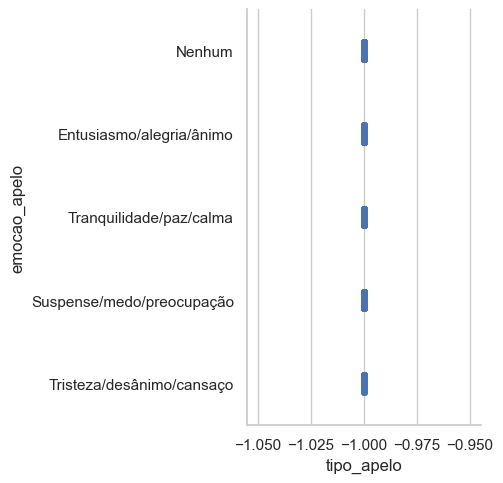

In [41]:
std_0 = a.iloc[0,0]
std_1 = a.iloc[1,0]
std_2 = a.iloc[2,0]
std_3 = a.iloc[3,0]
std_4 = a.iloc[4,0]
med_0 = a.iloc[0,1]
med_1 = a.iloc[1,1]
med_2 = a.iloc[2,1]
med_3 = a.iloc[3,1]
med_4 = a.iloc[4,1]


t01, p01 = stats.ttest_ind_from_stats(mean1=med_0, std1=std_0, nobs1=890,
                     mean2=med_1, std2=std_1, nobs2=6718)
t12, p12 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=6718,
                     mean2=med_2, std2=std_2, nobs2=10541)
t23, p23 = stats.ttest_ind_from_stats(mean1=med_2, std1=std_2, nobs1=10541,
                     mean2=med_3, std2=std_3, nobs2=2195)
t34, p34 = stats.ttest_ind_from_stats(mean1=med_4, std1=std_4, nobs1=731,
                     mean2=med_3, std2=std_3, nobs2=2195)

print(f'P-value Nenhum sentimento x Calma: {p01.round(3)}', f'P-value Calma x Entusiasmo: {p12}', 
      f'P-value Nenhum Preocupação x Calma: {p23.round(3)}', f'P-value Preocupação x Tristeza: {p34.round(3)}')

sns.catplot(ofer2, y = 'emocao_apelo', x = 'tipo_apelo')

#plt.xticks(rotation=90)


#### Appeals tone - negative toned appeals tend to be less materialistic, although all of them tend to be materialistic

In [7]:
# Weighted appeals

a = ofer1.groupby('tom_tempo_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']


std_0 = a.iloc[0,0]
std_1 = a.iloc[1,0]
std_2 = a.iloc[2,0]
std_3 = a.iloc[3,0]
#std_4 = a.iloc[4,0]
med_0 = a.iloc[0,1]
med_1 = a.iloc[1,1]
med_2 = a.iloc[2,1]
med_3 = a.iloc[3,1]
#med_4 = a.iloc[4,1]

a

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_43291/2556404278.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofer1.groupby('tom_tempo_apelo')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


std_corr      mean  median      N
tom_tempo_apelo                                   
0                5.201359  0.330472     0.0  25181
1                2.623568  0.667478     1.0  15211
2                0.770847  0.489723     1.0   4184
3                0.454257  0.722222     1.0     36

P-value Nao se aplica x Positivo: 0.0 P-value Positivo x Negativo: 0.0 P-value Negativo x Neutro: 0.071 P-value Positivo x Neutro: 0.9


'\n\nApelos positivos e neutros são significativamente mais materialistas que os negativos, ainda que apelos negativos também sejam\nmajoritariamente materiais. A proporção menor dos apelos negativos indica que, ainda que majoritariamente os apelos negativos também sejam utilizados para atacar com base em apelos\nmateriais, uma parte maior desses apelos é direcionada para ataques simbólicos, i.e., personalistas, em relação a apelos positivos ou \nneutros\n\n\n'

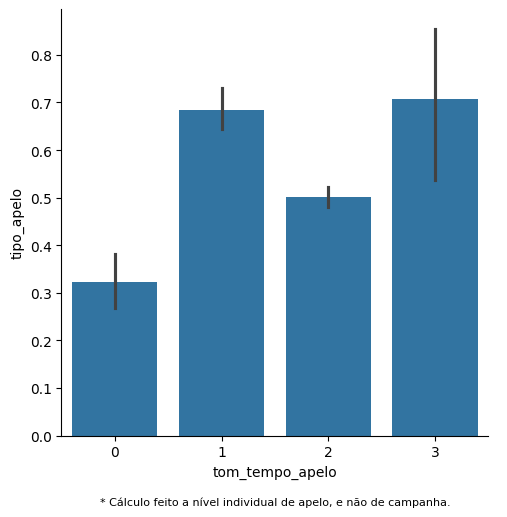

In [8]:
t01, p01 = stats.ttest_ind_from_stats(mean1=med_0, std1=std_0, nobs1=25181,
                     mean2=med_1, std2=std_1, nobs2=15211)
t12, p12 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=15211,
                     mean2=med_2, std2=std_2, nobs2=4184)
t23, p23 = stats.ttest_ind_from_stats(mean1=med_2, std1=std_2, nobs1=4184,
                     mean2=med_3, std2=std_3, nobs2=36)
t13, p13 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=15211,
                     mean2=med_3, std2=std_3, nobs2=36)

print(f'P-value Nao se aplica x Positivo: {p01.round(3)}', f'P-value Positivo x Negativo: {p12.round(3)}', 
      f'P-value Negativo x Neutro: {p23.round(3)}', f'P-value Positivo x Neutro: {p13.round(3)}')

sns.catplot(ofer, x = 'tom_tempo_apelo', y = 'tipo_apelo', kind = 'bar')
nota_de_rodape = plt.text(
    1.5,  # Posição X da nota de rodapé
    -0.15,  # Posição Y da nota de rodapé
    f"* Cálculo feito a nível individual de apelo, e não de campanha.",  # Conteúdo da nota de rodapé
    ha="center",  # Alinhamento horizontal
    va="bottom",  # Alinhamento vertical
    fontsize=8,  # Tamanho da fonte
    color="black",  # Cor da fonte
)

'''

Apelos positivos e neutros são significativamente mais materialistas que os negativos, ainda que apelos negativos também sejam
majoritariamente materiais. A proporção menor dos apelos negativos indica que, ainda que majoritariamente os apelos negativos também sejam utilizados para atacar com base em apelos
materiais, uma parte maior desses apelos é direcionada para ataques simbólicos, i.e., personalistas, em relação a apelos positivos ou 
neutros


'''

#### Time focus of the appeal - No interest association (All categories materialistic, but significantly different)

In [107]:
# Weighted appeals

a = ofer1.groupby('tempo_apelo_pais')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1698/2272703430.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = ofer1.groupby('tempo_apelo_pais')['tipo_apelo'].agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])


std_corr      mean  median      N
tempo_apelo_pais                                   
0                 5.208483  0.330079     0.0  25111
1                 2.849986  0.703596     1.0  11402
2                 1.638527  0.476956     1.0   4668
3                 0.763239  0.584741     1.0   3435

P-value Tempo Indefinido x Futuro: 0.0 P-value Futuro x Presente: 0.0 P-value Presente x Passado: 0.0 P-value Futuro x Passado: 0.016


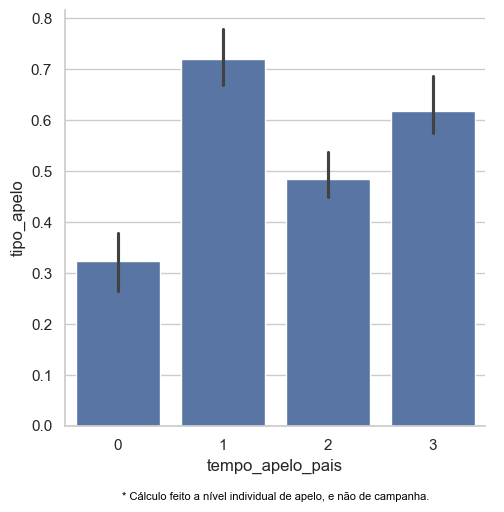

In [108]:
std_0 = a.iloc[0,0]
std_1 = a.iloc[1,0]
std_2 = a.iloc[2,0]
std_3 = a.iloc[3,0]
#std_4 = a.iloc[4,0]
med_0 = a.iloc[0,1]
med_1 = a.iloc[1,1]
med_2 = a.iloc[2,1]
med_3 = a.iloc[3,1]
#med_4 = a.iloc[4,1]


t01, p01 = stats.ttest_ind_from_stats(mean1=med_0, std1=std_0, nobs1=25111,
                     mean2=med_1, std2=std_1, nobs2=11402)
t12, p12 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=11402,
                     mean2=med_2, std2=std_2, nobs2=4668)
t23, p23 = stats.ttest_ind_from_stats(mean1=med_2, std1=std_2, nobs1=4668,
                     mean2=med_3, std2=std_3, nobs2=3435)
t13, p13 = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=11402,
                     mean2=med_3, std2=std_3, nobs2=3435)

print(f'P-value Tempo Indefinido x Futuro: {p01.round(3)}', f'P-value Futuro x Presente: {p12.round(3)}', 
      f'P-value Presente x Passado: {p23.round(3)}', f'P-value Futuro x Passado: {p13.round(3)}')

sns.catplot(ofer, x = 'tempo_apelo_pais', y = 'tipo_apelo', kind = 'bar')
nota_de_rodape = plt.text(
    1.5,  # Posição X da nota de rodapé
    -0.15,  # Posição Y da nota de rodapé
    f"* Cálculo feito a nível individual de apelo, e não de campanha.",  # Conteúdo da nota de rodapé
    ha="center",  # Alinhamento horizontal
    va="bottom",  # Alinhamento vertical
    fontsize=8,  # Tamanho da fonte
    color="black",  # Cor da fonte
)

'''

Apelos futuros tendem a ser mais materiais, presente mais simbólicos, e passado meio termo

'''

### Quantitative Variables

#### Mobilization Degree - symbolic campaigns tend to be more neutral

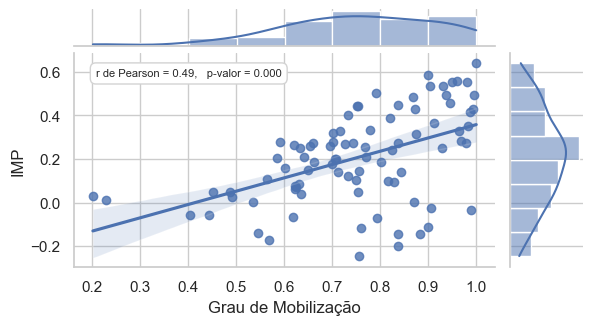

In [31]:

# Campanhas simbólicas tendem a ter um grau de neutralidade maior. Faz sentido. Isso porque campanhas materiais também se utilizam
#de simbolismo, principalmente o personalista, na disputa intra-ideológica - qual seria o candidato mais apto para levar a cabo 
#tal orientação ideológica (só confirmar se de fato classifiquei de simbólico esses casos)

af = sns.jointplot(ofestim, y = 'IMP', x = 'apelos_ativos', kind='reg')


#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim["IMP"], ofestim["apelos_ativos"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.493, 0.93), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Grau de Mobilização")
plt.ylabel("IMP")

af.fig.set_size_inches(6, 3)

# Mostre o gráfico
plt.show()



#### Votes in 1st turn -  No association

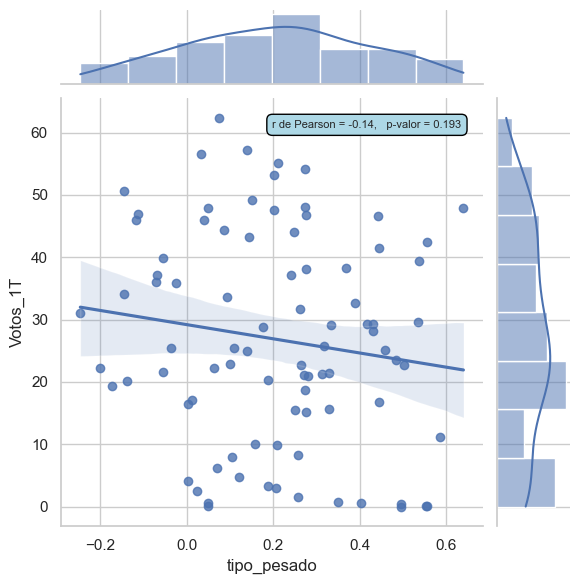

In [110]:


sns.jointplot(ofestim, y = 'Votos_1T', x = 'IMP', kind='reg')


#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim["Votos_1T"], ofestim["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("IMP")
plt.ylabel("Votos_1T")

# Mostre o gráfico
plt.show()



#### economical situation / GDP variation -  No association

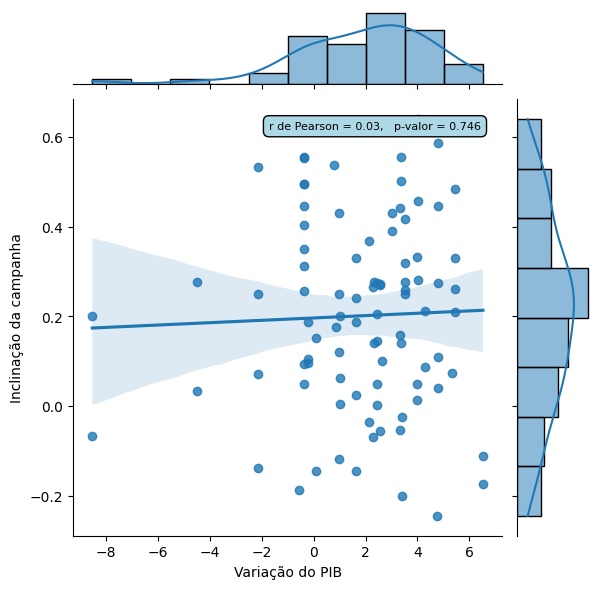

In [42]:

a = ofestim.copy()
sns.jointplot(a, y = 'IMP', x = 'var_anual_PIBpercapita', kind='reg')

ofestim1 = a.dropna(subset = 'var_anual_PIBpercapita')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["var_anual_PIBpercapita"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Variação do PIB")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


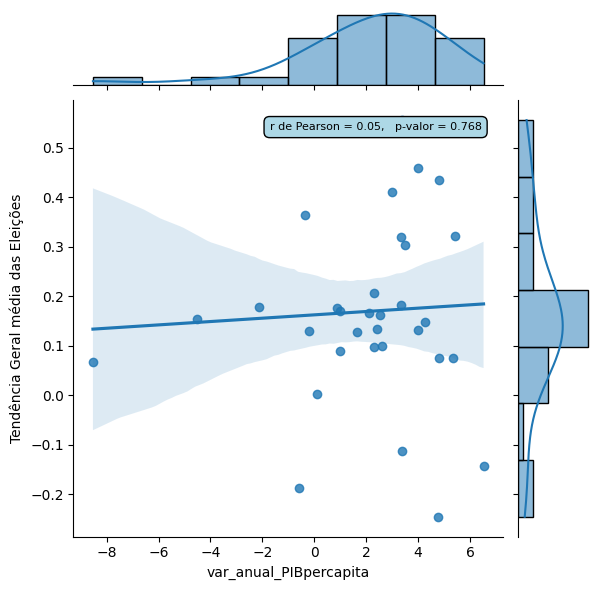

In [121]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'var_anual_PIBpercapita']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['IMP'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'IMP', x = 'var_anual_PIBpercapita', kind='reg')

ofestim1 = c.dropna(subset = 'var_anual_PIBpercapita')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["var_anual_PIBpercapita"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("var_anual_PIBpercapita")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

#### Inflation - No association

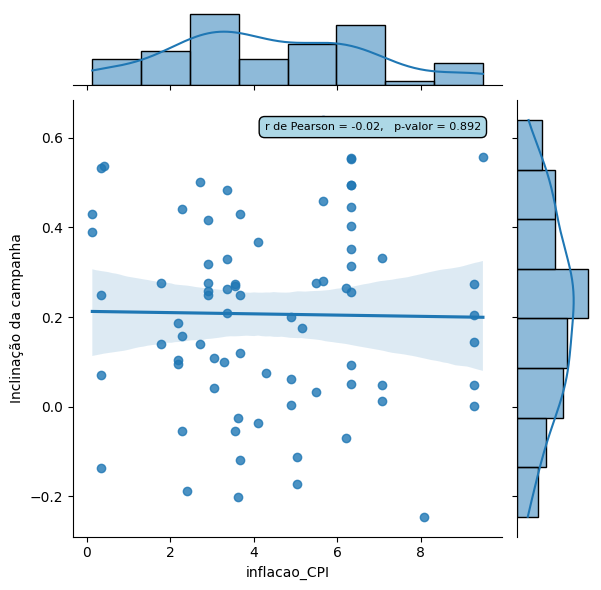

In [81]:

a = ofestim.copy()
sns.jointplot(a, y = 'IMP', x = 'inflacao_CPI', kind='reg')

ofestim1 = a.dropna(subset = 'inflacao_CPI')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["inflacao_CPI"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("inflacao_CPI")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


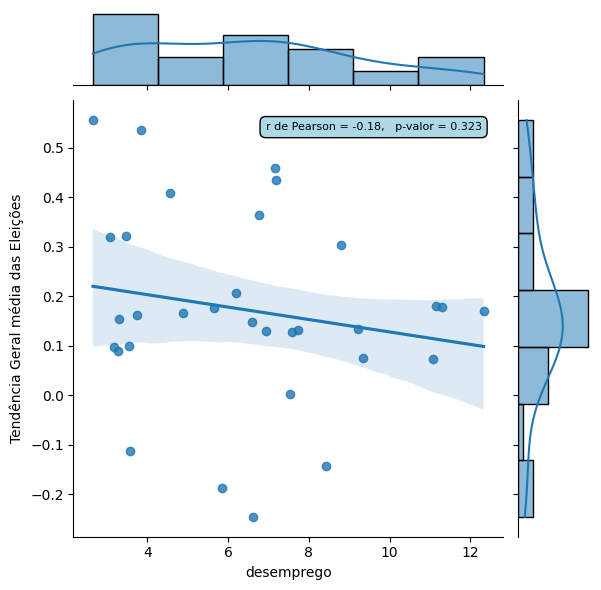

In [120]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'inflacao_CPI']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['IMP'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'IMP', x = 'inflacao_CPI', kind='reg')

ofestim1 = c.dropna(subset = 'inflacao_CPI')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["inflacao_CPI"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("inflacao_CPI")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

#### Unemployment - No association

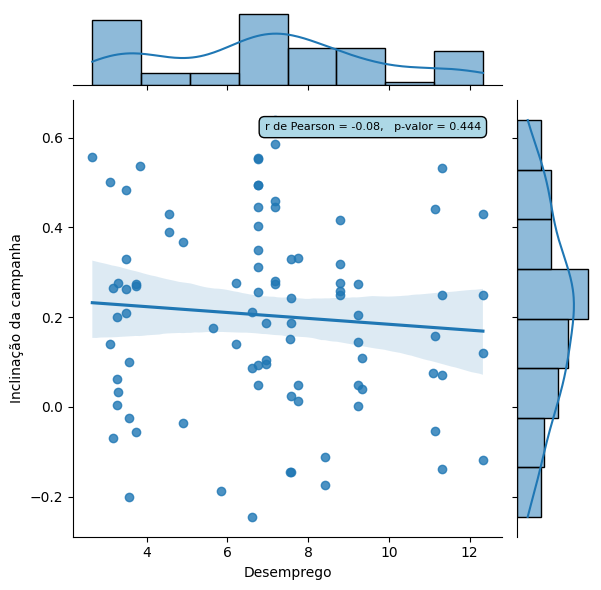

In [40]:

a = ofestim.copy()
sns.jointplot(a, y = 'IMP', x = 'desemprego', kind='reg')

ofestim1 = a.dropna(subset = 'desemprego')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["desemprego"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Desemprego")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


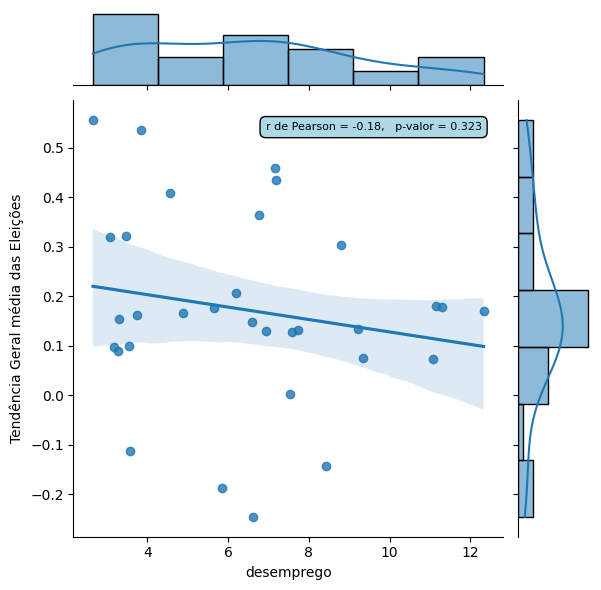

In [120]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'desemprego']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['IMP'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'IMP', x = 'desemprego', kind='reg')

ofestim1 = c.dropna(subset = 'desemprego')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["desemprego"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("desemprego")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

#### Inequality - No association

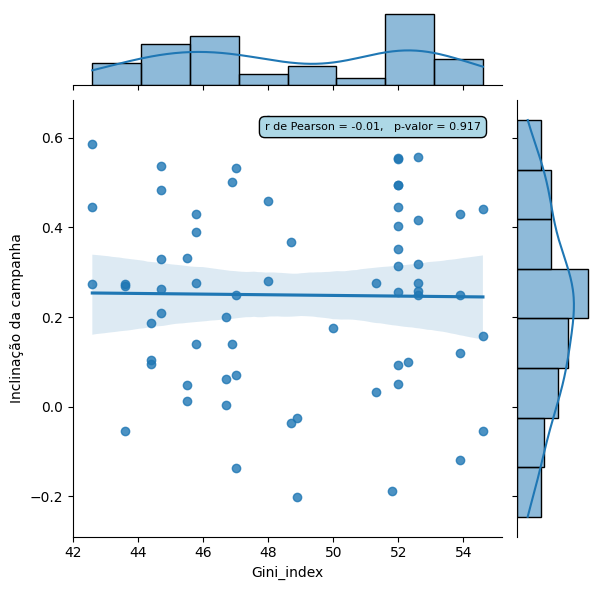

In [119]:

a = ofestim.copy()
sns.jointplot(a, y = 'IMP', x = 'Gini_index', kind='reg')

ofestim1 = a.dropna(subset = 'Gini_index')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["Gini_index"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Gini_index")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


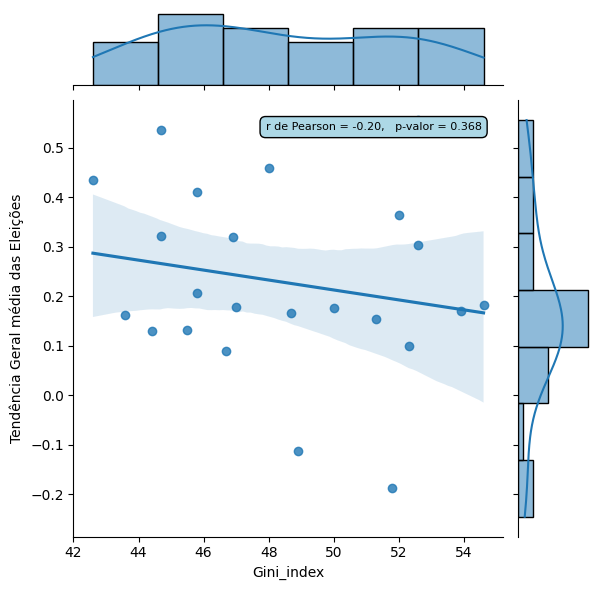

In [118]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'Gini_index']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['IMP'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'IMP', x = 'Gini_index', kind='reg')

ofestim1 = c.dropna(subset = 'Gini_index')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["Gini_index"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Gini_index")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

#### HDI - No association

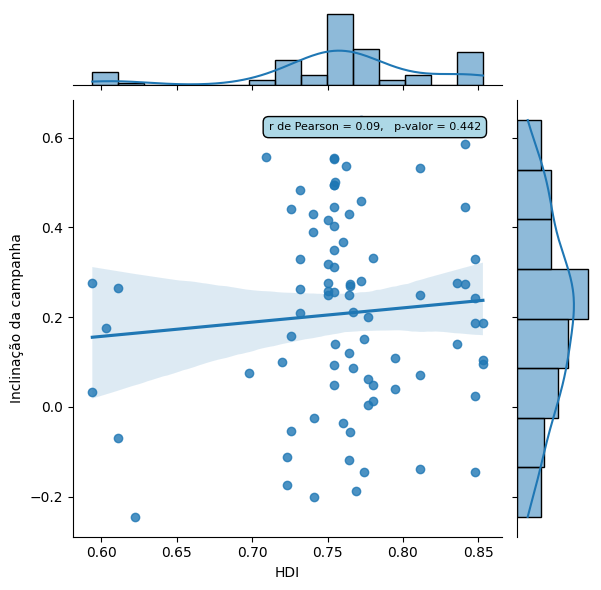

In [117]:

a = ofestim.copy()
sns.jointplot(a, y = 'IMP', x = 'HDI', kind='reg')

ofestim1 = a.dropna(subset = 'HDI')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["HDI"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("HDI")
plt.ylabel("Inclinação da campanha")

# Mostre o gráfico
plt.show()


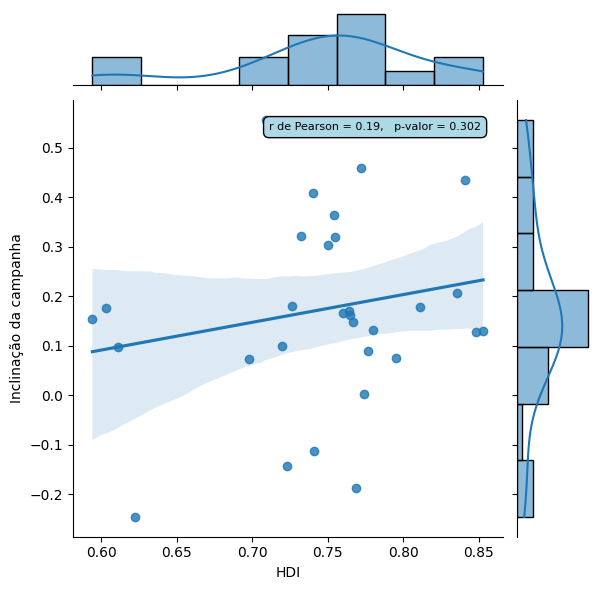

In [116]:

#Aggregated per election

a = ofestim.copy()
a = ofestim[['pais', 'ano_eleicao', 'HDI']].drop_duplicates().reset_index(drop=True)
            

b = ofestim.groupby(['pais', 'ano_eleicao'])['IMP'].agg('mean').reset_index()
c = pd.merge(a, b, on= ['pais', 'ano_eleicao'], how='left')


sns.jointplot(c, y = 'IMP', x = 'HDI', kind='reg')

ofestim1 = c.dropna(subset = 'HDI')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ofestim1["HDI"], ofestim1["IMP"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("HDI")
plt.ylabel("Tendência Geral média das Eleições")

# Mostre o gráfico
plt.show()

## Music and Emotions

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1584/2522490948.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.emocao_apelo = df.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1584/2522490948.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = df.groupby('musica')['emocao_apelo'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()


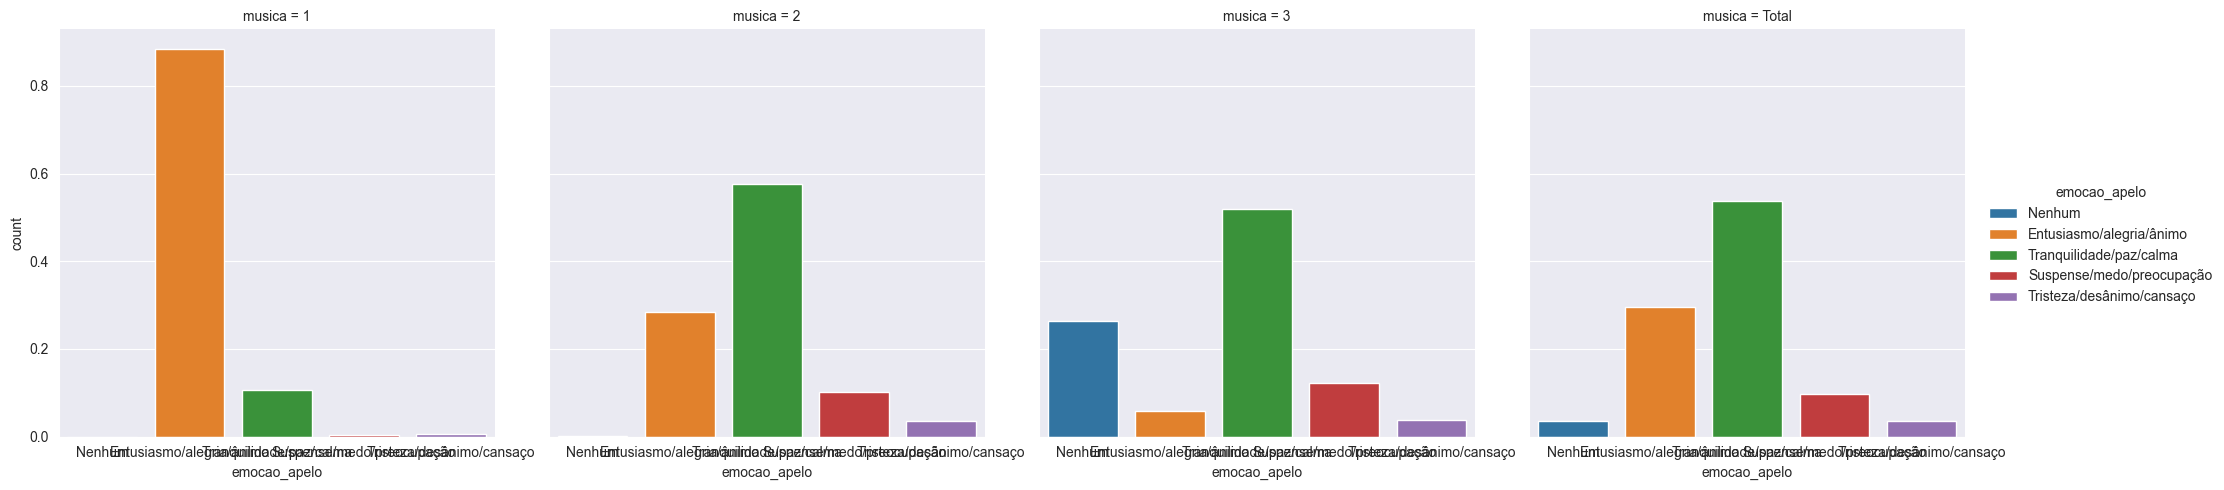

In [116]:
df = ofer.copy()
df.emocao_apelo = df.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
                                                            'Tranquilidade/paz/calma', 
                                                            'Suspense/medo/preocupação',
                                                            'Tristeza/desânimo/cansaço',
                                                            'Nenhum'])


a = df.groupby('musica')['emocao_apelo'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['musica', 'emocao_apelo', 'count']
b = df['emocao_apelo'].value_counts()/df['emocao_apelo'].value_counts().sum()
b = b.reset_index()
b['musica']='Total'

ab = pd.concat([a, b])
ab

sns.set_style('darkgrid')
sns.catplot(data=ab, x = 'emocao_apelo', y = 'count', kind ='bar', hue = 'emocao_apelo', col = 'musica', legend=True)

### Ideology and emotions - left wing a bit more enthusiastic, independents more calm, right wing emotionally moderates

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1584/3530806460.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.emocao_apelo = df.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',


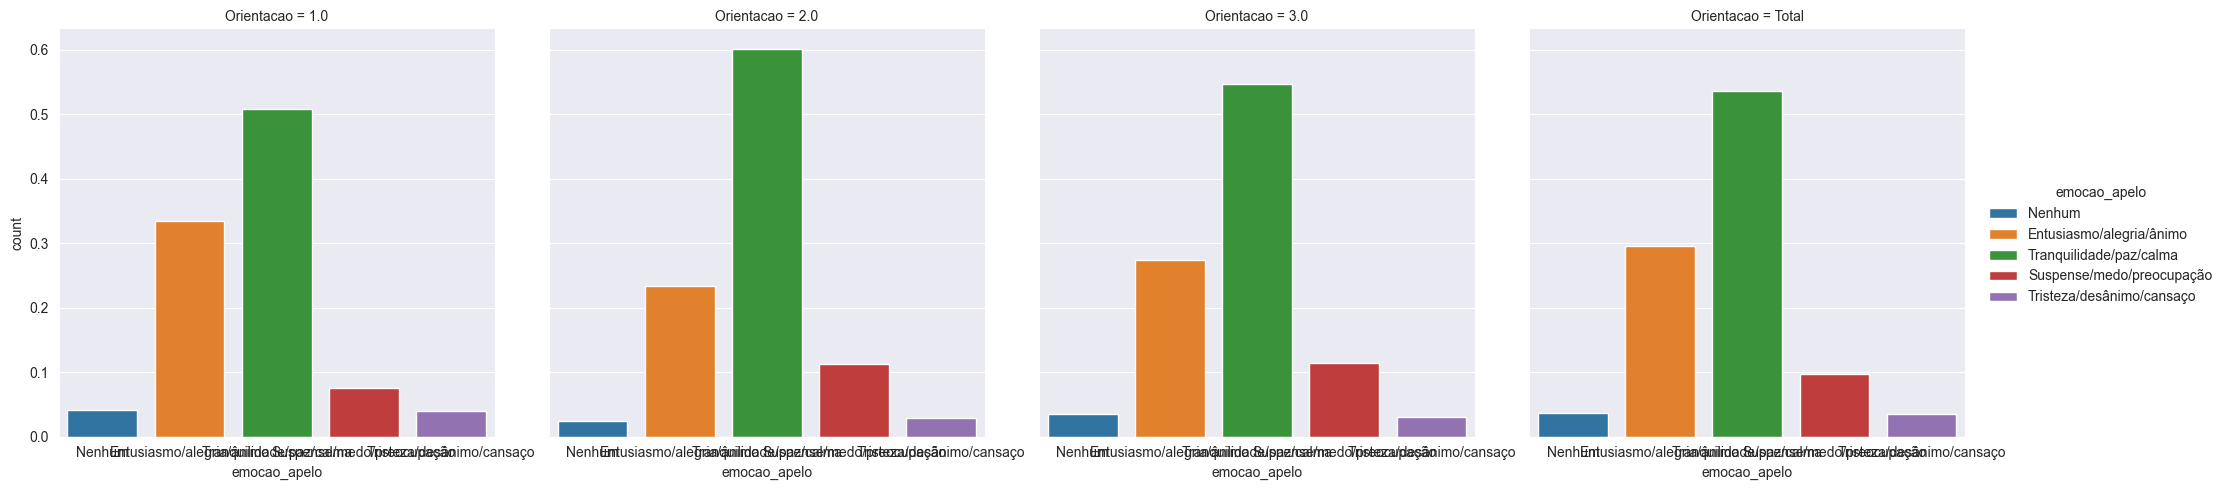

In [117]:
df = ofer.copy()
df.emocao_apelo = df.emocao_apelo.replace(['1', '2', '3', '4', '0'], ['Entusiasmo/alegria/ânimo',
                                                            'Tranquilidade/paz/calma', 
                                                            'Suspense/medo/preocupação',
                                                            'Tristeza/desânimo/cansaço',
                                                            'Nenhum'])


a = df.groupby('Orientacao')['emocao_apelo'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['Orientacao', 'emocao_apelo', 'count']
b = df['emocao_apelo'].value_counts()/df['emocao_apelo'].value_counts().sum()
b = b.reset_index()
b['Orientacao']='Total'

ab = pd.concat([a, b])
ab

sns.set_style('darkgrid')
sns.catplot(data=ab, x = 'emocao_apelo', y = 'count', kind ='bar', hue = 'emocao_apelo', col = 'Orientacao', legend=True)

### Ideology and Music - No association

In [28]:
df = ofer.copy()
df.musica = df.musica.replace(['1', '2', '3'], ['Jingle', 'Música Background', 'Sem música'])

df.musica.unique()

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1584/1829761273.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.musica = df.musica.replace(['1', '2', '3'], ['Jingle', 'Música Background', 'Sem música'])


['Sem música', 'Música Background', 'Jingle', NaN]
Categories (3, object): ['Jingle', 'Música Background', 'Sem música']

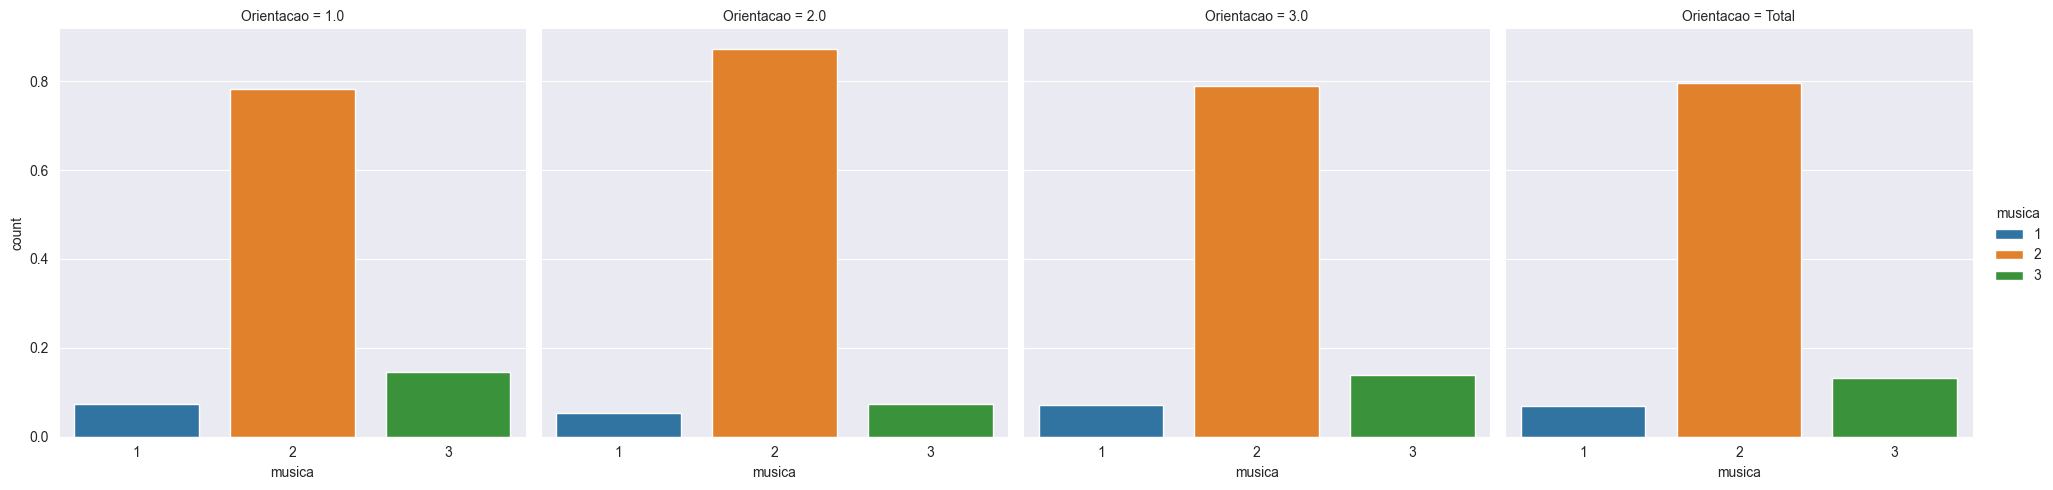

In [ ]:
a = df.groupby('Orientacao')['musica'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['Orientacao', 'musica', 'count']
b = df['musica'].value_counts()/df['musica'].value_counts().sum()
b = b.reset_index()
b['Orientacao']='Total'

ab = pd.concat([a, b])
ab

sns.set_style('darkgrid')
sns.catplot(data=ab, x = 'musica', y = 'count', kind ='bar', hue = 'musica', col = 'Orientacao', legend=True)

## Appeals Tone and time

### time Appeals x Ideology  - Situation candidates more focused on the past/Independents more critics about the present and past

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_43291/2780443153.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.tom_tempo_apelo = df.tom_tempo_apelo.replace(['1', '2', '3', '0'], ['Positivos',
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_43291/2780443153.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.tempo_apelo_pais = df.tempo_apelo_pais.replace(['1', '2', '3', '0'], ['Futuro',


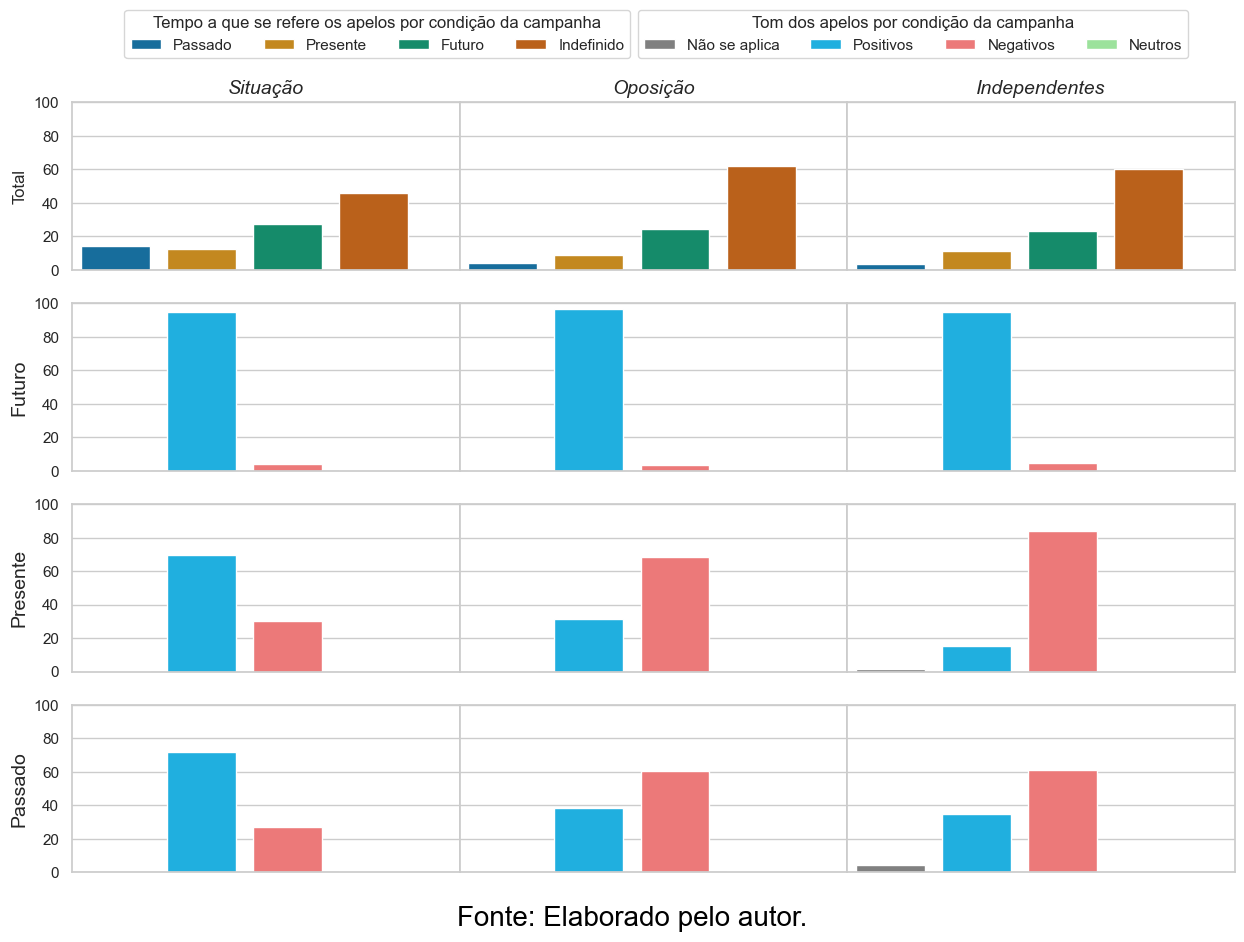

In [518]:
#| fig-cap: "Tempo e tom dos apelos das campanhas de acordo com sua situação eleitoral"
#| label: fig-tomtempositu

df = ofer1.copy()
df.tom_tempo_apelo = df.tom_tempo_apelo.replace(['1', '2', '3', '0'], ['Positivos', 
                                                                       'Negativos',
                                                                       'Neutros',
                                                                       'Não se aplica'])

df.tempo_apelo_pais = df.tempo_apelo_pais.replace(['1', '2', '3', '0'], ['Futuro', 
                                                                       'Presente',
                                                                       'Passado',
                                                                       'Indefinido'])


df.Situacao_oposicao = df.Situacao_oposicao.replace([1.0, 2.0, 3.0, 0.0], ['Situação', 
                                                                       'Oposição',
                                                                       'Independente',
                                                                       'Indeterminado'])

a = df.groupby(['Situacao_oposicao'])['tempo_apelo_pais'].apply(lambda x: x.value_counts()/x.value_counts().sum()).reset_index()
a.columns = ['Situacao_oposicao', 'tempo_apelo_pais', 'count']

ind = df[df.Situacao_oposicao=='Independente']
indpres = ind[ind.tempo_apelo_pais=='Presente']
indpas = ind[ind.tempo_apelo_pais=='Passado']
indfut = ind[ind.tempo_apelo_pais=='Futuro']

opo = df[df.Situacao_oposicao=='Oposição']
opopres = opo[opo.tempo_apelo_pais=='Presente']
opopas = opo[opo.tempo_apelo_pais=='Passado']
opofut = opo[opo.tempo_apelo_pais=='Futuro']

situ= df[df.Situacao_oposicao=='Situação']
situpres = situ[situ.tempo_apelo_pais=='Presente']
situpas = situ[situ.tempo_apelo_pais=='Passado']
situfut = situ[situ.tempo_apelo_pais=='Futuro']

fig, axes = plt.subplot_mosaic([['a', 'b', 'c'], ['f', 'i', 'l'], ['d', 'g', 'j'], ['e', 'h', 'k']], figsize=(15, 10), sharey = True)

# Totals

gsitu = sns.countplot(data=situ, x = 'tempo_apelo_pais', stat='percent', hue = 'tempo_apelo_pais', 
                  legend=True, ax=axes['a'], palette = 'colorblind', order = ['Passado', 'Presente', 'Futuro', 'Indefinido'],
                  hue_order = ['Passado', 'Presente', 'Futuro', 'Indefinido'])

axes['a'].set_ylim(0,70)

gopo = sns.countplot(data=opo, x = 'tempo_apelo_pais', stat='percent', hue = 'tempo_apelo_pais', 
                  legend=False, ax=axes['b'], palette = 'colorblind', order = ['Passado', 'Presente', 'Futuro', 'Indefinido'],
                  hue_order = ['Passado', 'Presente', 'Futuro', 'Indefinido'])


gind = sns.countplot(data=ind, x = 'tempo_apelo_pais', stat='percent', hue = 'tempo_apelo_pais', 
                  legend=False, ax=axes['c'], palette = 'colorblind', order = ['Passado', 'Presente', 'Futuro', 'Indefinido'],
                  hue_order = ['Passado', 'Presente', 'Futuro', 'Indefinido'])

cor = {'Não se aplica':'gray', 'Positivos':'#00BFFF', 'Negativos' :'#FF6666', 'Neutros':'lightgreen'}

#Situation

gsitupres = sns.countplot(data=situpres, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['d'], palette = cor)


gsitupas = sns.countplot(data=situpas, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['e'], palette = cor)


gsitufut = sns.countplot(data=situfut, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['f'], palette = cor)

#Oposition

gopopres = sns.countplot(data=opopres, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['g'], dodge = False, palette = cor)

gopopas = sns.countplot(data=opopas, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['h'], dodge = False, palette = cor)


gopofut = sns.countplot(data=opofut, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=True, ax=axes['i'], dodge = False, palette = cor)


#Independents

gindpres = sns.countplot(data=indpres, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['j'], dodge = False, palette = cor)

gindpas = sns.countplot(data=indpas, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['k'], dodge = False, palette = cor)

gindfut = sns.countplot(data=indfut, x = 'tom_tempo_apelo', hue = 'tom_tempo_apelo', stat='percent',
                  legend=False, ax=axes['l'], dodge = False, palette = cor)

axes['a'].set_xlabel('')
axes['a'].set_ylabel('Total')
axes['a'].set_title('Situação', fontsize=14, style = 'italic')
axes['a'].set_xticks('')
axes['a'].set_ylim(0,70)


axes['b'].set_xlabel('')
axes['b'].set_ylabel('')
axes['b'].set_title('Oposição', fontsize=14, style = 'italic')
axes['b'].set_xticks('')

axes['c'].set_xlabel('')
axes['c'].set_ylabel('')
axes['c'].set_title('Independentes', fontsize=14, style = 'italic')
axes['c'].set_xticks('')

axes['d'].set_xlabel('')
axes['d'].set_ylabel('Presente', fontsize=14)
axes['d'].set_xticks('')
axes['d'].set_title('')

axes['e'].set_xlabel('')
axes['e'].set_ylabel('Passado', fontsize=14)
axes['e'].set_xticks('')
axes['e'].set_title('')
axes['e'].set_ylim(0,100)

axes['f'].set_xlabel('')
axes['f'].set_ylabel('Futuro', fontsize=14)
axes['f'].set_xticks('')
axes['f'].set_title('')

axes['g'].set_xlabel('')
axes['g'].set_ylabel('')
axes['g'].set_xticks('')

axes['h'].set_xlabel('')
axes['h'].set_ylabel('Oposição (%)')
axes['h'].set_xticks('')
axes['h'].set_ylim(0,100)

axes['i'].set_xlabel('')
axes['i'].set_ylabel('')
axes['i'].set_xticks('')

axes['j'].set_xlabel('')
axes['j'].set_ylabel('')
axes['j'].set_xticks('')

axes['k'].set_xlabel('')
axes['k'].set_ylabel('Independentes (%)')
axes['k'].set_xticks('')
axes['k'].set_ylim(0,100)

axes['l'].set_xlabel('')
axes['l'].set_ylabel('')
axes['l'].set_xticks('')

axes['a'].legend(ncol=4, bbox_to_anchor = (1.46,1.6), title = 'Tempo a que se refere os apelos por condição da campanha')
axes['i'].legend(ncol=4, bbox_to_anchor = (1.9, 2.80), title = 'Tom dos apelos por condição da campanha')

# footnote source 

nota_de_rodape = plt.text(
    -3,  -20,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=20, 
    color="black"
)

fig.subplots_adjust(wspace=0)


plt.show()

### Contingency table 

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_97136/384947833.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.tom_tempo_apelo = df.tom_tempo_apelo.replace(['1', '2', '3', '0'], ['Positivos',
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_97136/384947833.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.tempo_apelo_pais = df.tempo_apelo_pais.replace(['1', '2', '3', '0'], ['Futuro',


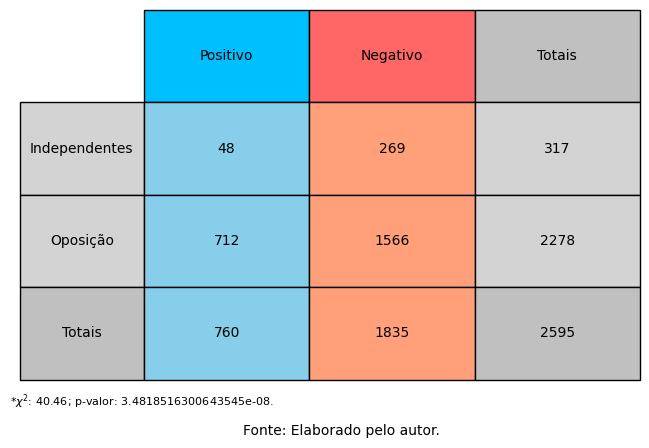

3.4818516300643545e-08

In [30]:
#| label: tbl-contiposi
#| tbl-cap: contingencia

df = ofer1.copy()
df.tom_tempo_apelo = df.tom_tempo_apelo.replace(['1', '2', '3', '0'], ['Positivos', 
                                                                       'Negativos',
                                                                       'Neutros',
                                                                       'Não se aplica'])

df.tempo_apelo_pais = df.tempo_apelo_pais.replace(['1', '2', '3', '0'], ['Futuro', 
                                                                       'Presente',
                                                                       'Passado',
                                                                       'Indefinido'])


df.Situacao_oposicao = df.Situacao_oposicao.replace([1.0, 2.0, 3.0, 0.0], ['Situação', 
                                                                       'Oposição',
                                                                       'Independente',
                                                                       'Indeterminado'])


df1 = df[(df.Situacao_oposicao.isin(['Oposição','Independente'])) & (df.tempo_apelo_pais=='Presente') & 
         (df.tom_tempo_apelo.isin(['Positivos', 'Negativos']))]


# Cross-contingency table 
contingency_table = pd.crosstab(df1['Situacao_oposicao'], df1['tom_tempo_apelo'], margins=True, margins_name='Total')

# Chi2 Test
chi2, pval, dof, expected = stats.chi2_contingency(contingency_table)


cell = [['48','269','317'], 
        ['712', '1566', '2278'],
        ['760', '1835', '2595']]


cor = [['#87CEEB','#FFA07A','lightgray'], 
        ['#87CEEB', '#FFA07A', 'lightgray'],
        ['#87CEEB', '#FFA07A', '#C0C0C0']]

plt.table(cell, cellColours=cor, cellLoc='center', rowLabels=['Independentes', 'Oposição', 'Totais'], rowLoc='center',
          colLabels=['Positivo', 'Negativo', 'Totais'], colColours=['#00BFFF', '#FF6666', '#C0C0C0'],
          rowColours=['lightgray', 'lightgray', '#C0C0C0'], bbox=[0, 0, 1, 1])
plt.text(-0.27,-0.07, f'*$\chi^2$: {chi2:.2f}; p-valor: {pval}.', fontsize=8)

plt.text(0.2,-0.15, f'Fonte: Elaborado pelo autor.', fontsize=10)

plt.axis('off') 

plt.show()
pval

In [31]:
contingency_table

tom_tempo_apelo    Positivos  Negativos  Total
Situacao_oposicao                             
Independente              48        278    326
Oposição                 748       1595   2343
Total                    796       1873   2669

# Ofer and demand relations

## Ideology

p-valor: 0.61 Chi2:2.70


/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_37649/1885481188.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  an = df_centro.groupby(['pais', 'ano_eleicao']).agg({'posi_poli_centro':'mean'})


Orientacao  1.0  2.0  3.0
posici                   
1.0           6    1    2
2.0           2    0    3
3.0           6    1    7

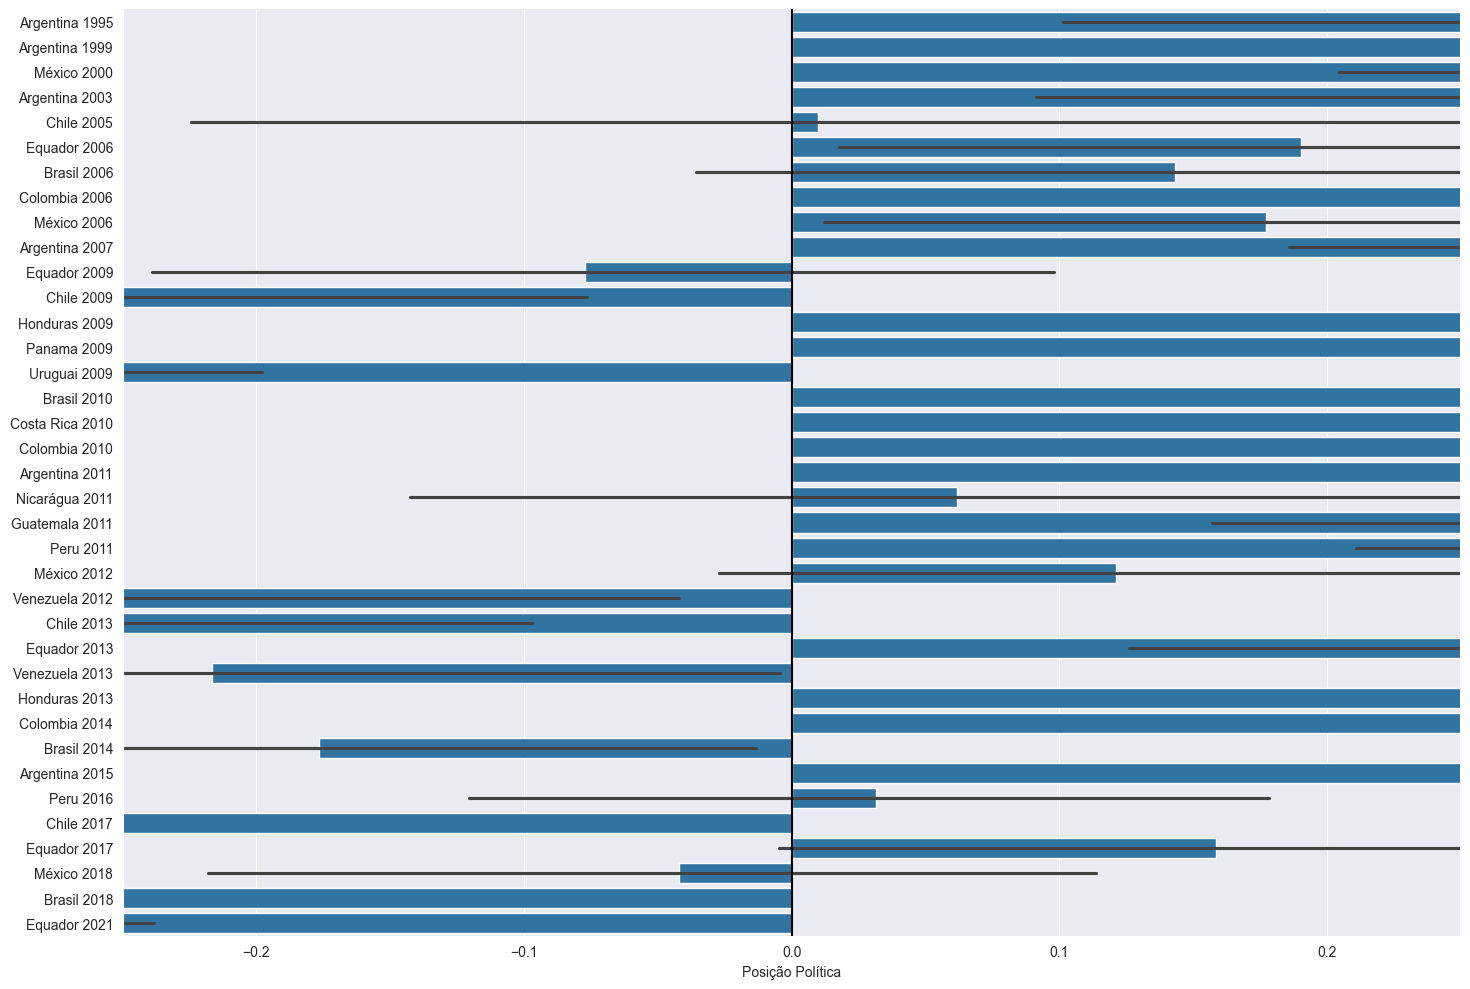

In [93]:

#Creating Election Index (Country + Election Year)

da = df_centro.copy()
da = da.astype({'pais':'str', 'ano_eleicao':'str'})
da['todes'] = da['pais'] + ' ' + da['ano_eleicao']
da['todes']

# Reclassifing voters mean position into right, center and left per election
af = sns.catplot(
    data=da,
    y="todes",
    #hue='cor',
    #order=lis.pais.unique(),
    x="posi_poli_centro",
    kind="bar",
    dodge='auto',
    height=10,
    legend=False,
    weights='peso',
    #palette=cores,
    aspect=1.5 # Ajustar proporção do gráfico
)

af.set_axis_labels("Posição Política", "")
plt.axvline(x = 0, color = "black", linestyle = "-")
plt.xlim(-0.25, 0.25)
af.set_titles("{col_name}")

#plt.show()

#Creating Dataset with ideology from voters and campaigns

# Recoding voters ideology

an = df_centro.groupby(['pais', 'ano_eleicao']).agg({'posi_poli_centro':'mean'})
an = an.dropna().reset_index()

condcenter = [
    (an['pais']== 'Chile') & (an['ano_eleicao']==2005),
    (an['pais']== 'Brasil') & (an['ano_eleicao']==2006),
    (an['pais']== 'México') & (an['ano_eleicao']==2006),
    (an['pais']== 'Equador') & (an['ano_eleicao']==2009),
    (an['pais']== 'Nicarágua') & (an['ano_eleicao']==2011),
    (an['pais']== 'México') & (an['ano_eleicao']==2012),
    (an['pais']== 'Peru') & (an['ano_eleicao']==2016),
    (an['pais']== 'México') & (an['ano_eleicao']==2018),
    
    (an['pais']== 'Chile') & (an['ano_eleicao']==2009),
    (an['pais']== 'Uruguai') & (an['ano_eleicao']==2009),
    (an['pais']== 'Venezuela') & (an['ano_eleicao']==2012),
    (an['pais']== 'Chile') & (an['ano_eleicao']==2013),
    (an['pais']== 'Venezuela') & (an['ano_eleicao']==2013),
    (an['pais']== 'Brasil') & (an['ano_eleicao']==2014),
    (an['pais']== 'Chile') & (an['ano_eleicao']==2017),
    (an['pais']== 'Brasil') & (an['ano_eleicao']==2018),
    (an['pais']== 'Equador') & (an['ano_eleicao']==2021),

]

choice = [2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

an['posici']= np.select(condcenter, choice, default = 3)

# Campaigns Ideology
av = ofestim[['pais', 'ano_eleicao', 'Orientacao']][ofestim['Eleito']==1].reset_index(drop=True)

# Unified Dataset
af = pd.merge(av, an, how='left', on=['pais', 'ano_eleicao'])


# Cross-contingency table
contingency_table = pd.crosstab(af['posici'], af['Orientacao'])

# Chi2 Test
chi2, pval, dof, expected = stats.chi2_contingency(contingency_table)

print(f'p-valor: {pval:.2f}', f'Chi2:{chi2:.2f}')

contingency_table

'''
There's no association between ideology of the winning campaigns and voters in the year of election (low N=28) 

'''


## main theme/ main problem

### 40% of elected campaigns had the same principal category of appeals as the one voters said is the main problem; 26% of non elected.

<function matplotlib.pyplot.show(close=None, block=None)>

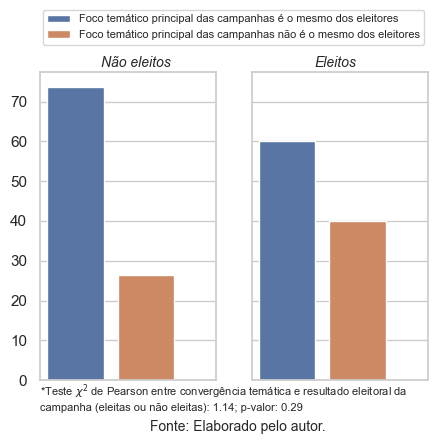

In [598]:
#| fig-cap: '% de convergência entre o principal tema das campanhas e dos eleitores por resultado eleitoral'
#| label: fig-convtem

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,4))

nelei = ofestim[ofestim.Eleito==0]
elei = ofestim[ofestim.Eleito==1]

elei = elei.astype({'match_probtema_maincats':'object'})
nelei = nelei.astype({'match_probtema_maincats':'object'})


elei.match_probtema_maincats = elei.match_probtema_maincats.replace(
    {0:'Foco temático principal das campanhas é o mesmo dos eleitores', 
     1:'Foco temático principal das campanhas não é o mesmo dos eleitores'})
nelei.match_probtema_maincats = nelei.match_probtema_maincats.replace({0:'Principal problema distinto', 1:'Mesmo principal problema'})


sns.countplot(nelei, x = 'match_probtema_maincats', stat='percent', ax=axes[0], hue = 'match_probtema_maincats', legend= False)
axes[0].set(ylabel ='', xlabel='', xticks='')

sns.countplot(elei, x = 'match_probtema_maincats', stat='percent', ax=axes[1], hue = 'match_probtema_maincats', legend= True)
axes[1].set(ylabel ='', xlabel='', xticks='')

# Legend
axes[1].legend(title=None, bbox_to_anchor=(1.01, 1.22), fontsize=8)


#Title Non elected

plt.text(-2.15, 81.5, 
        f'Não eleitos', va='top', ha='center', fontsize=10, style='italic')

#Title elected

plt.text(0.68, 81.5, 
        f'Eleitos', va='top', ha='center', fontsize=10, style='italic')

# Cross-contingency table 
contingency_table = pd.crosstab(ofestim['Eleito'], ofestim['match_probtema_maincats'])

# Chi2 Test
chi2, pval, dof, expected = stats.chi2_contingency(contingency_table)

#Footnote Chi2 test
plt.text(-3.5, -0.6, 
        f'*Teste $\chi^2$ de Pearson entre convergência temática e resultado eleitoral da\ncampanha (eleitas ou não eleitas)' 
        f': {chi2.round(3)}; p-valor: {pval.round(2)}', va='top', ha='left', fontsize=8)

#Source footnote

plt.text(-0.7, -10, 
        f'Fonte: Elaborado pelo autor.', va='top', ha='center', fontsize=10)

plt.show


### Strong correlation between main theme campaigns and voters: candidates are focusing their campaigns in problems perceived by voters; on the other side, 40% of correlation among elected ones suggestes that this is not the main factor deciding elections  

## IMP Relations

### IMP x economic evaluation - no association

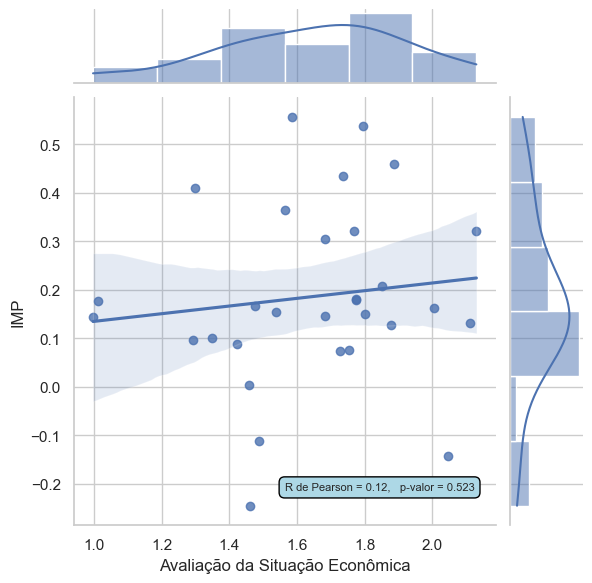

In [101]:
# Calculating weighted Variables
dem_semna = dem2.dropna(subset=['conf_part2', 'sit_econ2'])

conf_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['conf_part2'], weights=x['peso']), include_groups = False).reset_index()

sit_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['sit_econ2'], weights=x['peso']), include_groups = False).reset_index()
                                                         
jun= pd.merge(conf_w, sit_w, on = ['pais', 'ano_eleicao'], how='left')
jun.rename(columns={'0_x':'Confiança nos Partidos', '0_y': 'Avaliação da Situação Econômica'}, inplace = True)


a = ofestim.groupby(['pais', 'ano_eleicao']).agg({'IMP':'mean'}).reset_index()
ab = pd.merge(a, jun, how='left')
ab = ab.dropna(subset=['Avaliação da Situação Econômica'])

# Plotting joint scatterplot

sns.set_theme(style = 'whitegrid')
sns.jointplot(ab, x = 'Avaliação da Situação Econômica', y = 'IMP', kind='reg')

#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab["Avaliação da Situação Econômica"], ab["IMP"])
plt.annotate(f"R de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.1), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))


plt.show()

### IMP x Trust in Parties -  No association isolated

#### Among Elected

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/1295787357.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


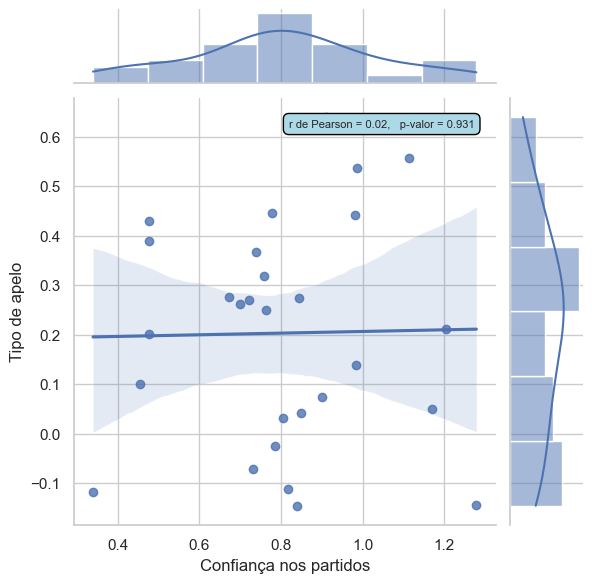

"\n\nIsolated theres's no association between trust in institutions and type of appeal\n"

In [94]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

b = ofestim[ofestim.Eleito==1]

ab = pd.merge(b, a, how='left', on=['pais', 'ano_eleicao'])


sns.jointplot(ab, y = 'IMP', x = 'conf_part2', kind='reg')

ab1 = ab.dropna(subset = 'conf_part2')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["IMP"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Confiança nos partidos")
plt.ylabel("Tipo de apelo")

# Mostre o gráfico
plt.show()

'''

Isolated theres's no association between trust in institutions and type of appeal
'''

#### General 

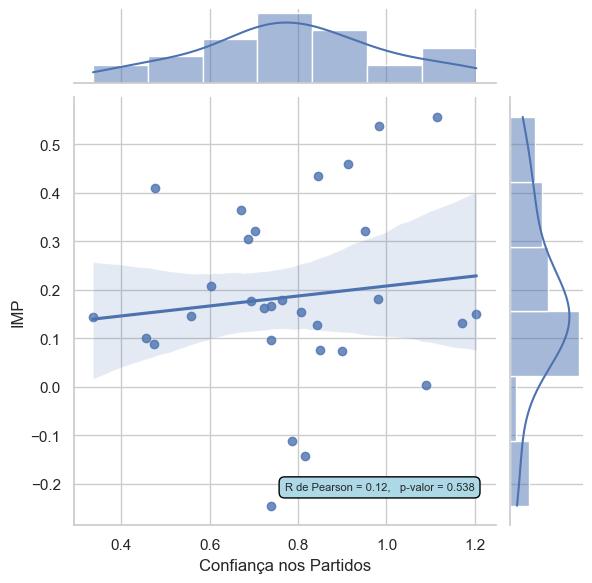

In [111]:
# Calculating weighted Variables
dem_semna = dem2.dropna(subset=['conf_part2', 'sit_econ2'])

conf_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['conf_part2'], weights=x['peso']), include_groups = False).reset_index()

sit_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['sit_econ2'], weights=x['peso']), include_groups = False).reset_index()
                                                         
jun= pd.merge(conf_w, sit_w, on = ['pais', 'ano_eleicao'], how='left')
jun.rename(columns={'0_x':'Confiança nos Partidos', '0_y': 'Avaliação da Situação Econômica'}, inplace = True)


a = ofestim.groupby(['pais', 'ano_eleicao']).agg({'IMP':'mean'}).reset_index()
ab = pd.merge(a, jun, how='left')
ab = ab.dropna(subset=['Confiança nos Partidos', 'IMP'])

# Plotting joint scatterplot

sns.set_theme(style = 'whitegrid')
sns.jointplot(ab, x = 'Confiança nos Partidos', y = 'IMP', kind='reg')

#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab["Confiança nos Partidos"], ab["IMP"])
plt.annotate(f"R de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.1), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

### Imp x Economic evaluation and Trust in Parties

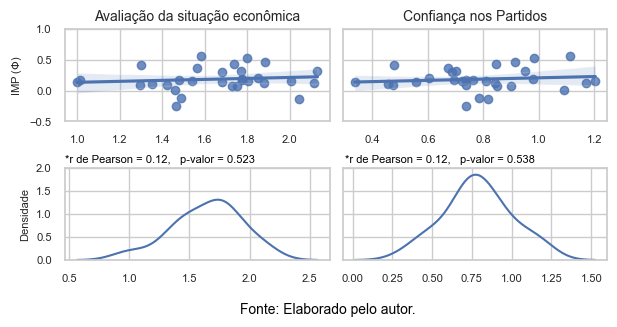

In [120]:
#| fig-cap: 'Correlação entre IMP, avaliação da situação econômica e confiança nos partidos'
#| label: fig-impavalconf

# Calculating weighted Variables
dem_semna = dem2.dropna(subset=['conf_part2', 'sit_econ2'])

conf_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['conf_part2'], weights=x['peso']), include_groups = False).reset_index()

sit_w = dem_semna.groupby(
    ['pais', 'ano_eleicao'], observed = False).apply(
    lambda x: np.average(x['sit_econ2'], weights=x['peso']), include_groups = False).reset_index()
                                                         
jun= pd.merge(conf_w, sit_w, on = ['pais', 'ano_eleicao'], how='left')
jun.rename(columns={'0_x':'Confiança nos Partidos', '0_y': 'Avaliação da Situação Econômica'}, inplace = True)

a = ofestim.groupby(['pais', 'ano_eleicao']).agg({'IMP':'mean'}).reset_index()
ab = pd.merge(a, jun, how='left')
ab = ab.dropna(subset=['Avaliação da Situação Econômica'])


fig, axes = plt.subplots(2, 2, sharey=False, figsize=(7, 3))

# Plotting Economic evaluation x IMP

sns.set_theme(style = 'whitegrid')
sns.regplot(ab, x = 'Avaliação da Situação Econômica', y = 'IMP', ax = axes[0,0])


#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab["Avaliação da Situação Econômica"], ab["IMP"])


nota_de_rodape = fig.text(
    0.125,  0.46,
    f"*r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}",
    ha="left",
    va="top",    
    fontsize=8, 
    color="black"
)

axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('IMP ($\Phi$)', fontsize=8)
axes[0,0].set_title('Avaliação da situação econômica', fontsize=10)
axes[0,0].set(ylim=(-0.5, 1))
axes[0,0].tick_params(labelsize=8)


# Plotting confidence in parties x IMP

sns.set_theme(style = 'whitegrid')
sns.regplot(ab, x = 'Confiança nos Partidos', y = 'IMP', ax=axes[0,1])
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_title('Confiança nos Partidos', fontsize=10)
axes[0,1].tick_params(labelleft=False, labelsize=8)
axes[0,1].set(ylim=(-0.5, 1))

#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab["Confiança nos Partidos"], ab["IMP"])

nota_de_rodape = fig.text(
    0.525,  0.46,
    f"*r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}",
    ha="left",
    va="top",    
    fontsize=8, 
    color="black"
)
# Economic evaluation Kde plot

af = sns.kdeplot(ab, x = 'Avaliação da Situação Econômica', ax = axes[1,0])
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Densidade', fontsize=8)
axes[1,0].tick_params(labelsize=8)
axes[1,0].set(ylim = (0, 2))

# Confidence in parties kde plot

af = sns.kdeplot(ab, x = 'Confiança nos Partidos', ax = axes[1,1])
axes[1,1].tick_params(labelsize=8, labelleft=False)
axes[1,1].set(ylim = (0, 2))

nota_de_rodape = fig.text(
    0.5,  -0.08,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="bottom",    
    fontsize=10, 
    color="black"
)

fig.subplots_adjust(wspace=0.05, hspace=0.5)

plt.ylabel('')
plt.xlabel('')

plt.show()

## Trust in Parties relations

### Trust in parties x mobilization degree - No association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/3081575862.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


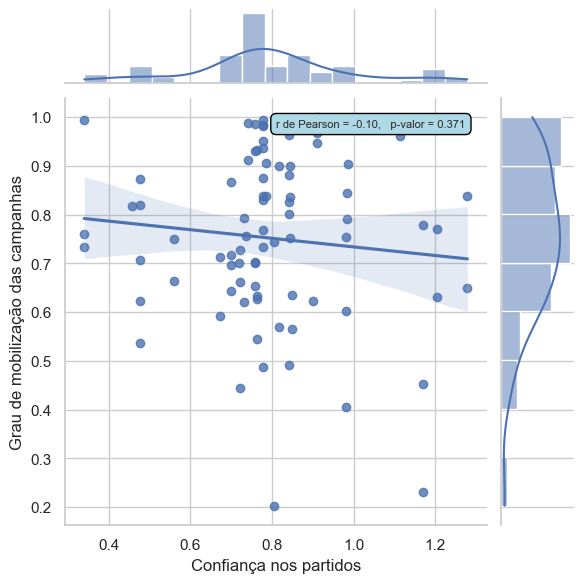

"\nIsolated theres's no association between trust in institutions and mobilization degree\n"

In [75]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

sns.jointplot(ab, y = 'apelos_ativos', x = 'conf_part2', kind='reg')

ab1 = ab.dropna(subset = 'conf_part2')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["apelos_ativos"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Confiança nos partidos")
plt.ylabel("Grau de mobilização das campanhas")

# Mostre o gráfico
plt.show()

'''
Isolated theres's no association between trust in institutions and mobilization degree
'''

### Trust in parties x Variation of GDP - no significant association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/1596972503.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


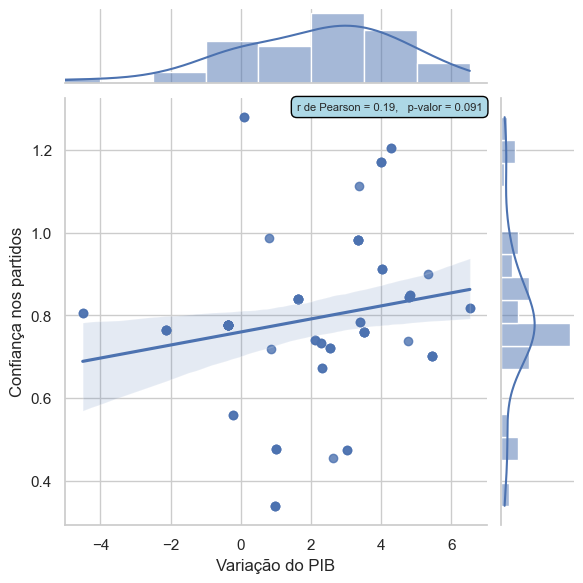

In [77]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'conf_part2', x = 'var_anual_PIBpercapita', kind='reg', xlim=(-5, 7))

ab1 = ab.dropna(subset = 'conf_part2')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["var_anual_PIBpercapita"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Variação do PIB")
plt.ylabel("Confiança nos partidos")
# Mostre o gráfico
plt.show()

### Trust in Parties x Unemployment - No association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/1817985168.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


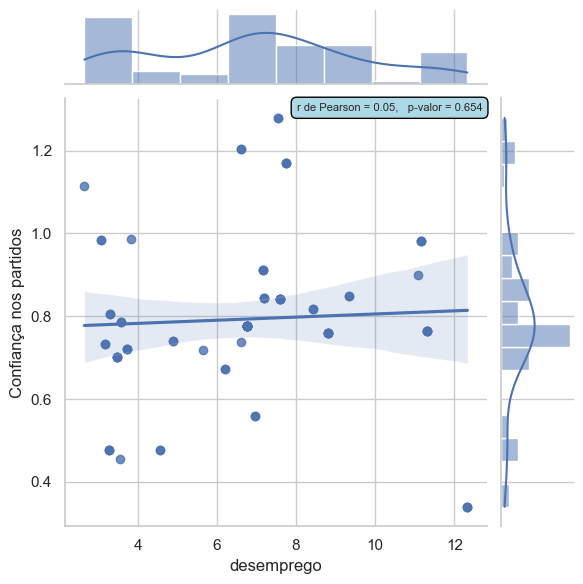

In [78]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'conf_part2', x = 'desemprego', kind='reg')

ab1 = ab.dropna(subset = 'conf_part2')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["desemprego"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("desemprego")
plt.ylabel("Confiança nos partidos")
# Mostre o gráfico
plt.show()

### Trust in Parties x HDI - No association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/3169888091.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


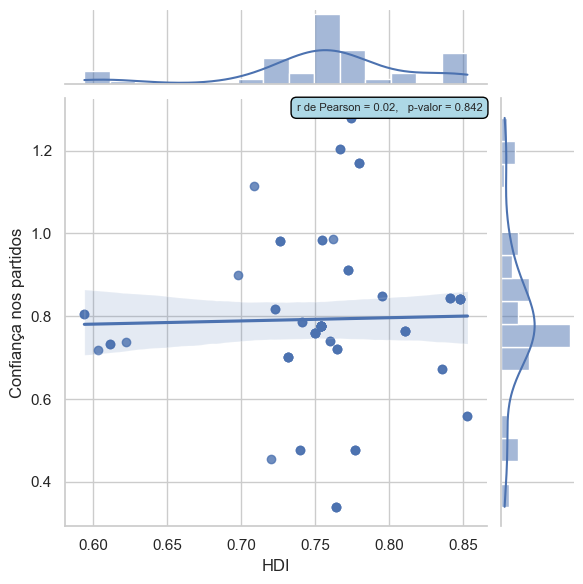

In [74]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'conf_part2', x = 'HDI', kind='reg')

ab1 = ab.dropna(subset = 'conf_part2')
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["HDI"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("HDI")
plt.ylabel("Confiança nos partidos")
# Mostre o gráfico
plt.show()

### Trust in Parties x Inflation - + inflation, + trust in parties

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_43291/3755223559.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


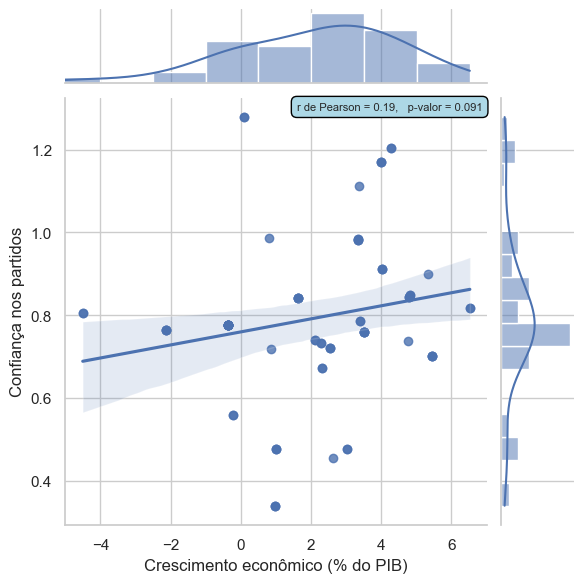

In [601]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'conf_part2', x = 'var_anual_PIBpercapita', kind='reg')

ab1 = ab.dropna(subset = ['conf_part2', 'var_anual_PIBpercapita'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["var_anual_PIBpercapita"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

# Ajuste o título e os rótulos dos eixos
plt.xlabel("Crescimento econômico (% do PIB)")
plt.ylabel("Confiança nos partidos")
plt.xlim(-5, 7)
# Mostre o gráfico
plt.show()

### Trust in parties x Inequality - No association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/4139128392.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),


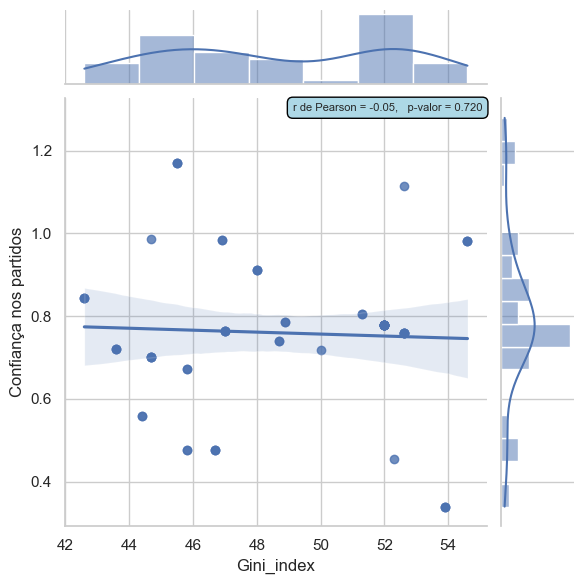

In [80]:
z = dem2.dropna(subset='conf_part2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'conf_part2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'conf_part2', x = 'Gini_index', kind='reg')

ab1 = ab.dropna(subset = ['conf_part2', 'Gini_index'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["Gini_index"], ab1["conf_part2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Gini_index")
plt.ylabel("Confiança nos partidos")
plt.show()

## Economic evaluation relations

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/3724980778.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


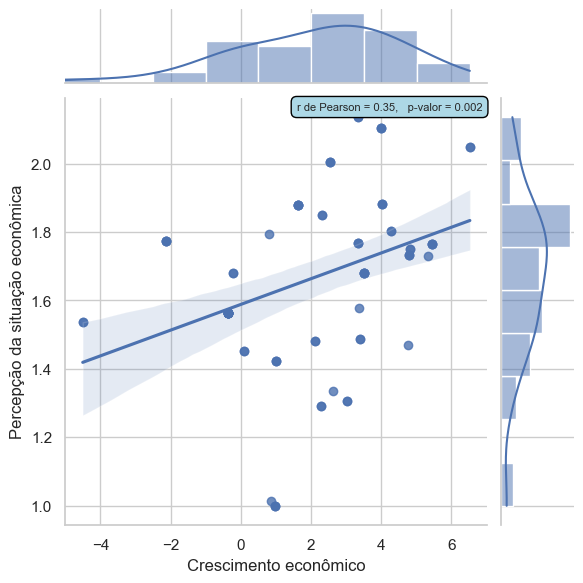

In [86]:
z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'sit_econ2', x = 'var_anual_PIBpercapita', kind='reg', xlim=(-5, 7))

ab1 = ab.dropna(subset = ['sit_econ2', 'var_anual_PIBpercapita'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["var_anual_PIBpercapita"], ab1["sit_econ2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Crescimento econômico")
plt.ylabel("Percepção da situação econômica")
plt.show()

### Economic evaluation x GDP variation - + economic situation, + perception

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/3724980778.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


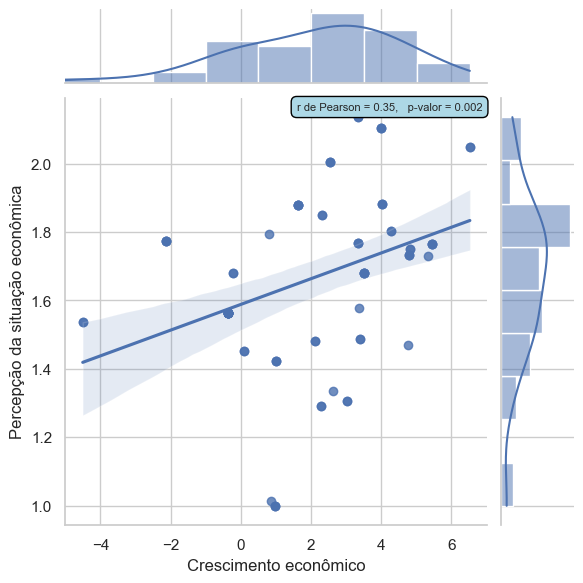

In [86]:
z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'sit_econ2', x = 'var_anual_PIBpercapita', kind='reg', xlim=(-5, 7))

ab1 = ab.dropna(subset = ['sit_econ2', 'var_anual_PIBpercapita'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["var_anual_PIBpercapita"], ab1["sit_econ2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Crescimento econômico")
plt.ylabel("Percepção da situação econômica")
plt.show()

### Economic evaluation x Unemployment - no association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/713543898.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


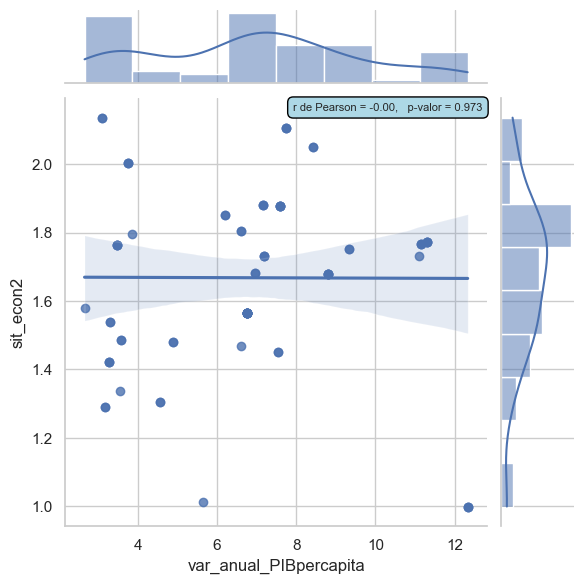

In [87]:
z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'sit_econ2', x = 'desemprego', kind='reg')

ab1 = ab.dropna(subset = ['sit_econ2', 'var_anual_PIBpercapita'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["desemprego"], ab1["sit_econ2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("var_anual_PIBpercapita")
plt.ylabel("sit_econ2")
plt.show()

### Economic evaluation x HDI - + HDI, + economic evaluation

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/2534239210.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


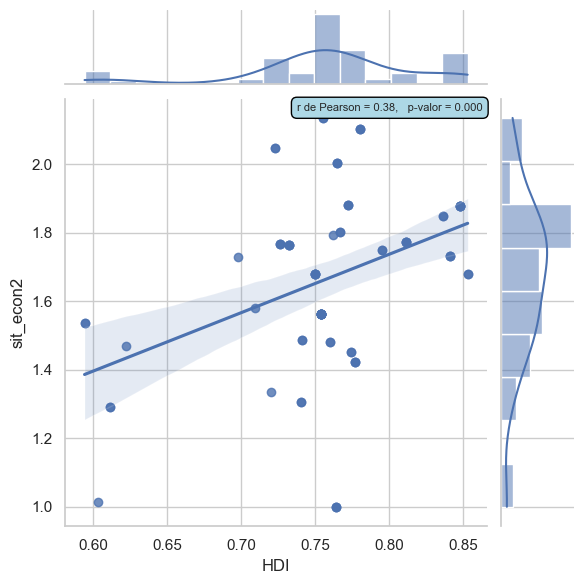

In [88]:
z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'sit_econ2', x = 'HDI', kind='reg')

ab1 = ab.dropna(subset = ['sit_econ2', 'HDI'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["HDI"], ab1["sit_econ2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("HDI")
plt.ylabel("sit_econ2")
plt.show()

### Economic evaluation x inflation - no association

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/149207615.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


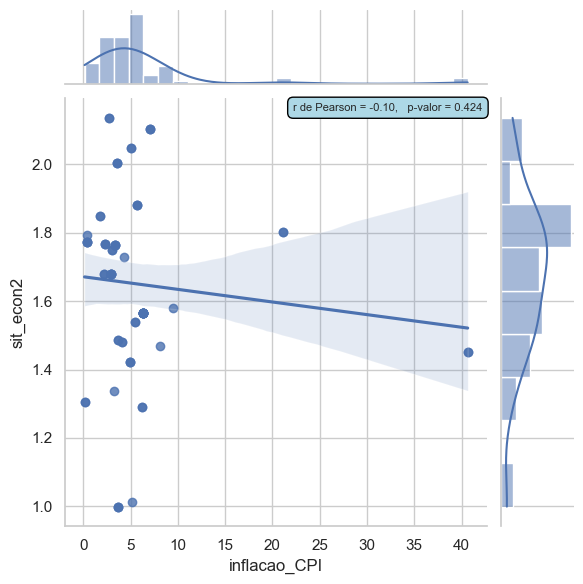

In [89]:
z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'sit_econ2', x = 'inflacao_CPI', kind='reg')

ab1 = ab.dropna(subset = ['sit_econ2', 'inflacao_CPI'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["inflacao_CPI"], ab1["sit_econ2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("inflacao_CPI")
plt.ylabel("sit_econ2")
plt.show()

### Economic evaluation x Unequality - + unequality, - economic evaluation 

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/837709936.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


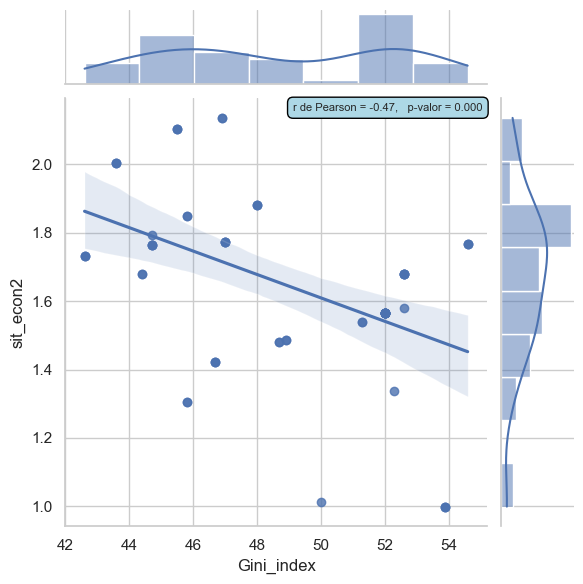

In [90]:
z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

af = sns.jointplot(ab, y = 'sit_econ2', x = 'Gini_index', kind='reg')

ab1 = ab.dropna(subset = ['sit_econ2', 'Gini_index'])
#Adding Correlation coeficcient and its hipothesis test
r, p_valor = stats.pearsonr(ab1["Gini_index"], ab1["sit_econ2"])
plt.annotate(f"r de Pearson = {r:.2f},   p-valor = {p_valor:.3f}", 
             xy=(0.99, 0.99), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Gini_index")
plt.ylabel("sit_econ2")
plt.show()

### Economic evaluation x Degree of polarization - no association

In [91]:
# Weighted appeals

z = dem2.dropna(subset='sit_econ2')
a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                           include_groups=False).reset_index()

a.rename(columns={0:'sit_econ2'}, inplace = True)

ab = pd.merge(ofestim, a, how='left', on=['pais', 'ano_eleicao'])

a = ab[['sit_econ2', 'polariz']].groupby('polariz').agg([lambda x: x.std(ddof=1), 'mean', 'median', lambda x: len(x)])
a.columns = ['std_corr', 'mean', 'median', 'N']
a

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_5698/1274003085.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = z.groupby(['pais', 'ano_eleicao']).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),


std_corr      mean    median   N
polariz                                  
0        0.230103  1.631890  1.563901  37
1        0.276303  1.691786  1.741272  50

In [93]:
std_1 = a.iloc[0,0]
std_2 = a.iloc[1,0]
#std_3 = a.iloc[2,0]
med_1 = a.iloc[0,1]
med_2 = a.iloc[1,1]
#med_3 = a.iloc[2,1]

#b = stats.ttest_ind_from_stats(mean1=med_3, std1=std_3, nobs1=38,
#                     mean2=med_2, std2=std_2, nobs2=17)
c = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=37,
                     mean2=med_2, std2=std_2, nobs2=50)
#d = stats.ttest_ind_from_stats(mean1=med_1, std1=std_1, nobs1=32,
#                     mean2=med_3, std2=std_3, nobs2=38)

print(f'P-value Polarized x Non polarized: {c[1].round(3)}')


P-value Polarized x Non polarized: 0.287


Ttest_indResult(statistic=-1.0715758987740625, pvalue=0.2869437176076419)

### Multiple

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_56075/578171750.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sit_econ2_avg = z.groupby(['pais', 'ano_eleicao']).apply(
/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_56075/578171750.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conf_part2_avg = z.groupby(['pais', 'ano_eleicao']).apply(


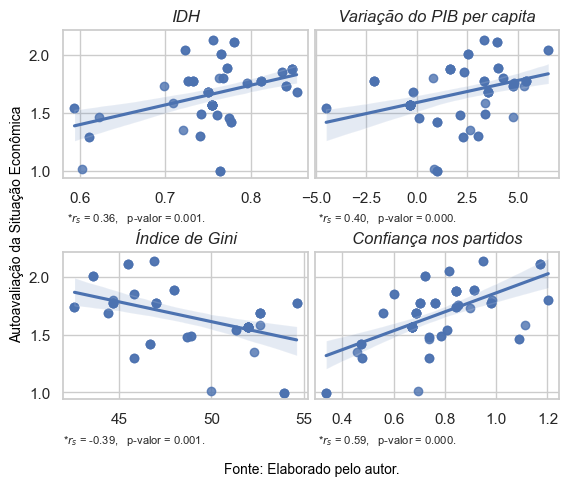

In [68]:
#| fig-cap: 'Associação entre autoavaliação econômica e variáveis contextuais'
#| label: fig-associ

z = dem2.dropna(subset=['sit_econ2', 'conf_part2'])

# Weighted average of economic evaluation
sit_econ2_avg = z.groupby(['pais', 'ano_eleicao']).apply(
    lambda x: np.average(x['sit_econ2'], weights=x['peso']),
    include_groups=False
).reset_index()
sit_econ2_avg.rename(columns={0:'sit_econ2'}, inplace = True)

# Weighted average of trust in parties
conf_part2_avg = z.groupby(['pais', 'ano_eleicao']).apply(
    lambda x: np.average(x['conf_part2'], weights=x['peso']),
    include_groups=False
).reset_index()

conf_part2_avg.rename(columns={0:'conf_part2'}, inplace = True)

ab1 = pd.merge(ofestim, sit_econ2_avg, how='left', on=['pais', 'ano_eleicao'])
ab = pd.merge(ab1, conf_part2_avg, how='left', on=['pais', 'ano_eleicao'])


af, axes = plt.subplots(2, 2, sharey=True)

# HDI

sns.regplot(
    x="HDI",
    y="sit_econ2",
    data=ab,
    fit_reg=True, ax=axes[0,0] 
)
axes[0,0].set_ylabel('')
axes[0,0].set_title('IDH', style='italic')
axes[0,0].set(ylabel='', xlabel='')



#Adding Correlation coeficcient HDI
ab1 = ab.dropna(subset=['sit_econ2', 'HDI'])
rh, p_valorh = stats.spearmanr(ab1["HDI"], ab1["sit_econ2"])
plt.annotate(f"*$r_s$ = {rh:.2f},   p-valor = {p_valorh:.3f}.", 
             xy=(-0.45, 1.27), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8)

# GDP per capita variation

sns.regplot(
    x="var_anual_PIBpercapita",
    y="sit_econ2",
    data=ab,
    fit_reg=True, ax=axes[0,1] 
)
axes[0,1].set(ylabel='')
axes[0,1].set_title('Variação do PIB per capita', style='italic')
axes[0,1].set(ylabel='', xlabel='')

#Adding Correlation coeficcient GDP
ab1 = ab.dropna(subset=['sit_econ2', 'var_anual_PIBpercapita'])
rg, p_valorg = stats.spearmanr(ab1["var_anual_PIBpercapita"], ab1["sit_econ2"])
plt.annotate(f"*$r_s$ = {rg:.2f},   p-valor = {p_valorg:.3f}.", 
             xy=(0.58, 1.27), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8)

# Unequality 

sns.regplot(
    x="Gini_index",
    y="sit_econ2",
    data=ab,
    fit_reg=True, ax=axes[1,0] 
)
axes[1,0].set(ylabel='', xlabel='')
axes[1,0].set_title('Índice de Gini', style='italic')

#Adding Correlation coeficcient Unequality
ab1 = ab.dropna(subset=['sit_econ2', 'Gini_index'])
ru, p_valoru = stats.spearmanr(ab1["Gini_index"], ab1["sit_econ2"])
plt.annotate(f"*$r_s$ = {ru:.2f},   p-valor = {p_valoru:.3f}.", 
             xy=(-0.45, -0.23), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8)


# Trust in Parties

sns.regplot(
    x="conf_part2",
    y="sit_econ2",
    data=ab,
    fit_reg=True, ax=axes[1,1] 
)
axes[1,1].set(ylabel='', xlabel='')
axes[1,1].set_title('Confiança nos partidos', style='italic')

#Adding Correlation coeficcient trust in parties
ab1 = ab.dropna(subset=['sit_econ2', 'conf_part2'])
rt, p_valort = stats.spearmanr(ab1["conf_part2"], ab1["sit_econ2"])
plt.annotate(f"*$r_s$ = {rt:.2f},   p-valor = {p_valort:.3f}.", 
             xy=(0.58, -0.23), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top', fontsize=8)

# Figure y label

plt.text(
    -0.87, 3.48,
    "Autoavaliação da Situação Econômica",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black", rotation=90
)

# Source

plt.text(
    0.28, 0.4,
    "Fonte: Elaborado pelo autor.",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black"
)


plt.subplots_adjust(wspace=0.03, hspace=0.5)
#plt.show

In [59]:
ofestim.columns

Index(['pais', 'ano_eleicao', 'candidato', 'tipo_apelo', 'apelos_ativos',
       'neutralidade_apelo', 'Orientacao', 'Candidato_minoria', 'Incumbente',
       'Situacao_oposicao', 'Partidos', 'Votos_1T', 'Votos_2T', 'Peças_TV',
       'Tempo total (minutos)', 'Tempo total (segundos)',
       'Tempo total (HH:MM:SS)', 'Eleito', 'eleicao_2turnos',
       'candidato_2turno', 'Link eleição', 'var_anual_PIBpercapita', 'HDI',
       'GNI', 'inflacao_CPI', 'Gini_index', 'desemprego', 'N_apelo',
       'dif_votos', 'polariz', 'princ_tema_maincats',
       'princ_probelec_maincats', 'match_probtema_maincats', 'IMP'],
      dtype='object')

# Pra acabar análises do capítulo II.

    
- Também ver aquele argumento da Vavreck se faz sentido: em condições economicas boas situação que foca em temas econômicos tem mais chances de ganhar

# Ploting Latinamerican map highlighting countries included in the dataset

/var/folders/5t/m2j8g3ms4714qrywsn5fg_bc0000gn/T/ipykernel_1698/2734084370.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  AL = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


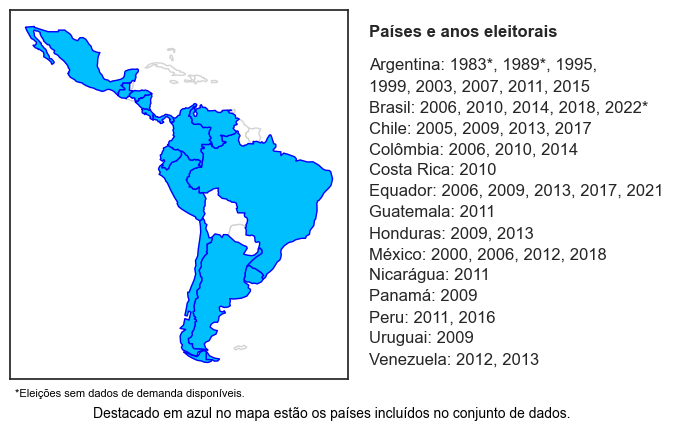

In [735]:
#| label: fig-paiselec
#| fig-cap: "Abrangência do conjunto de dados LADaPrEC"

# Filtering latin america

sns.set_theme(style='white')
AL = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
al = AL[(AL.continent=='South America') | (AL.continent=='North America')]
al = al[(al.name != 'United States of America') & (al.name != 'Canada') & (al.name != 'Greenland')]

#Plotting white map

fig=al.plot(color = 'white', edgecolor='lightgray')
plt.tick_params(bottom = False, left = False, labelleft = False, labelbottom = False) 
#fig.set_axis_off()

# Countries legend
ar = 'Argentina: 1983*, 1989*, 1995,\n1999, 2003, 2007, 2011, 2015\n'
br = 'Brasil: 2006, 2010, 2014, 2018, 2022*\n'
ch = 'Chile: 2005, 2009, 2013, 2017\n'
colcoseqgua = 'Colômbia: 2006, 2010, 2014\nCosta Rica: 2010\nEquador: 2006, 2009, 2013, 2017, 2021\nGuatemala: 2011\n'
honmexnicpanper = 'Honduras: 2009, 2013\nMéxico: 2000, 2006, 2012, 2018\nNicarágua: 2011\nPanamá: 2009\nPeru: 2011, 2016\n'
urven = 'Uruguai: 2009\nVenezuela: 2012, 2013'
fig.text(-25, 30, 'Países e anos eleitorais', weight = 'bold')
fig.text(-25, -56, ar + br + ch + colcoseqgua + honmexnicpanper + urven, linespacing=1.5)


# footnote *

nota_de_rodape = plt.text(
    -120,  -65,
    '*Eleições sem dados de demanda disponíveis.',
    ha="left",
    va="bottom",    
    fontsize=8, 
    color="black"
)

# footnote

nota_de_rodape = plt.text(
    -35,  -71,
    'Destacado em azul no mapa estão os países incluídos no conjunto de dados.',
    ha="center",
    va="bottom",    
    fontsize=10, 
    color="black"
)


#Plot selected countries
corre = ['Brazil', 'Ecuador', 'Mexico', 'Nicaragua', 'Uruguay', 'Panama', 'Colombia']
af = ofer.pais.unique().tolist()
af.extend(corre)
al[al.name.isin(af)].plot( ax=fig, edgecolor='blue', color = '#00BFFF')
plt.show()